In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/'My Drive'/'All_Repos'/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
%matplotlib inline

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1851392/45929032 bytes (4.0%)5734400/45929032 bytes (12.5%)9658368/45929032 bytes (21.0%)13549568/45929032 bytes (29.5%)17530880/45929032 bytes (38.2%)21389312/45929032 bytes (46.6%)25247744/45929032 bytes (55.0%)29229056/45929032 bytes (63.6%)33226752/45929032 bytes (72.3%)37265408/45929032 bytes (81.1%)41263104/45929032 bytes (89.8%)45260800/45929032 bytes (98.5%)

## Camera Calibration

Create the camera matrix and distortion coefficient and write it to a pickle

In [0]:
import pickle

images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
  
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
for image in images:
  img = cv2.imread(image)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
  ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
  if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

camera_cal = {"mtx":mtx,"dist":dist}

pickle.dump(camera_cal,open("pickle/cal.p","wb"))

Read mxt and dist from pickle

In [0]:
import pickle
camera_cal = pickle.load( open( "pickle/cal.p", "rb" ) )

mtx = camera_cal["mtx"]
dist = camera_cal["dist"]

# Disrtotion Correction

In [0]:
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(8, 2, figsize=(20, 40))
for ax, img in zip(axs, images):
  img = cv2.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  ax[0].imshow(img)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  ax[1].imshow(undist)
  
plt.show() 
  

Output hidden; open in https://colab.research.google.com to view.

## Threshold

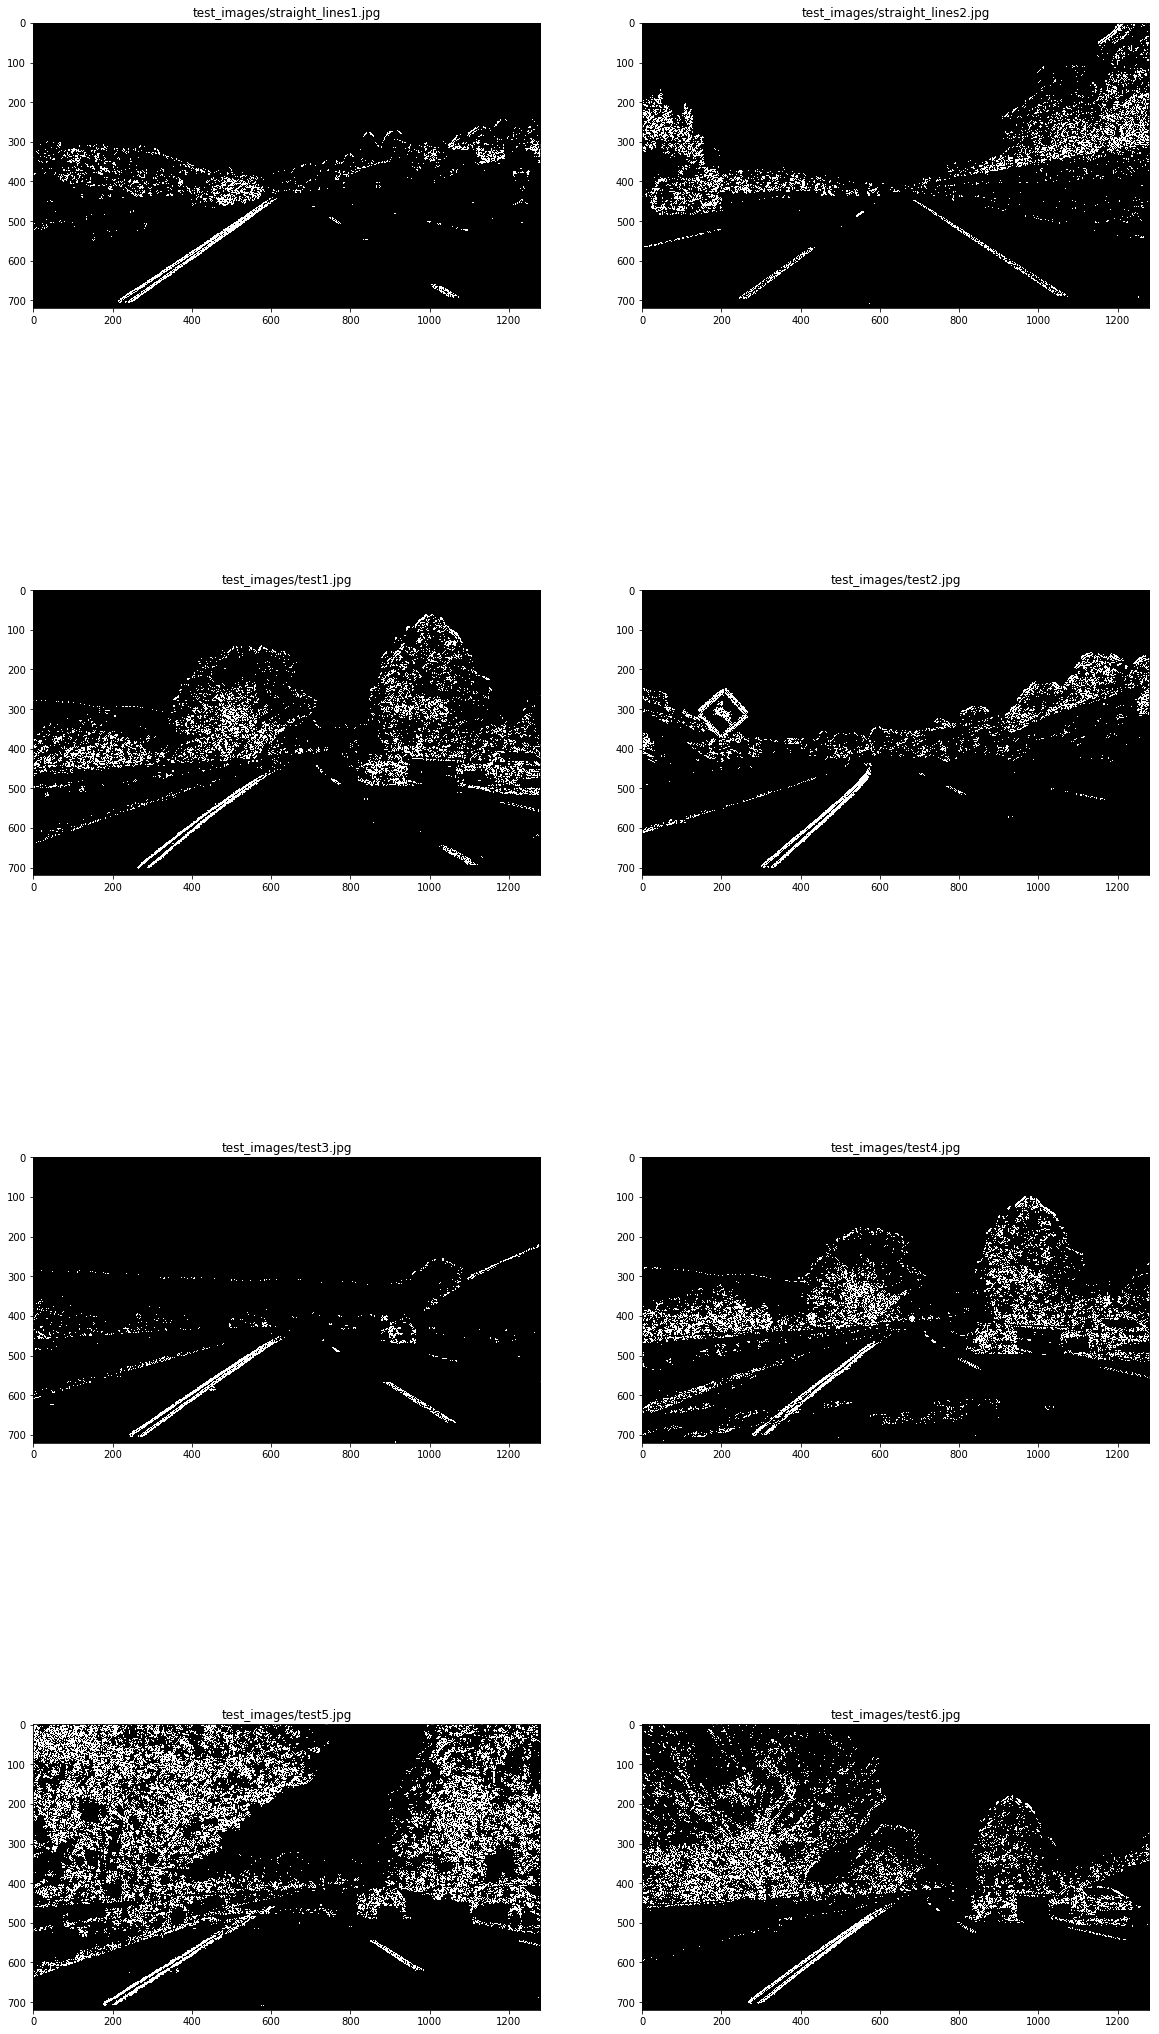

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 160)):
    # Calculate directional gradient
    # Apply threshold
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #img = cv2.GaussianBlur(img,(3,3),0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    if orient == 'x':
        sobelx = cv2.Sobel(s_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
        scaled = np.abs(255*sobelx/np.max(sobelx)).astype('uint8')
    elif orient == 'y':
        sobely = cv2.Sobel(s_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)
        scaled = np.abs(255*sobely/np.max(sobely)).astype('uint8')
    
    binary = np.zeros_like(scaled)
    binary[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary

 
def threshold_mask(img, sobel_kernel=3,s_thresh=(10, 160), sx_thresh=(10,160),sy_thresh=(10,160),dir_thresh=(0,np.pi/2)):
    img = np.copy(img)
    
      
    # Threshold x gradient
    
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=sx_thresh)
    sybinary = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=sx_thresh)
    
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (sybinary == 1)) ] = 1
    # Stack each channel
    
    return combined
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  result = threshold_mask(undist)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 

## Region of Interest


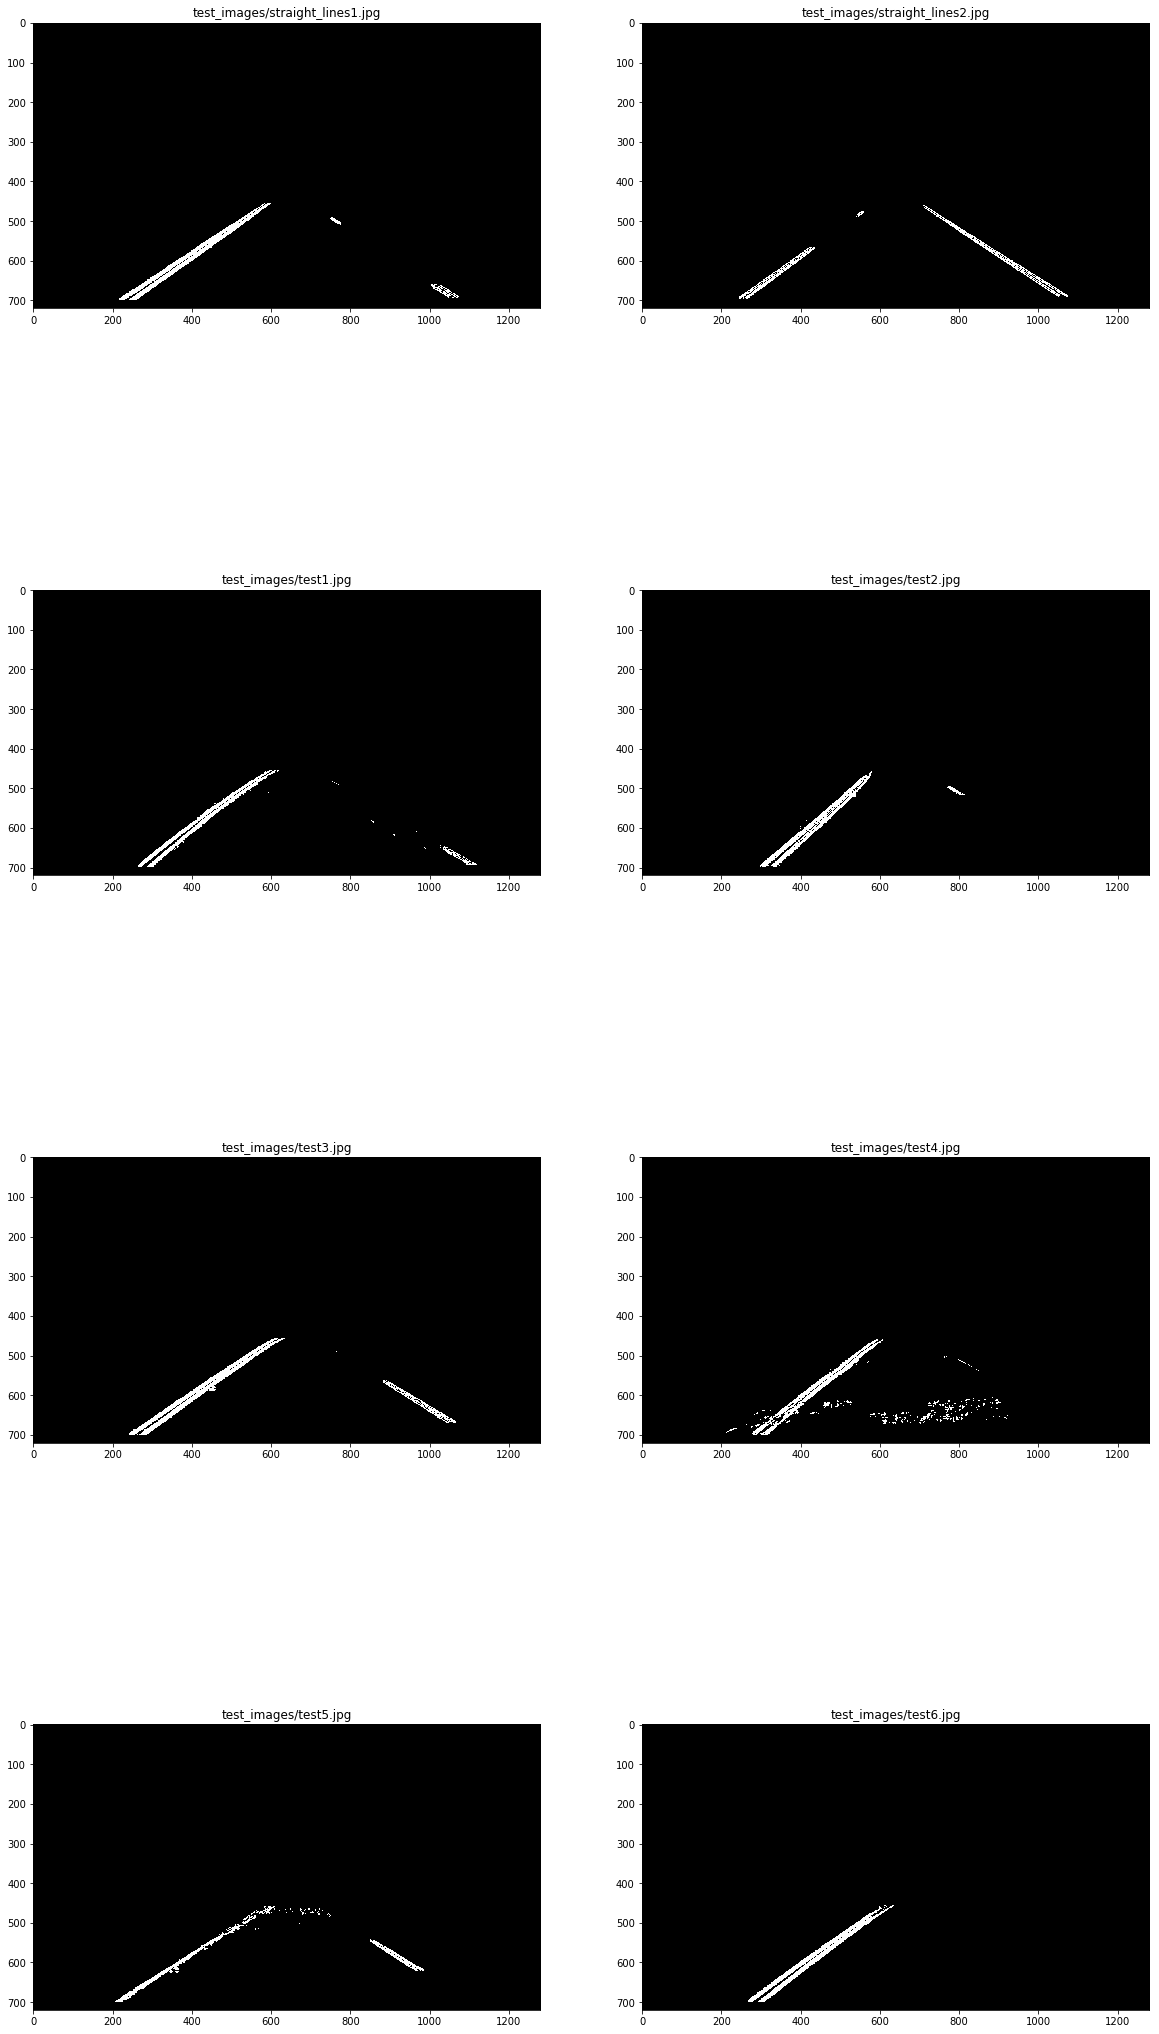

In [0]:
def roi(img):
  
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    vertices = np.array([[[200,700],[585,455],[705,455],[1130,700]]],dtype='int32')
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  result = roi(threshold_masked)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 


## Perspective Transform

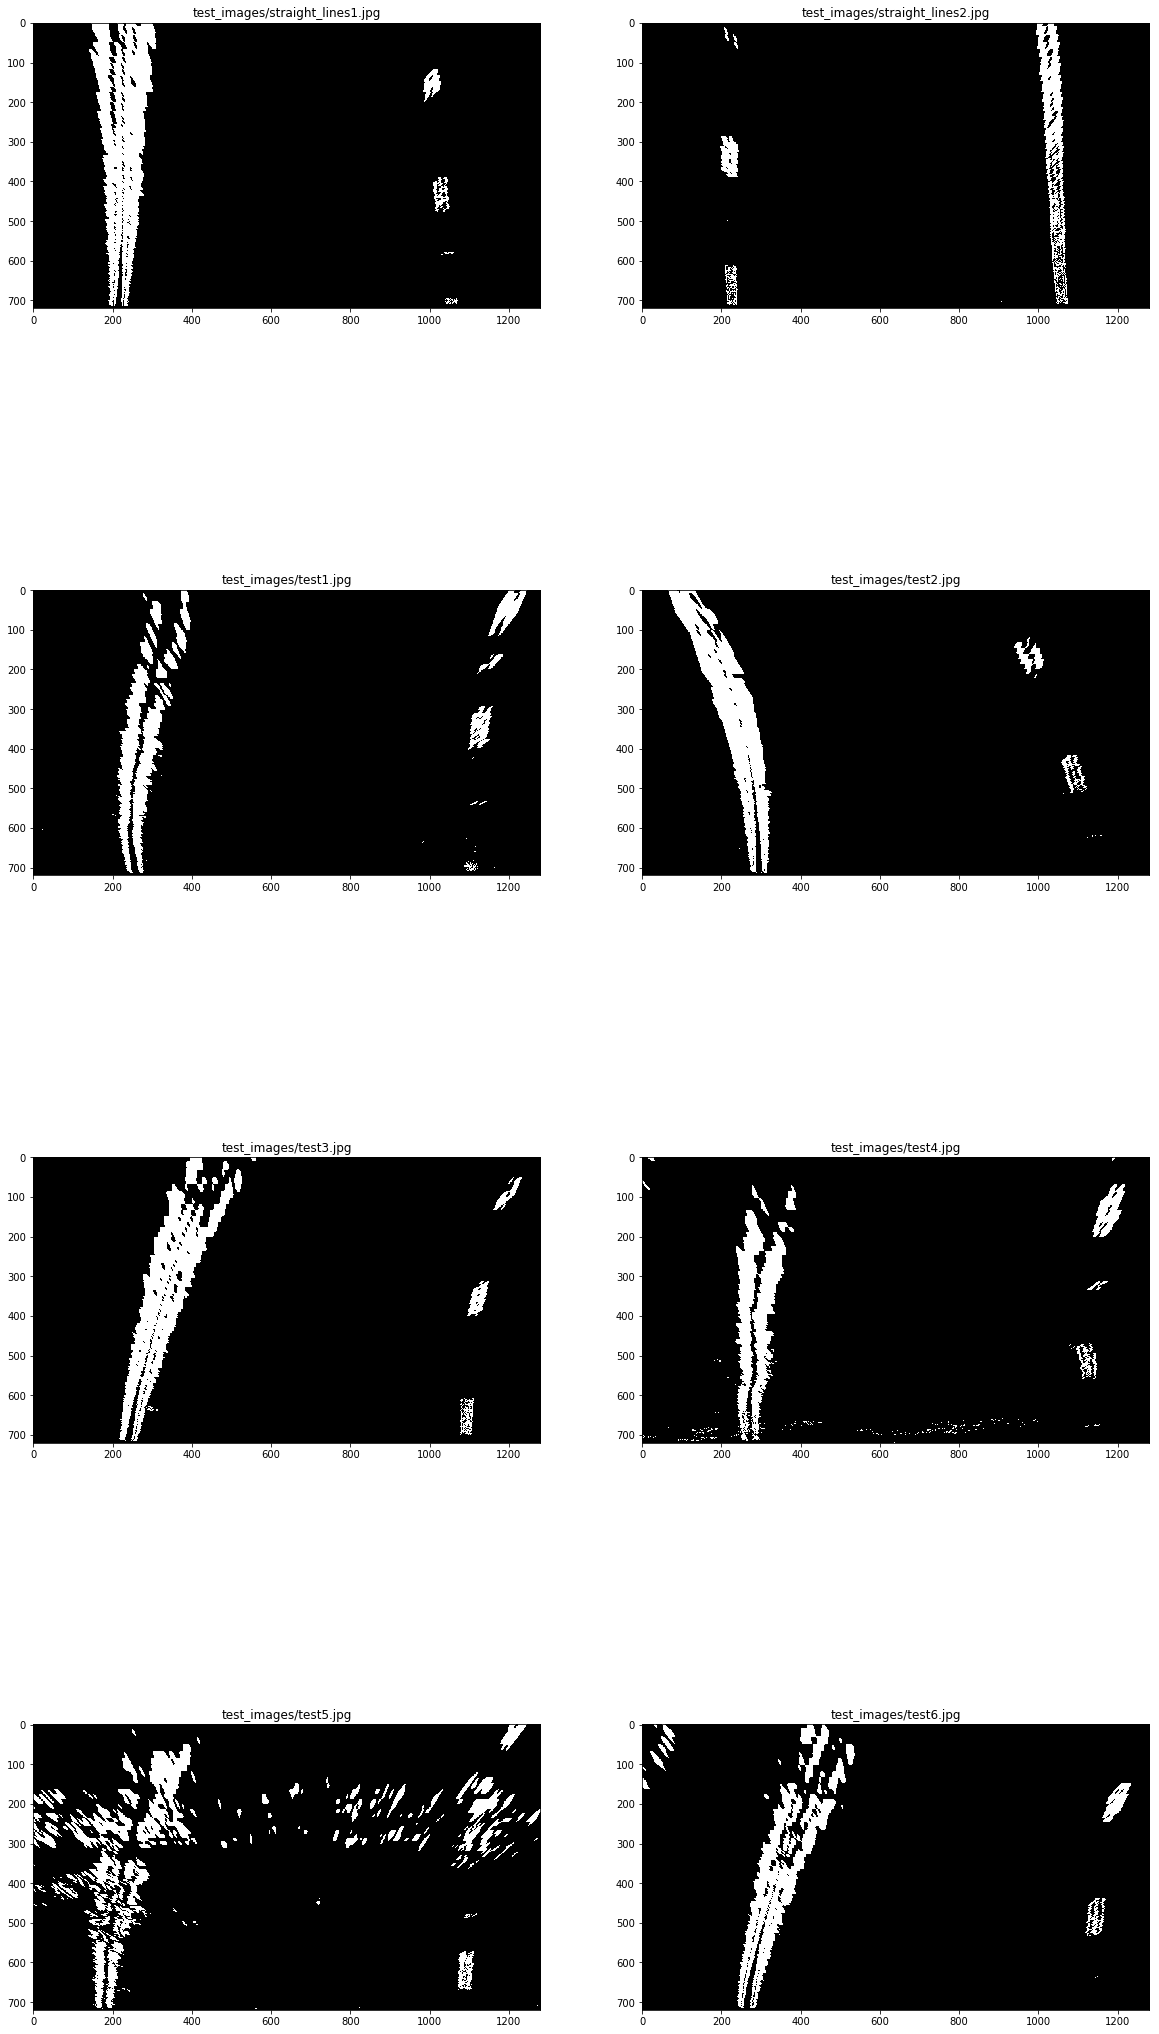

In [34]:
import pickle

def perspective_transform(img):

    
    
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    leftupperpoint  = [585,455]
    rightupperpoint = [705,455]
    leftlowerpoint  = [190,720]
    rightlowerpoint = [1130,720]
    
    src = np.float32([leftupperpoint,rightupperpoint,
                      rightlowerpoint,leftlowerpoint])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
    dst = np.float32([[200,0],[img_size[0]-200,0], [img_size[0]-200,img_size[1]],[200,img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    perspective = {"M":M,"Minv":Minv}
    pickle.dump( perspective,open( "pickle/pers.p", "wb" ) )
    
    return warped
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  #roi_img = roi(threshold_masked)
  result = perspective_transform(threshold_masked)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 

In [37]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
 
        

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
     
    
    
    
    return result,ploty,left_fit,right_fit

#def display_lines()
def pipeline(img):
  #path = img
  #img = cv2.imread(img)
  #plt.imshow(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  #roi_img = roi(threshold_masked)
  birds_eye_view = perspective_transform(threshold_masked)
  result,ploty,left_fit,right_fit = search_around_poly(birds_eye_view)
  
  return result,ploty,left_fit,right_fit,birds_eye_view,undist

def draw_lanelines(ploty,left_fitx,right_fitx,left_curverad,right_curverad,birds_eye_view,undist):
  perspective = pickle.load( open( "pickle/pers.p", "rb" ) )
  Minv = perspective['Minv']
  
  
  
  # Create an image to draw the lines on
  warp_zero = np.zeros_like(birds_eye_view).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
  
  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
  
  curve_rad = (left_curverad + right_curverad)/2
  lane_center = left_fitx[len(left_fitx)-1] + (right_fitx[len(right_fitx)-1] - left_fitx[len(left_fitx)-1])/2
  veh_center = undist.shape[1]/2
 
  dist_frm_center = (lane_center - veh_center)*3.7/700
  print(dist_frm_center)
  # Warp the blank back to original image space using inverse perspective matrix (Minv)
  newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
  font = cv2.FONT_HERSHEY_DUPLEX
  text = 'Curve radius: ' + '{:04.2f}'.format(curve_rad) + 'km'
  cv2.putText(newwarp, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
  
  text = '{:04.3f}'.format(dist_frm_center) + 'm '
  cv2.putText(newwarp, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
  # Combine the result with the original image
  result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

  return result


  
def main():
  Left_line = Line()
  Right_line = Line()
  white_output = 'project_video_output.mp4'
  clip = VideoFileClip('/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines/project_video.mp4')
  
  def process_image(image):
    result,ploty,left_fit,right_fit,birds_eye_view,undist = pipeline(image)
    
   
    
    # Accumulate the last 5 fits and get the average fit
    if len(Left_line.current_fit) == 5:
      Left_line.current_fit.pop(0)
      Left_line.current_fit.append(np.array(left_fit))
      Left_line.best_fit = np.mean(Left_line.current_fit, axis = 0)
    elif len(Left_line.current_fit) < 5 or None:
      Left_line.current_fit.append(np.array(left_fit))
      Left_line.best_fit = np.mean(Left_line.current_fit, axis = 0)
 
    if len(Right_line.current_fit) == 5:
      Right_line.current_fit.pop(0)
      Right_line.current_fit.append(np.array(right_fit))
      Right_line.best_fit = np.mean(Right_line.current_fit, axis = 0)
    elif len(Right_line.current_fit) < 5 or None:
      Right_line.current_fit.append(np.array(right_fit))
      Right_line.best_fit = np.mean(Right_line.current_fit, axis = 0)
      
    left_fitx = Left_line.best_fit[0]*ploty**2 + Left_line.best_fit[1]*ploty + Left_line.best_fit[2]
    right_fitx = Right_line.best_fit[0]*ploty**2 + Right_line.best_fit[1]*ploty + Right_line.best_fit[2]
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])/1000
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])/1000
      

    
    if Left_line.radius_of_curvature == None:
      Left_line.radius_of_curvature = left_curverad

    if Right_line.radius_of_curvature == None:
      Right_line.radius_of_curvature = right_curverad


    print(left_curverad,right_curverad)
    if abs(abs(left_curverad) - abs(right_curverad)) < 10:
      Left_line.radius_of_curvature = left_curverad
      Right_line.radius_of_curvature = right_curverad
      Left_line.bestx = left_fitx
      Right_line.bestx = right_fitx
    

    result = draw_lanelines(ploty,Left_line.bestx,Right_line.bestx,left_curverad,right_curverad,birds_eye_view,undist)
    return result
  edge_clip = clip.fl_image(process_image)
  #[process_image(frame) for frame in clip.iter_frames()]
  %time edge_clip.write_videofile(white_output, audio=False)
    
  
    
    #result = find_lane_pipeline(image)
    #return result

if __name__ == '__main__':
  main()

0.7999422004718586 9.072809778867457
-1.4680004625424103
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4








  0%|          | 0/1261 [00:00<?, ?it/s]

0.5999662323786715 6.80769833741221
-0.8297149024374995








  0%|          | 1/1261 [00:00<03:46,  5.56it/s]





  0%|          | 2/1261 [00:00<03:56,  5.33it/s]

0.5216076118396469 8.090116475372243
-0.5193892648215361
0.4808034486468756 3.6520167121298854
-0.33426001521924914








  0%|          | 3/1261 [00:00<03:58,  5.28it/s]





  0%|          | 4/1261 [00:00<03:55,  5.34it/s]

0.3787921666397706 1.981007287164008
0.4223969038631291
0.3667214950618502 1.2075978460106145
0.4102824849544076








  0%|          | 5/1261 [00:00<03:55,  5.33it/s]





  0%|          | 6/1261 [00:01<03:49,  5.46it/s]





  1%|          | 7/1261 [00:01<03:43,  5.62it/s]

0.36371701569091297 0.901347931847461
0.4025863367266793
0.3705787630240273 0.8220429173778958
0.40460565227261563








  1%|          | 8/1261 [00:01<03:37,  5.77it/s]







0.3817478608736502 0.7265152979669292
0.4074040355031999
0.39897058841574906 0.71163648563576
0.41376966836832807


  1%|          | 9/1261 [00:01<03:35,  5.82it/s]





  1%|          | 10/1261 [00:01<03:39,  5.70it/s]







0.4246609184776838 0.7920637616514145
0.42922591672335664
0.4369149559249615 0.7433154090149924
0.43504725770270586


  1%|          | 11/1261 [00:01<03:37,  5.74it/s]





  1%|          | 12/1261 [00:02<03:37,  5.74it/s]







0.44623255678660456 0.7873424849425992
0.440219063605115
0.46272083150686716 0.8206259431191089
0.44421619516745126


  1%|          | 13/1261 [00:02<03:38,  5.71it/s]





  1%|          | 14/1261 [00:02<03:38,  5.71it/s]





  1%|          | 15/1261 [00:02<03:35,  5.78it/s]

0.48253911102284475 1.1130229275179713
0.4556475622384636
0.49306621979295534 0.9944326977884251
0.45015261138407514








  1%|▏         | 16/1261 [00:02<03:38,  5.70it/s]







0.5016640148729903 1.212077154979509
0.4472081208720696
0.5031557375555321 1.4561289673024795
0.4379778069921056


  1%|▏         | 17/1261 [00:03<03:37,  5.73it/s]





  1%|▏         | 18/1261 [00:03<03:38,  5.69it/s]

0.48490919765164603 2.1863789689176785
0.4250099055995516
0.4602033520393708 2.086182669834092
0.40168259595805084








  2%|▏         | 19/1261 [00:03<03:42,  5.59it/s]





  2%|▏         | 20/1261 [00:03<03:39,  5.65it/s]





  2%|▏         | 21/1261 [00:03<03:38,  5.69it/s]

0.4555393244189345 4.098837740480656
0.3911427947776785
0.4583436009656604 2.8938956150158806
0.37637150119364166








  2%|▏         | 22/1261 [00:03<03:37,  5.70it/s]





  2%|▏         | 23/1261 [00:04<03:34,  5.78it/s]

0.47456040579497283 1.8216530789229313
0.36616129203439274
0.49273041378336135 4.8132436840630755
0.3729419016863951








  2%|▏         | 24/1261 [00:04<03:35,  5.73it/s]





  2%|▏         | 25/1261 [00:04<03:32,  5.81it/s]

0.5025729299684042 5.92653836404918
0.36548799038927765
0.48821590732836545 1.7631458336396097
0.35110696609555975








  2%|▏         | 26/1261 [00:04<03:36,  5.70it/s]

0.48669483378095507 1.4890330079791179
0.34528808460488675
0.469400501908418 1.8827186541115861
0.34463519960371747








  2%|▏         | 27/1261 [00:04<03:39,  5.61it/s]





  2%|▏         | 28/1261 [00:04<03:42,  5.53it/s]







0.462400461862037 0.7712574679368926
0.33341416884535496
0.46046170359276933 0.8482208899571443
0.3332739643740707


  2%|▏         | 29/1261 [00:05<03:38,  5.63it/s]





  2%|▏         | 30/1261 [00:05<03:37,  5.65it/s]





  2%|▏         | 31/1261 [00:05<03:35,  5.72it/s]

0.4525467413181422 1.040110124903213
0.3343816790574814
0.42409631090320776 1.2522506508705913
0.3316760700075365








  3%|▎         | 32/1261 [00:05<03:32,  5.77it/s]





  3%|▎         | 33/1261 [00:05<03:30,  5.82it/s]

0.39477946359553473 1.1239433341329341
0.32433887551862356
0.36750677385752234 0.9640199989155949
0.31967467835324515








  3%|▎         | 34/1261 [00:06<03:30,  5.82it/s]

0.3429518706060114 0.8744145519168564
0.3197203057755649
0.3266928226022766 0.8099941954145562
0.3198297921656651








  3%|▎         | 35/1261 [00:06<03:31,  5.79it/s]





  3%|▎         | 36/1261 [00:06<03:32,  5.76it/s]





  3%|▎         | 37/1261 [00:06<03:30,  5.81it/s]

0.3162573230072071 0.713435995054073
0.32600432417602326
0.3085913642605345 0.6551466422863812
0.3287883584591249








  3%|▎         | 38/1261 [00:06<03:29,  5.83it/s]

0.29678085765535933 0.5586196965154666
0.32248771914990143
0.2868015726618095 0.5738015852620286
0.3222603576622901








  3%|▎         | 39/1261 [00:06<03:37,  5.62it/s]





  3%|▎         | 40/1261 [00:07<03:33,  5.72it/s]





  3%|▎         | 41/1261 [00:07<03:32,  5.75it/s]

0.28009128905829206 0.5619516488369592
0.3244598146856366
0.2803528919988164 0.6034112545965041
0.32641969014685784








  3%|▎         | 42/1261 [00:07<03:30,  5.79it/s]

0.27727413796377404 0.6975040925011479
0.3292414365201871








  3%|▎         | 43/1261 [00:07<03:48,  5.34it/s]

0.28123761895893157 0.899834526316623
0.3386633647601422








  3%|▎         | 44/1261 [00:07<04:14,  4.77it/s]

0.2906063473253161 1.070417601160388
0.3441500592205671








  4%|▎         | 45/1261 [00:08<04:10,  4.85it/s]

0.3000590975118605 1.2243181673881043
0.3519115674793992
0.30580488675981277 40.82550895252263
0.3519115674793992








  4%|▎         | 46/1261 [00:08<03:59,  5.07it/s]





  4%|▎         | 47/1261 [00:08<04:02,  5.02it/s]

0.31975247946634305 1.5948779985432904
0.3955811543695132








  4%|▍         | 48/1261 [00:08<04:19,  4.67it/s]

0.33130907660465864 2.007244914413555
0.40013050819549056








  4%|▍         | 49/1261 [00:08<04:17,  4.72it/s]

0.3446076880099895 3.092740285580703
0.4040785803508955
0.3607125727782904 







  4%|▍         | 50/1261 [00:09<04:13,  4.78it/s]

3.3924568722068917
0.4090699337507201








  4%|▍         | 51/1261 [00:09<04:15,  4.73it/s]

0.3769086327128255 1.2484928101303459
0.3871066975938967








  4%|▍         | 52/1261 [00:09<04:14,  4.75it/s]

0.3977941326889072 0.5984862360795191
0.3774243507617524
0.41866002748775466 0.5351449704532912








  4%|▍         | 53/1261 [00:09<04:10,  4.82it/s]

0.3771326585078733
0.437187973629713 0.5415396036483946








  4%|▍         | 54/1261 [00:09<04:08,  4.85it/s]

0.3771529695488727
0.4552814913365967 0.5475340242334031
0.370159477645146








  4%|▍         | 55/1261 [00:10<04:02,  4.98it/s]





  4%|▍         | 56/1261 [00:10<04:05,  4.91it/s]

0.4789528387206601 0.5735263430990797
0.366835989383293








  5%|▍         | 57/1261 [00:10<04:09,  4.82it/s]

0.5017169111316855 0.5943329186089761
0.35941586693193617








  5%|▍         | 58/1261 [00:10<04:08,  4.84it/s]

0.5215288789410556 0.6361308858435603
0.3595704496008504
0.520002796648875 0.8947656676036964
0.363589920525397








  5%|▍         | 59/1261 [00:10<04:05,  4.89it/s]





  5%|▍         | 60/1261 [00:11<04:06,  4.87it/s]

0.5097509225247878 0.8961830383079291
0.3602463832885083
0.498785815766006 0.9806088916421203
0.35759401088237724








  5%|▍         | 61/1261 [00:11<04:02,  4.95it/s]





  5%|▍         | 62/1261 [00:11<04:00,  4.98it/s]

0.482618424249487 0.9672201637927316
0.3504148745379679
0.469976318777912 1.1033763736419528
0.33868722362815995








  5%|▍         | 63/1261 [00:11<03:59,  5.00it/s]





  5%|▌         | 64/1261 [00:11<04:10,  4.78it/s]

0.46591102777333815 0.6967148546598358
0.3191480593325341








  5%|▌         | 65/1261 [00:12<04:14,  4.69it/s]

0.45983751610854917 0.5797509972706529
0.30535256404464933
0.4435624291195215 0.6523837574552556
0.2970458116584339








  5%|▌         | 66/1261 [00:12<04:05,  4.86it/s]





  5%|▌         | 67/1261 [00:12<04:01,  4.95it/s]

0.43079579325753087 0.7729308590422679
0.28931659943434423








  5%|▌         | 68/1261 [00:12<04:19,  4.60it/s]

0.42292436932205646 0.8824870630043177
0.2751295641413482








  5%|▌         | 69/1261 [00:13<04:19,  4.59it/s]

0.415200151488778 1.2873426835369932
0.2629422688220185








  6%|▌         | 70/1261 [00:13<04:19,  4.59it/s]

0.422088266225171 1.7291862388562758
0.25828119120572973








  6%|▌         | 71/1261 [00:13<04:19,  4.58it/s]

0.428356738521611 1.7801720233356566
0.2535092247741102
0.4378606771202804 1.7416571260269882








  6%|▌         | 72/1261 [00:13<04:17,  4.63it/s]

0.2510123136520593








  6%|▌         | 73/1261 [00:13<04:27,  4.44it/s]

0.4505575591264596 1.2158291124113128
0.2504846097653279
0.47438722852941706 0.9351833748466707
0.25062605835210855








  6%|▌         | 74/1261 [00:14<04:15,  4.65it/s]





  6%|▌         | 75/1261 [00:14<04:05,  4.84it/s]

0.4999359172077969 1.0199335315896811
0.2492814795288197








  6%|▌         | 76/1261 [00:14<04:22,  4.51it/s]

0.5298086113784547 1.1830916385396946
0.24946803430387787








  6%|▌         | 77/1261 [00:14<04:17,  4.59it/s]

0.5858106270143767 1.2002174484567771
0.24891374812456754








  6%|▌         | 78/1261 [00:15<04:12,  4.68it/s]

0.6588162789977817 1.7967604181563754
0.252668868512841








  6%|▋         | 79/1261 [00:15<04:16,  4.61it/s]

0.7312130557989791 2.743116033621537
0.25147339046979283








  6%|▋         | 80/1261 [00:15<04:14,  4.65it/s]

0.798565596329713 5.6714472195995365
0.24733346735847553








  6%|▋         | 81/1261 [00:15<04:17,  4.58it/s]

0.8708909741495233 2.589894501422021
0.2345526063651767








  7%|▋         | 82/1261 [00:15<04:13,  4.65it/s]

0.8510693849612364 1.7725145832032552
0.21865575423789288








  7%|▋         | 83/1261 [00:16<04:14,  4.64it/s]

0.8257781095142919 1.1965453142392513
0.20575704355644645








  7%|▋         | 84/1261 [00:16<04:29,  4.37it/s]

0.7978843376785163 0.8475810997006803
0.19339197081506285








  7%|▋         | 85/1261 [00:16<04:29,  4.36it/s]

0.7377481587282929 0.6452526706094565
0.1788132187104465
0.6858712648057627 0.6456597909361812
0.17540346925019218








  7%|▋         | 86/1261 [00:16<04:18,  4.55it/s]





  7%|▋         | 87/1261 [00:16<04:06,  4.75it/s]

0.6256626999613892 0.6310161999626871
0.17322897761420347








  7%|▋         | 88/1261 [00:17<04:06,  4.77it/s]

0.5721799544229137 0.7519019828286319
0.17473456043522723








  7%|▋         | 89/1261 [00:17<04:06,  4.75it/s]

0.5269394591178337 1.01448940627301
0.18021035304095703








  7%|▋         | 90/1261 [00:17<04:02,  4.83it/s]

0.4773394259461361 1.2193616537129597
0.18290503092502877
0.4442385145761794 1.1035541010039984
0.1787342979627427








  7%|▋         | 91/1261 [00:17<03:57,  4.93it/s]





  7%|▋         | 92/1261 [00:17<03:59,  4.87it/s]

0.4357531317098272 1.1829729933787752
0.1780824698336082








  7%|▋         | 93/1261 [00:18<04:01,  4.84it/s]

0.4151749195975475 0.9502508906331611
0.16684569492324844








  7%|▋         | 94/1261 [00:18<04:04,  4.77it/s]

0.40106414112444116 0.7039865033354918
0.15699119367687842
0.39663354168401477 0.6549428254681672
0.15485023779295065








  8%|▊         | 95/1261 [00:18<04:00,  4.84it/s]





  8%|▊         | 96/1261 [00:18<04:17,  4.52it/s]

0.39241219769363317 0.6183507191225942
0.1467696576354662
0.38857381936711327 0.6661874927941812
0.1573402033872725








  8%|▊         | 97/1261 [00:19<04:09,  4.67it/s]





  8%|▊         | 98/1261 [00:19<04:01,  4.81it/s]

0.389646869432915 0.6987045544544493
0.16673860208900845
0.3862128751935445 0.7495232836783883
0.16914643726467324








  8%|▊         | 99/1261 [00:19<03:59,  4.84it/s]





  8%|▊         | 100/1261 [00:19<04:17,  4.50it/s]

0.38738818048655277 0.8312615245767776
0.17436002120020305








  8%|▊         | 101/1261 [00:19<04:15,  4.54it/s]

0.38560793184663134 1.1035074738314488
0.18953866064230612








  8%|▊         | 102/1261 [00:20<04:12,  4.60it/s]

0.37532732657650797 1.016820048498616
0.18160621878788388








  8%|▊         | 103/1261 [00:20<04:10,  4.61it/s]

0.3750373793390611 0.9133507968630504
0.17939310708072007








  8%|▊         | 104/1261 [00:20<04:24,  4.37it/s]

0.37193426408898794 1.0503971414561244
0.18326944592824815








  8%|▊         | 105/1261 [00:20<04:23,  4.38it/s]

0.37506372850464875 0.9759421002662961
0.1855912372766829
0.3737003479458438 0.8516993733835017








  8%|▊         | 106/1261 [00:21<04:15,  4.52it/s]

0.18468707533584544
0.37682344678917595 0.7806980794575541
0.18811153559066202








  8%|▊         | 107/1261 [00:21<04:06,  4.69it/s]





  9%|▊         | 108/1261 [00:21<04:01,  4.78it/s]

0.3698869906613258 0.7247407060743221
0.1940392703761963
0.37008280129857946 0.7033896673617471
0.20855961308137802








  9%|▊         | 109/1261 [00:21<03:58,  4.83it/s]





  9%|▊         | 110/1261 [00:21<04:01,  4.77it/s]

0.3613541245463677 0.7560825696661755
0.22029213070663084
0.3574525918709879 0.8531770678982101








  9%|▉         | 111/1261 [00:22<03:55,  4.89it/s]

0.23878488484204022
0.3568024486788706 0.9284301181998524








  9%|▉         | 112/1261 [00:22<04:05,  4.68it/s]

0.25222704594095685








  9%|▉         | 113/1261 [00:22<04:09,  4.60it/s]

0.35412318782734614 1.255637910621438
0.26489434413952095
0.3483820367516813 1.9008011813977708
0.27342737984880605








  9%|▉         | 114/1261 [00:22<04:02,  4.72it/s]





  9%|▉         | 115/1261 [00:22<03:56,  4.85it/s]

0.34007408166803754 1.8756063730634838
0.2770306411299751








  9%|▉         | 116/1261 [00:23<04:14,  4.49it/s]

0.332950991657213 2.0794013294881313
0.27439484103851935
0.3219170847028332 3.93341541590003
0.27501451587053455








  9%|▉         | 117/1261 [00:23<04:06,  4.63it/s]





  9%|▉         | 118/1261 [00:23<03:57,  4.81it/s]

0.31500512923079615 3.1822248056802005
0.2724885595679113
0.31087471740087647 2.383943694352239
0.26590006755262446








  9%|▉         | 119/1261 [00:23<03:51,  4.94it/s]





 10%|▉         | 120/1261 [00:23<04:00,  4.75it/s]

0.31192783818952696 2.6058480267072235
0.26782636125321535








 10%|▉         | 121/1261 [00:24<03:58,  4.79it/s]

0.3128945608829385 1.2825711502481567
0.26940445266518714
0.31623948582648626 0.885495950904818
0.27863821903145386








 10%|▉         | 122/1261 [00:24<03:53,  4.88it/s]





 10%|▉         | 123/1261 [00:24<03:45,  5.05it/s]

0.3178866951887093 0.6964910027300082
0.2840989446533201
0.3169365354503648 0.5562747888604519
0.2930864553263373








 10%|▉         | 124/1261 [00:24<03:53,  4.87it/s]





 10%|▉         | 125/1261 [00:25<04:02,  4.68it/s]

0.3216839672514735 0.506090359697511
0.30334781409384104








 10%|▉         | 126/1261 [00:25<03:59,  4.73it/s]

0.327196076136293 0.5176998701519937
0.3121776240547287








 10%|█         | 127/1261 [00:25<04:01,  4.70it/s]

0.33257061660242915 0.5261386236559814
0.3202664617056627








 10%|█         | 128/1261 [00:25<04:08,  4.56it/s]

0.3434739538259784 0.5231284486093283
0.33034716445123335
0.3553040215757728 0.6149347390057713
0.34103877072625743








 10%|█         | 129/1261 [00:25<03:59,  4.72it/s]





 10%|█         | 130/1261 [00:26<03:49,  4.94it/s]

0.36136616365952123 0.5628203696987835
0.3441344332314851
0.36486353500521757 0.5439590464351349
0.3457255510432812








 10%|█         | 131/1261 [00:26<03:44,  5.03it/s]





 10%|█         | 132/1261 [00:26<03:49,  4.92it/s]

0.3650484850708705 0.5162450404011868
0.3417590348703802








 11%|█         | 133/1261 [00:26<03:57,  4.76it/s]

0.36697161944661794 0.5746500585741443
0.3471602432119669
0.3654532619486154 0.5449437753093663
0.3509699774918706








 11%|█         | 134/1261 [00:26<03:49,  4.91it/s]





 11%|█         | 135/1261 [00:27<03:41,  5.08it/s]

0.36219778701166533 0.6105712486696909
0.3565067883385697
0.36512130782592594 0.6636034423524894








 11%|█         | 136/1261 [00:27<03:43,  5.04it/s]

0.36922536420523117
0.3729123882405296 0.6699018214792339
0.3782860669471322








 11%|█         | 137/1261 [00:27<03:43,  5.04it/s]





 11%|█         | 138/1261 [00:27<03:42,  5.05it/s]

0.3787886602930032 0.6345261902573085
0.381604696642081








 11%|█         | 139/1261 [00:27<03:52,  4.82it/s]

0.39162351173718235 0.6270073645896487
0.38384162059377697








 11%|█         | 140/1261 [00:28<04:02,  4.62it/s]

0.41333399943240445 0.5795468725266962
0.38658234853672646








 11%|█         | 141/1261 [00:28<04:01,  4.64it/s]

0.42510483651135 0.5755970309254163
0.38405306935386824
0.441866020961417 0.7279453812256922








 11%|█▏        | 142/1261 [00:28<03:57,  4.70it/s]

0.3873083715545126
0.448226453183959 0.8810963047626355
0.38671939903873465








 11%|█▏        | 143/1261 [00:28<03:46,  4.93it/s]





 11%|█▏        | 144/1261 [00:28<03:54,  4.76it/s]

0.45042404022231436 0.9191851446763413
0.37745593371811853
0.44490892474332505 1.3053029178989157








 11%|█▏        | 145/1261 [00:29<03:52,  4.81it/s]

0.37302699483201357
0.44532967982295013 1.6330313783519905
0.3690298040772091








 12%|█▏        | 146/1261 [00:29<03:49,  4.85it/s]





 12%|█▏        | 147/1261 [00:29<03:42,  5.00it/s]

0.4470892716626353 1.5377164704787574
0.36962306352417157








 12%|█▏        | 148/1261 [00:29<03:52,  4.79it/s]

0.44547462128346 1.6001506253205269
0.37416375849613076








 12%|█▏        | 149/1261 [00:29<03:51,  4.79it/s]

0.43794808253063605 1.670811727544632
0.3814879913716809








 12%|█▏        | 150/1261 [00:30<03:54,  4.75it/s]

0.4300585891974436 1.7397228186822593
0.3859767003314668
0.4375279203169753 7.103652047560535
0.40073140947790103








 12%|█▏        | 151/1261 [00:30<03:46,  4.90it/s]





 12%|█▏        | 152/1261 [00:30<03:53,  4.74it/s]

0.43732446754944493 7.414786569508808
0.3979592471133204








 12%|█▏        | 153/1261 [00:30<03:52,  4.76it/s]

0.4354394464854586 5.96118082719836
0.3891399910047597
0.45177613157832297 15.675318139093129
0.3891399910047597








 12%|█▏        | 154/1261 [00:31<03:44,  4.93it/s]





 12%|█▏        | 155/1261 [00:31<03:41,  4.99it/s]

0.4651412375078699 21.797399711105292
0.3891399910047597
0.45471400490611735 3.227394384543141
0.3591042120352212







 12%|█▏        | 156/1261 [00:31<03:42,  4.97it/s]


0.444009793861253 2.443056799221675
0.34710264947768205








 12%|█▏        | 157/1261 [00:31<03:41,  4.99it/s]





 13%|█▎        | 158/1261 [00:31<03:39,  5.02it/s]

0.4324093905139528 2.9967937016493047
0.33741000604755783
0.41823637187650886 2.1567597577281967
0.33287832420545643








 13%|█▎        | 159/1261 [00:31<03:35,  5.11it/s]





 13%|█▎        | 160/1261 [00:32<03:35,  5.12it/s]

0.3971325320127565 1.365515889151294
0.3230391794581934








 13%|█▎        | 161/1261 [00:32<03:39,  5.02it/s]

0.3907216769850804 1.1697420696734395
0.31996933407048916








 13%|█▎        | 162/1261 [00:32<03:42,  4.95it/s]

0.38727749143299905 1.0611494565448103
0.3185316328897383
0.39611461168699386 0.8425441220146268
0.31786335460713616








 13%|█▎        | 163/1261 [00:32<03:38,  5.03it/s]





 13%|█▎        | 164/1261 [00:33<03:55,  4.65it/s]

0.3971647973813881 0.8513433105817044
0.31375103492689344
0.4091753351154223 0.7541847289562368
0.3118576133444124







 13%|█▎        | 165/1261 [00:33<03:51,  4.74it/s]


0.4137164356583386 0.8214065304762049
0.3094824970283675








 13%|█▎        | 166/1261 [00:33<03:43,  4.91it/s]





 13%|█▎        | 167/1261 [00:33<03:37,  5.03it/s]

0.4015776435474009 1.1270774920766884
0.3062347426381956








 13%|█▎        | 168/1261 [00:33<03:51,  4.72it/s]

0.399442133877743 1.5044916453817592
0.3021316602471747
0.40530683661932276 1.9315917056710175
0.29659371614833596








 13%|█▎        | 169/1261 [00:34<03:46,  4.82it/s]





 13%|█▎        | 170/1261 [00:34<03:39,  4.97it/s]

0.41217987704432973 78.7408643487292
0.29659371614833596








 14%|█▎        | 171/1261 [00:34<03:41,  4.92it/s]

0.4239410311141436 4.547985079674911
0.2889313818156557








 14%|█▎        | 172/1261 [00:34<03:51,  4.70it/s]

0.44313698902083615 1.3666943236719005
0.2960187433005455
0.45166257478758304 0.6671567096344087
0.3022006931666094







 14%|█▎        | 173/1261 [00:34<03:49,  4.74it/s]


0.4408370193041052 0.5085621239240643
0.300066056438873








 14%|█▍        | 174/1261 [00:35<03:42,  4.90it/s]





 14%|█▍        | 175/1261 [00:35<03:33,  5.08it/s]

0.4324531150649922 0.6344011335477524
0.29044636279207486








 14%|█▍        | 176/1261 [00:35<03:49,  4.74it/s]

0.41656091969056286 1.1867714109459553
0.2724711627224874








 14%|█▍        | 177/1261 [00:35<03:52,  4.66it/s]

0.41223902276108987 8.249533632480885
0.25025994354592035
0.4063230490969798 0.9279429460613581
0.23425208961542085








 14%|█▍        | 178/1261 [00:35<03:42,  4.86it/s]





 14%|█▍        | 179/1261 [00:36<03:35,  5.01it/s]

0.40569783012268384 0.5803538680399548
0.22468905762180477








 14%|█▍        | 180/1261 [00:36<03:40,  4.89it/s]

0.3972546819976535 0.5836037377345085
0.22333944391063498
0.385565336433432 0.574523101285733
0.2264600551996744








 14%|█▍        | 181/1261 [00:36<03:42,  4.86it/s]





 14%|█▍        | 182/1261 [00:36<03:40,  4.89it/s]

0.3644201064792136 0.5212973606432159
0.22302312933043889
0.34359582006500755 0.4502994795024652
0.21894696705101352








 15%|█▍        | 183/1261 [00:36<03:38,  4.92it/s]





 15%|█▍        | 184/1261 [00:37<03:52,  4.64it/s]

0.324681208741608 0.5124892373749579
0.23101973452246535
0.3118299779718903 0.4886700745951337
0.23640860976839784








 15%|█▍        | 185/1261 [00:37<03:47,  4.74it/s]





 15%|█▍        | 186/1261 [00:37<03:44,  4.79it/s]

0.29845677522782393 0.5494173371475719
0.24391703369406356
0.29236419140069236 0.6037026548004871
0.2520756831472436








 15%|█▍        | 187/1261 [00:37<03:37,  4.93it/s]





 15%|█▍        | 188/1261 [00:38<03:51,  4.64it/s]

0.28716188020956007 0.5791131123009851
0.2564211333192782








 15%|█▍        | 189/1261 [00:38<03:48,  4.69it/s]

0.28632111738858385 0.38937816735852554
0.24631047050242735
0.28826986758841505 0.3482804437932816
0.2492025262927902








 15%|█▌        | 190/1261 [00:38<03:39,  4.88it/s]





 15%|█▌        | 191/1261 [00:38<03:40,  4.85it/s]

0.2929868651314572 0.34359572206666966
0.2577006310736095








 15%|█▌        | 192/1261 [00:38<03:53,  4.59it/s]

0.29877238057620564 0.30152604673301325
0.2625843319483576








 15%|█▌        | 193/1261 [00:39<03:48,  4.67it/s]

0.30652953523868737 0.31628149226364416
0.2693677902471908
0.3150933317723324 0.4051564769275805
0.2799814605662838








 15%|█▌        | 194/1261 [00:39<03:42,  4.79it/s]





 15%|█▌        | 195/1261 [00:39<03:34,  4.97it/s]

0.32150098883631356 0.44224230882281296
0.28648133383395913








 16%|█▌        | 196/1261 [00:39<03:41,  4.81it/s]

0.33550952068075474 0.6305105536595969
0.30067380648463815








 16%|█▌        | 197/1261 [00:39<03:42,  4.79it/s]

0.3518736594055078 1.7440674783109205
0.31846820215373256
0.3736666774279133 3.7293127393643517








 16%|█▌        | 198/1261 [00:40<03:39,  4.83it/s]

0.3297802598824679
0.40688534362813145 2.431970656194383








 16%|█▌        | 199/1261 [00:40<03:38,  4.87it/s]

0.33801513224006363
0.4398426429505434 3.7326507200949512
0.3434217171691683








 16%|█▌        | 200/1261 [00:40<03:37,  4.88it/s]





 16%|█▌        | 201/1261 [00:40<03:33,  4.97it/s]

0.46695838862467864 1.2889968086974717
0.3318591737196526








 16%|█▌        | 202/1261 [00:40<03:37,  4.87it/s]

0.48574318817135065 0.8829870663248364
0.32389699464931776








 16%|█▌        | 203/1261 [00:41<03:37,  4.86it/s]

0.4868173687295718 0.8162635861839928
0.3158986533644408
0.4667318795072136 0.8082317807895087








 16%|█▌        | 204/1261 [00:41<03:37,  4.87it/s]

0.3042329049421929
0.4417444512773348 0.8700237137547993
0.2914289680253994








 16%|█▋        | 205/1261 [00:41<03:35,  4.90it/s]





 16%|█▋        | 206/1261 [00:41<03:35,  4.89it/s]

0.4136722366329806 0.8580512541153873
0.27847623055641163








 16%|█▋        | 207/1261 [00:41<03:34,  4.91it/s]

0.38154708745440247 0.7505402407194375
0.26107905900548967








 16%|█▋        | 208/1261 [00:42<03:40,  4.78it/s]

0.3564273587482768 1.0333153886346864
0.262077936242531








 17%|█▋        | 209/1261 [00:42<03:39,  4.79it/s]

0.33796024399659413 1.0991969925771006
0.2625900714398782








 17%|█▋        | 210/1261 [00:42<03:40,  4.76it/s]

0.33094685574522714 1.190182680685858
0.26820797224877735
0.3339294502221343 1.0405680180557146
0.27395224016716074








 17%|█▋        | 211/1261 [00:42<03:37,  4.84it/s]





 17%|█▋        | 212/1261 [00:42<03:36,  4.85it/s]

0.34129496426046024 0.8375486391105842
0.2768786256427685
0.3543039792962556 0.5974154793858203








 17%|█▋        | 213/1261 [00:43<03:35,  4.86it/s]

0.268798987781945
0.36146310224361516 0.5665044034110717








 17%|█▋        | 214/1261 [00:43<03:35,  4.87it/s]

0.26797408060128336
0.3641660180598265 0.45277684543470276
0.2560267972321031








 17%|█▋        | 215/1261 [00:43<03:32,  4.93it/s]





 17%|█▋        | 216/1261 [00:43<03:30,  4.98it/s]

0.3609296234787692 0.4568566350323179
0.25074902094532614
0.3622992528904304 0.47510437261161387
0.2437444217949845








 17%|█▋        | 217/1261 [00:43<03:27,  5.04it/s]





 17%|█▋        | 218/1261 [00:44<03:30,  4.96it/s]

0.3689419127938023 0.44149704520292987
0.23840964970341377








 17%|█▋        | 219/1261 [00:44<03:34,  4.85it/s]

0.3740977278677578 0.41166063218146687
0.22486792366676464








 17%|█▋        | 220/1261 [00:44<03:34,  4.85it/s]

0.39190860140739797 0.4276167281139473
0.2240613039357173
0.40874760156855583 0.5499977389222434
0.233832078957167








 18%|█▊        | 221/1261 [00:44<03:33,  4.88it/s]





 18%|█▊        | 222/1261 [00:44<03:29,  4.96it/s]

0.4254508098464615 0.6812975410057402
0.24374440389004384
0.4333915219649877 0.9920758071343243
0.25539618888904936








 18%|█▊        | 223/1261 [00:45<03:27,  4.99it/s]





 18%|█▊        | 224/1261 [00:45<03:30,  4.93it/s]

0.45162593116135513 1.2442342750549744
0.26215376065709806
0.4601537156332012 2.638641195288411








 18%|█▊        | 225/1261 [00:45<03:31,  4.91it/s]

0.267609583792423
0.45982376421249793







 18%|█▊        | 226/1261 [00:45<03:30,  4.93it/s]

 1.8198614449541468
0.25840101274817734
0.4593373128373765 1.336596766268626








 18%|█▊        | 227/1261 [00:45<03:29,  4.93it/s]

0.24615760966747802
0.47225155516438705







 18%|█▊        | 228/1261 [00:46<03:31,  4.89it/s]

 1.2771748271647523
0.23235479215198726








 18%|█▊        | 229/1261 [00:46<03:32,  4.86it/s]

0.49317837632606154 2.222355655511769
0.2256293437985305








 18%|█▊        | 230/1261 [00:46<03:33,  4.84it/s]

0.5085904103648481 2.0903918019701506
0.2119220769915609
0.534203191392116 1.5344009855113576
0.19712721044119993








 18%|█▊        | 231/1261 [00:46<03:29,  4.93it/s]





 18%|█▊        | 232/1261 [00:47<03:40,  4.66it/s]

0.560386096196207 1.665346035294052
0.18751959268419097








 18%|█▊        | 233/1261 [00:47<03:37,  4.73it/s]

0.5707773517670996 1.2562918036969946
0.1744151732950876
0.5669993723049052 0.9282895965756572
0.1638458447631455








 19%|█▊        | 234/1261 [00:47<03:30,  4.88it/s]





 19%|█▊        | 235/1261 [00:47<03:29,  4.89it/s]

0.5676734213987351 0.7904707722846099
0.15605393644275123








 19%|█▊        | 236/1261 [00:47<03:30,  4.86it/s]

0.5522251604841424 0.7270786011729673
0.14410233155860241
0.5310426565102523 0.6533024244243519
0.12996355983325628








 19%|█▉        | 237/1261 [00:48<03:28,  4.91it/s]

0.4890912800184357 0.6735613155538855








 19%|█▉        | 238/1261 [00:48<03:27,  4.92it/s]

0.12133435126481215








 19%|█▉        | 239/1261 [00:48<03:28,  4.91it/s]

0.45119438963381575 0.5899061699643794
0.1052876606887504
0.4178844160625052 0.5816468228816468








 19%|█▉        | 240/1261 [00:48<03:28,  4.90it/s]

0.09148781942736317
0.40552493778324966 0.6114542349403274








 19%|█▉        | 241/1261 [00:48<03:28,  4.90it/s]

0.08488217611605609








 19%|█▉        | 242/1261 [00:49<03:28,  4.89it/s]

0.4013796033477758 0.6136319617888036
0.08250983865373165
0.4018364360139763 0.5671120712457662








 19%|█▉        | 243/1261 [00:49<03:26,  4.92it/s]

0.07155871974380248
0.4083543528786152 0.6681524753050772
0.06945526380613787








 19%|█▉        | 244/1261 [00:49<03:26,  4.92it/s]





 19%|█▉        | 245/1261 [00:49<03:39,  4.64it/s]

0.41018392737456577 0.7443801249876402
0.07039095033135938








 20%|█▉        | 246/1261 [00:49<03:40,  4.61it/s]

0.40055735207701176 0.7748644140024403
0.06920771029930912
0.3869787381795601 0.7640936930492522
0.06560664981657005








 20%|█▉        | 247/1261 [00:50<03:33,  4.75it/s]





 20%|█▉        | 248/1261 [00:50<03:49,  4.42it/s]

0.3800758726495307 0.8949222470232692
0.06958558233213999








 20%|█▉        | 249/1261 [00:50<03:50,  4.40it/s]

0.36902106943481905 0.789818780761516
0.06774010198103826
0.35725375048480085 0.6469611220219553
0.05745391086389555








 20%|█▉        | 250/1261 [00:50<03:39,  4.61it/s]





 20%|█▉        | 251/1261 [00:51<03:32,  4.74it/s]

0.3594121897798426 0.5528354569614966
0.05150926581978567








 20%|█▉        | 252/1261 [00:51<03:41,  4.56it/s]

0.3710452143701109 0.5205610435984286
0.04918815755955474








 20%|██        | 253/1261 [00:51<03:39,  4.59it/s]

0.38033595590930314 0.566559898575903
0.04740351914871626
0.39613841387223353 0.5850070885628108








 20%|██        | 254/1261 [00:51<03:34,  4.70it/s]

0.045863817727852106
0.407293799829246 0.6363194388522985
0.04583722549194685








 20%|██        | 255/1261 [00:51<03:30,  4.78it/s]





 20%|██        | 256/1261 [00:52<03:41,  4.55it/s]

0.4048546043570995 0.7009343033754809
0.043061410809683856








 20%|██        | 257/1261 [00:52<03:35,  4.66it/s]

0.3908453210046227 0.8927585363224226
0.049759727131384414
0.38771575824938687 0.7342833609616932
0.05218797255967921








 20%|██        | 258/1261 [00:52<03:29,  4.78it/s]





 21%|██        | 259/1261 [00:52<03:23,  4.93it/s]

0.38727895287931763 0.6747071318091321
0.05666959032400912
0.4012347246885677 0.7233592252122034








 21%|██        | 260/1261 [00:52<03:24,  4.91it/s]

0.07084984498847975
0.4269608012291585 0.9020286131651518








 21%|██        | 261/1261 [00:53<03:25,  4.86it/s]

0.08908265044739117
0.455158998698261 1.1063910892794033








 21%|██        | 262/1261 [00:53<03:25,  4.87it/s]

0.10048631521672417
0.48105675097635875 1.2704654367698143








 21%|██        | 263/1261 [00:53<03:24,  4.88it/s]

0.10533432195377915








 21%|██        | 264/1261 [00:53<03:42,  4.47it/s]

0.5020580021673529 1.7088070113172606
0.11063577923485568








 21%|██        | 265/1261 [00:54<03:40,  4.52it/s]

0.5147254324296482 1.5675995418236746
0.1067017461362192
0.5185593938814238 1.2049113467621686
0.09933424197207393








 21%|██        | 266/1261 [00:54<03:33,  4.66it/s]





 21%|██        | 267/1261 [00:54<03:26,  4.82it/s]

0.5201328879682207 0.986171017639385
0.08939845442537889








 21%|██▏       | 268/1261 [00:54<03:39,  4.53it/s]

0.5166663636915859 0.8625116454820302
0.08618532647974722








 21%|██▏       | 269/1261 [00:54<03:41,  4.48it/s]

0.5110482645852358 0.6960552655241007
0.08248867395250273
0.5100526935949675 0.7303338511959028
0.0921809495208546








 21%|██▏       | 270/1261 [00:55<03:33,  4.65it/s]





 21%|██▏       | 271/1261 [00:55<03:29,  4.73it/s]

0.5083667368156287 0.9673112851709338
0.1146841648353966








 22%|██▏       | 272/1261 [00:55<03:47,  4.35it/s]

0.5018624578923454 0.942913146812077
0.12318851907104242








 22%|██▏       | 273/1261 [00:55<03:41,  4.47it/s]

0.5096922137214438 1.3869883623801738
0.1383429447036119
0.4985908319369717 2.8602889630608512
0.1527043021866188








 22%|██▏       | 274/1261 [00:55<03:30,  4.68it/s]





 22%|██▏       | 275/1261 [00:56<03:25,  4.80it/s]

0.4890028138746781 1.9407520178077742
0.14926994700792257








 22%|██▏       | 276/1261 [00:56<03:38,  4.51it/s]

0.49724911779145675 1.0639400173912819
0.13635064892450713








 22%|██▏       | 277/1261 [00:56<03:40,  4.46it/s]

0.5180097257968591 1.0084837953848813
0.13805643301837026








 22%|██▏       | 278/1261 [00:56<03:38,  4.50it/s]

0.5261680417656524 0.8271782298262026
0.13477476946620792








 22%|██▏       | 279/1261 [00:57<03:33,  4.60it/s]

0.566032353316061 0.6693955590651767
0.1335261294482098








 22%|██▏       | 280/1261 [00:57<03:43,  4.40it/s]

0.6294254278065813 0.6949929414129468
0.1416086487056304








 22%|██▏       | 281/1261 [00:57<03:45,  4.34it/s]

0.6625852867580542 0.7861425844563752
0.15188503021671856
0.6729155717324253 0.9198941292586631
0.16698952549005236








 22%|██▏       | 282/1261 [00:57<03:36,  4.52it/s]





 22%|██▏       | 283/1261 [00:57<03:27,  4.71it/s]

0.6983894471495646 0.9933784156668066
0.17980914365147466








 23%|██▎       | 284/1261 [00:58<03:34,  4.56it/s]

0.7327664602258845 1.3099516000170341
0.19560934209488132








 23%|██▎       | 285/1261 [00:58<03:31,  4.62it/s]

0.7520909161798793 1.9572898452858551
0.21161260450742503
0.7593833618155689 2.045560018461271
0.21756057674814994








 23%|██▎       | 286/1261 [00:58<03:23,  4.79it/s]





 23%|██▎       | 287/1261 [00:58<03:19,  4.87it/s]

0.8060576064434831 1.6990042014714914
0.21710524529442843








 23%|██▎       | 288/1261 [00:59<03:33,  4.56it/s]

0.8443218542855109 1.6872133628173043
0.21951674185767697








 23%|██▎       | 289/1261 [00:59<03:30,  4.62it/s]

0.8637930672148435 1.2861567425372837
0.2182830232941531
0.876033108049777 1.0444758409166621
0.21624520160603275








 23%|██▎       | 290/1261 [00:59<03:23,  4.78it/s]





 23%|██▎       | 291/1261 [00:59<03:17,  4.91it/s]

0.8897388991321323 0.8540748663680227
0.21660037719617706








 23%|██▎       | 292/1261 [00:59<03:29,  4.63it/s]

0.8976242639509513 0.7714193645477457
0.21905346221027266








 23%|██▎       | 293/1261 [01:00<03:32,  4.56it/s]

0.9000107923417301 0.725278825880715
0.22438175907377297








 23%|██▎       | 294/1261 [01:00<03:47,  4.25it/s]

0.9350039266052226 0.7603422020340491
0.23166606454312041








 23%|██▎       | 295/1261 [01:00<03:42,  4.35it/s]

0.9146169187956482 0.8006293831562861
0.23907592095118485








 23%|██▎       | 296/1261 [01:00<03:37,  4.44it/s]

0.9717594199608706 1.0431954388181264
0.2513698420487288
1.033899943887308 1.3454875682001988








 24%|██▎       | 297/1261 [01:01<03:30,  4.57it/s]

0.2608656576398148








 24%|██▎       | 298/1261 [01:01<03:33,  4.51it/s]

1.0745440327046585 1.5310050399864814
0.2633306295974051
1.0880687678618388 1.6040579916684048








 24%|██▎       | 299/1261 [01:01<03:28,  4.62it/s]

0.26251934323714654
1.1733889418329464 1.6615604493223937
0.260288162131231








 24%|██▍       | 300/1261 [01:01<03:20,  4.79it/s]





 24%|██▍       | 301/1261 [01:01<03:19,  4.81it/s]

1.1112689123038697 1.328384063617596
0.25204442923939624








 24%|██▍       | 302/1261 [01:02<03:28,  4.59it/s]

1.090062510322345 1.146181658679187
0.2456996507460215








 24%|██▍       | 303/1261 [01:02<03:27,  4.61it/s]

1.115758637440212 1.075039024267712
0.24365650703343672
1.0857865445939539 0.9947060685789705
0.24140955348160673








 24%|██▍       | 304/1261 [01:02<03:22,  4.74it/s]





 24%|██▍       | 305/1261 [01:02<03:15,  4.89it/s]

1.0823665517447374 0.9601621604780158
0.2441086061760193








 24%|██▍       | 306/1261 [01:02<03:34,  4.46it/s]

1.2019536510176623 1.0806121597334346
0.2519759220386788








 24%|██▍       | 307/1261 [01:03<03:30,  4.52it/s]

1.293928341400571 1.5207422799271033
0.2672102812190116








 24%|██▍       | 308/1261 [01:03<03:30,  4.52it/s]

1.3323330533916025 3.417568183207958
0.2840800089535545








 25%|██▍       | 309/1261 [01:03<03:27,  4.59it/s]

1.4291901388085757 91.9473580401364
0.2840800089535545
1.5172686008432674 2.493170398683645








 25%|██▍       | 310/1261 [01:03<03:30,  4.52it/s]

0.30901174660848885








 25%|██▍       | 311/1261 [01:04<03:32,  4.48it/s]

1.763787491254772 1.2928498633954393
0.31885745038952723
2.014053885593229 1.2315171172607076








 25%|██▍       | 312/1261 [01:04<03:26,  4.60it/s]

0.31522925250152506
2.6617605773655066 1.1505285856899456
0.30909782550799064








 25%|██▍       | 313/1261 [01:04<03:19,  4.75it/s]





 25%|██▍       | 314/1261 [01:04<03:27,  4.55it/s]

4.110950092452488 1.1385572026599455
0.3063926872195524








 25%|██▍       | 315/1261 [01:04<03:24,  4.62it/s]

9.871831826591286 1.3218551789133977
0.29916033156854943








 25%|██▌       | 316/1261 [01:05<03:22,  4.67it/s]

381.9258847574291 1.7669853811788683
0.29916033156854943
11.851735226000597 2.61303702272978
0.2849080598111039








 25%|██▌       | 317/1261 [01:05<03:17,  4.78it/s]





 25%|██▌       | 318/1261 [01:05<03:14,  4.85it/s]

9.353483834865616 3.01386039480315
0.28800562748923525








 25%|██▌       | 319/1261 [01:05<03:21,  4.68it/s]

10.849183677944657 2.626752567236898
0.2897679957190092








 25%|██▌       | 320/1261 [01:05<03:19,  4.71it/s]

6.849780472414264 2.025773456535314
0.2983114074853237
8.547729984834314 1.9939270714329307








 25%|██▌       | 321/1261 [01:06<03:16,  4.78it/s]

0.29907750271043726








 26%|██▌       | 322/1261 [01:06<03:25,  4.56it/s]

8.502994395755108 2.1016364789460686
0.3004744885324211








 26%|██▌       | 323/1261 [01:06<03:24,  4.59it/s]

7.152464146292249 6.160344224326714
0.28947057119315367
6.1052950336972565 10.753879917260603
0.2817554341081191








 26%|██▌       | 324/1261 [01:06<03:15,  4.78it/s]





 26%|██▌       | 325/1261 [01:07<03:14,  4.80it/s]

12.969496291424162 2.0392470927794526
0.2817554341081191








 26%|██▌       | 326/1261 [01:07<03:29,  4.47it/s]

31.61236607446408 1.255431684802971
0.2817554341081191








 26%|██▌       | 327/1261 [01:07<03:24,  4.58it/s]

126.38672835277035 1.1257927459729582
0.2817554341081191
86.35989218725952 1.1266709139485096
0.2817554341081191








 26%|██▌       | 328/1261 [01:07<03:17,  4.72it/s]





 26%|██▌       | 329/1261 [01:07<03:17,  4.71it/s]

19.912322346728807 1.477397775110997
0.2817554341081191








 26%|██▌       | 330/1261 [01:08<03:35,  4.32it/s]

11.325369384521398 2.03228661316522
0.28450550201966446








 26%|██▌       | 331/1261 [01:08<03:29,  4.44it/s]

10.209588028219343 3.045700839561283
0.2899380228305129








 26%|██▋       | 332/1261 [01:08<03:27,  4.48it/s]

11.93470555743093 32.979501357667424
0.2899380228305129
14.750479632094148 7.348329640895262
0.3074368819528268








 26%|██▋       | 333/1261 [01:08<03:20,  4.62it/s]





 26%|██▋       | 334/1261 [01:09<03:30,  4.41it/s]

27.328903409325257 92.04088561582365
0.3074368819528268








 27%|██▋       | 335/1261 [01:09<03:27,  4.46it/s]

27.586997724887908 35.95111878711271
0.289698823485016
16.89731515336517 62.873413262808924







 27%|██▋       | 336/1261 [01:09<03:21,  4.59it/s]


0.289698823485016








 27%|██▋       | 337/1261 [01:09<03:20,  4.61it/s]

12.143445227754704 6.753224073741385
0.28463001694884754








 27%|██▋       | 338/1261 [01:09<03:24,  4.52it/s]

8.511778290969723 9.68131799581916
0.2862574967910455
6.23495549946802







 27%|██▋       | 339/1261 [01:10<03:19,  4.61it/s]

 21.42442467150825
0.2862574967910455








 27%|██▋       | 340/1261 [01:10<03:14,  4.74it/s]

6.858076374273907 126.23820727330154
0.2862574967910455
6.444975519650289 10.080277648736777
0.29451090463629104








 27%|██▋       | 341/1261 [01:10<03:08,  4.87it/s]





 27%|██▋       | 342/1261 [01:10<03:21,  4.57it/s]

5.747185489675449 2.53734143668953
0.31051822436761783








 27%|██▋       | 343/1261 [01:10<03:19,  4.59it/s]

7.125448487804201 1.3641860569276207
0.3247130109475716
12.804656279888205 1.428123407415878








 27%|██▋       | 344/1261 [01:11<03:14,  4.72it/s]

0.3247130109475716
13.919875555868279 1.2326043961232451
0.3247130109475716








 27%|██▋       | 345/1261 [01:11<03:10,  4.81it/s]





 27%|██▋       | 346/1261 [01:11<03:18,  4.61it/s]

7.312261277709206 0.8954419617038863
0.33407847627652887








 28%|██▊       | 347/1261 [01:11<03:19,  4.58it/s]

6.067182896093291 1.1700160433702909
0.3206366850814124








 28%|██▊       | 348/1261 [01:12<03:17,  4.63it/s]

6.230946829619401 2.0581748993121756
0.30515172334583895
8.594524068106654 2.16571833811529








 28%|██▊       | 349/1261 [01:12<03:13,  4.72it/s]

0.30355579148981365
9.967844578496804 4.021310379181692








 28%|██▊       | 350/1261 [01:12<03:13,  4.71it/s]

0.2978324827579594








 28%|██▊       | 351/1261 [01:12<03:16,  4.63it/s]

33.01774485351248 5.672877528809212
0.2978324827579594
6.111396230289921 4.140669691055612








 28%|██▊       | 352/1261 [01:12<03:12,  4.72it/s]

0.27635060949885915
4.60237433227801 4.63474102818059
0.27561346475471








 28%|██▊       | 353/1261 [01:13<03:09,  4.79it/s]





 28%|██▊       | 354/1261 [01:13<03:14,  4.67it/s]

4.6278262064322435 7.604648322659691
0.29325028180630147








 28%|██▊       | 355/1261 [01:13<03:16,  4.61it/s]

3.7190491995333548 2.125903042311803
0.305428226816763
3.236622743423812 1.5484864838526347
0.31278914350926745








 28%|██▊       | 356/1261 [01:13<03:09,  4.77it/s]





 28%|██▊       | 357/1261 [01:13<03:05,  4.87it/s]

2.4200863072932215 1.3139179737802014
0.31369420606628295








 28%|██▊       | 358/1261 [01:14<03:15,  4.63it/s]

2.527628998104431 1.1235490393106762
0.31940634789726013








 28%|██▊       | 359/1261 [01:14<03:19,  4.51it/s]

2.1346797937619963 2.371532657146397
0.29902164902333633








 29%|██▊       | 360/1261 [01:14<03:18,  4.55it/s]

2.470434346094714 13.851598956265597
0.29902164902333633
3.688384555153113 4.695810214023295
0.2868336475892335








 29%|██▊       | 361/1261 [01:14<03:09,  4.76it/s]





 29%|██▊       | 362/1261 [01:14<03:08,  4.78it/s]

29.15688371275287 2.71537949329739
0.2868336475892335








 29%|██▉       | 363/1261 [01:15<03:16,  4.56it/s]

5.809279352056061 1.7749661966437829
0.29527761921865125








 29%|██▉       | 364/1261 [01:15<03:22,  4.43it/s]

1.820444979293225 2.1656814559777198
0.31100446255343994








 29%|██▉       | 365/1261 [01:15<03:15,  4.59it/s]

1.2551258817081046 2.8769298990888035
0.32679280997967747








 29%|██▉       | 366/1261 [01:15<03:21,  4.44it/s]

1.0304176779165821 3.150707145468375
0.3309262680594582








 29%|██▉       | 367/1261 [01:16<03:19,  4.48it/s]

0.8498894762504016 3.0504390229757927
0.33663667083632665








 29%|██▉       | 368/1261 [01:16<03:12,  4.64it/s]

0.7897028378635302 2.968734025151923
0.33708591149310535
0.7917864328891034 7.366257660822721
0.3387671702901411








 29%|██▉       | 369/1261 [01:16<03:06,  4.79it/s]





 29%|██▉       | 370/1261 [01:16<03:06,  4.79it/s]

0.8137309058114112 4.295233304669758
0.3380724129488812








 29%|██▉       | 371/1261 [01:16<03:07,  4.76it/s]

0.845401703244189 2.930658120293169
0.33446771045927337








 30%|██▉       | 372/1261 [01:17<03:10,  4.67it/s]

0.9388576974280985 2.5960864299402275
0.3250475245294605








 30%|██▉       | 373/1261 [01:17<03:07,  4.75it/s]

1.102157497002654 2.1957325664638874
0.31425076817865727








 30%|██▉       | 374/1261 [01:17<03:07,  4.74it/s]

1.3503048473022372 3.835268285244701
0.2951562598290438








 30%|██▉       | 375/1261 [01:17<03:09,  4.69it/s]

1.7807101799936502 8.837300356562718
0.2705158573988089








 30%|██▉       | 376/1261 [01:18<03:09,  4.68it/s]

3.032624453271281 11.844457547669618
0.2557474160879197








 30%|██▉       | 377/1261 [01:18<03:07,  4.72it/s]

12.670284213636409 4.2194034732333945
0.2578571726963152








 30%|██▉       | 378/1261 [01:18<03:07,  4.71it/s]

7.083794306465207 2.995143005014823
0.25052608648802654








 30%|███       | 379/1261 [01:18<03:06,  4.73it/s]

3.2271889413926047 2.4348664319257436
0.24683011225008877








 30%|███       | 380/1261 [01:18<03:08,  4.67it/s]

2.1767675436610454 1.425413835658753
0.25533753562683786








 30%|███       | 381/1261 [01:19<03:06,  4.73it/s]

2.151786380223579 1.313665243012063
0.26166541910181507








 30%|███       | 382/1261 [01:19<03:20,  4.39it/s]

2.207654689657717 1.900601313243724
0.2501818337302708








 30%|███       | 383/1261 [01:19<03:19,  4.40it/s]

2.3146125997663227 2.2317523143672644
0.25041868175384546








 30%|███       | 384/1261 [01:19<03:19,  4.39it/s]

2.1828192664430923 2.2118968798427683
0.2521805956201786








 31%|███       | 385/1261 [01:20<03:16,  4.45it/s]

2.1698691094878377 6.887949708483826
0.2430308296735046








 31%|███       | 386/1261 [01:20<03:24,  4.27it/s]

1.951817269262885 17.63816426997364
0.2430308296735046








 31%|███       | 387/1261 [01:20<03:20,  4.37it/s]

2.097310880340796 37.26810603591326
0.2430308296735046








 31%|███       | 388/1261 [01:20<03:21,  4.34it/s]

2.258821292167677 26.872144600456366
0.2430308296735046








 31%|███       | 389/1261 [01:20<03:21,  4.33it/s]

2.4986281210968833 11.132044854212667
0.25317124661918566








 31%|███       | 390/1261 [01:21<03:24,  4.26it/s]

2.953157690390234 2.633728370745678
0.27208296406234








 31%|███       | 391/1261 [01:21<03:24,  4.24it/s]

3.2130983164019464 1.1345924288104805
0.2965251486446981








 31%|███       | 392/1261 [01:21<03:20,  4.34it/s]

3.2755293896359787 0.8164700647133014
0.3107394752935812
3.633565877086774 0.8274161504801839
0.3091231057152517








 31%|███       | 393/1261 [01:21<03:12,  4.52it/s]





 31%|███       | 394/1261 [01:22<03:20,  4.33it/s]

4.25589337365253 0.9120722878892594
0.30340944576668194
7.352762479138156 







 31%|███▏      | 395/1261 [01:22<03:13,  4.48it/s]

1.2121535063429218
0.2886417877725503
10.65012975970558 3.177959623909377
0.2633247117359568








 31%|███▏      | 396/1261 [01:22<03:06,  4.64it/s]





 31%|███▏      | 397/1261 [01:22<03:01,  4.76it/s]

8.22728410616348 57.195639208379916
0.2633247117359568








 32%|███▏      | 398/1261 [01:22<03:14,  4.44it/s]

5.431301963844936 9.783166863100925
0.24210999619803858
3.7659420674710304 4.290619768731463








 32%|███▏      | 399/1261 [01:23<03:08,  4.57it/s]

0.23935889271315652
2.934643711555729 3.1358826052224162
0.2363722809807869








 32%|███▏      | 400/1261 [01:23<03:01,  4.74it/s]





 32%|███▏      | 401/1261 [01:23<02:58,  4.82it/s]

2.962029668711079 1.9918158855855141
0.24278918278565076








 32%|███▏      | 402/1261 [01:23<03:07,  4.58it/s]

3.4961036970643744 1.3955496863731247
0.2560747484058161








 32%|███▏      | 403/1261 [01:24<03:07,  4.56it/s]

4.623741827596186 0.996494788286379
0.2701921152490664








 32%|███▏      | 404/1261 [01:24<03:08,  4.55it/s]

8.633856686906295 0.7976273266047029
0.2811687172041153








 32%|███▏      | 405/1261 [01:24<03:05,  4.61it/s]

9.117544161520103 0.907220967717423
0.2716297298540078








 32%|███▏      | 406/1261 [01:24<03:08,  4.54it/s]

10.29591319242487 1.2030352455405182
0.25483237736194336








 32%|███▏      | 407/1261 [01:24<03:09,  4.50it/s]

21.892886568193703 2.1626787544608885
0.25483237736194336








 32%|███▏      | 408/1261 [01:25<03:06,  4.58it/s]

198.28197843458352 22.70236670596358
0.25483237736194336








 32%|███▏      | 409/1261 [01:25<03:03,  4.65it/s]

38.596406304626065 3.0627673936775994
0.25483237736194336








 33%|███▎      | 410/1261 [01:25<03:05,  4.60it/s]

18.41615636799592 4.496618443003415
0.25483237736194336








 33%|███▎      | 411/1261 [01:25<03:05,  4.58it/s]

22.322667941460985 12.479329478161256
0.18792931190421877








 33%|███▎      | 412/1261 [01:25<03:02,  4.64it/s]

71.34153188655205 12.235070352368648
0.18792931190421877








 33%|███▎      | 413/1261 [01:26<03:01,  4.67it/s]

31.40746115375645 3.096272523265822
0.18792931190421877








 33%|███▎      | 414/1261 [01:26<03:05,  4.56it/s]

13.63037674990123 1.3396884085272387
0.18792931190421877








 33%|███▎      | 415/1261 [01:26<03:09,  4.46it/s]

6.535581020089402 0.996519492382508
0.20903939539181793








 33%|███▎      | 416/1261 [01:26<03:04,  4.57it/s]

4.6214547482090556 0.7988085479917268
0.21305107482149416








 33%|███▎      | 417/1261 [01:27<03:01,  4.65it/s]

3.390416082702879 0.7878070010288112
0.20749024337918254
3.0185876889478243 0.9659535259988696
0.19157888902733605







 33%|███▎      | 418/1261 [01:27<02:58,  4.71it/s]







 33%|███▎      | 419/1261 [01:27<02:57,  4.74it/s]

2.8036080727425 1.6575313762759534
0.16521063885589654








 33%|███▎      | 420/1261 [01:27<03:06,  4.50it/s]

3.006302952100346 2.9431320002276746
0.15129246349798645








 33%|███▎      | 421/1261 [01:27<03:03,  4.57it/s]

4.101169507018299 12.050608150319402
0.14165954950094867








 33%|███▎      | 422/1261 [01:28<03:11,  4.38it/s]

5.0395188292083954 19.45223844096191
0.14165954950094867








 34%|███▎      | 423/1261 [01:28<03:13,  4.32it/s]

5.182646036092753 5.6860704215357325
0.1369793949441876
5.094959880871515 3.4306279006070866








 34%|███▎      | 424/1261 [01:28<03:06,  4.48it/s]

0.13540812301559493
5.2644999036107505 2.419965377811932
0.13724132631639377








 34%|███▎      | 425/1261 [01:28<02:58,  4.69it/s]





 34%|███▍      | 426/1261 [01:29<03:01,  4.60it/s]

4.494289997245028 1.568359326886321
0.14410905324487683








 34%|███▍      | 427/1261 [01:29<03:02,  4.58it/s]

4.45585103890944 1.251729711518099
0.14852051117135098








 34%|███▍      | 428/1261 [01:29<03:00,  4.62it/s]

5.275874226248443 0.9806454185269635
0.15516345243696072
6.295069355498067 0.8433537705481626








 34%|███▍      | 429/1261 [01:29<02:56,  4.71it/s]

0.15651910311554668








 34%|███▍      | 430/1261 [01:29<03:02,  4.56it/s]

6.452831958209637 0.7609981727098044
0.1516640266097091








 34%|███▍      | 431/1261 [01:30<03:00,  4.59it/s]

8.704966738299522 1.0829564816818953
0.13005441408664034








 34%|███▍      | 432/1261 [01:30<02:57,  4.68it/s]

11.918888301034752 1.0055160315108078
0.13005441408664034
23.421523720188183 1.1112759564966523
0.13005441408664034








 34%|███▍      | 433/1261 [01:30<02:53,  4.78it/s]





 34%|███▍      | 434/1261 [01:30<03:03,  4.51it/s]

73.05942316405776 1.6143010803927946
0.13005441408664034








 34%|███▍      | 435/1261 [01:31<03:04,  4.48it/s]

19.544080942662237 4.272110484304702
0.13005441408664034








 35%|███▍      | 436/1261 [01:31<03:05,  4.44it/s]

10.74959793473336 3.076969164179736
0.08461763907548542
5.200189627189427 26.613951521966058
0.08461763907548542








 35%|███▍      | 437/1261 [01:31<02:58,  4.61it/s]





 35%|███▍      | 438/1261 [01:31<03:00,  4.56it/s]

4.406626407825577 3.1286641207052934
0.06738997642202632








 35%|███▍      | 439/1261 [01:31<03:02,  4.50it/s]

3.4139934930863505 4.748547892074337
0.07157228238154215
2.5425497725022033 8.792036071100672








 35%|███▍      | 440/1261 [01:32<02:56,  4.64it/s]

0.08113016013182167
2.4476839927346243 3.252529440362798
0.08475680613207925








 35%|███▍      | 441/1261 [01:32<02:53,  4.73it/s]





 35%|███▌      | 442/1261 [01:32<02:53,  4.72it/s]

2.5707169754552677 4.05740128265716
0.0817542136940408








 35%|███▌      | 443/1261 [01:32<02:59,  4.56it/s]

2.4938848282840445 4.676694659625891
0.07809525058206572








 35%|███▌      | 444/1261 [01:32<02:57,  4.61it/s]

2.303543312877909 23.635933085769906
0.07809525058206572








 35%|███▌      | 445/1261 [01:33<02:53,  4.69it/s]

2.6168300504743423 3.7938524696130833
0.04990504012322917








 35%|███▌      | 446/1261 [01:33<03:05,  4.39it/s]

2.355111816249598 2.125740897029873
0.038345357121120936








 35%|███▌      | 447/1261 [01:33<03:03,  4.44it/s]

2.479576526365314 2.606820700990454
0.03478741931936881








 36%|███▌      | 448/1261 [01:33<02:58,  4.54it/s]

2.501004788621738 3.0802786453340363
0.03221744272618998








 36%|███▌      | 449/1261 [01:34<02:55,  4.64it/s]

2.5401161586218666 34.089241393215666
0.03221744272618998








 36%|███▌      | 450/1261 [01:34<02:56,  4.59it/s]

3.13906240363885 2.920724265989929
0.05756905428986813








 36%|███▌      | 451/1261 [01:34<02:58,  4.55it/s]

3.7675144663479054 1.4652565850612003
0.06876694855904042








 36%|███▌      | 452/1261 [01:34<02:54,  4.63it/s]

3.8582435977750484 1.5568552448685067
0.0639211286264209








 36%|███▌      | 453/1261 [01:34<02:52,  4.68it/s]

3.8693305715245927 1.6375338367515428
0.059892166956456196








 36%|███▌      | 454/1261 [01:35<03:04,  4.39it/s]

5.710262304654849 2.6840417638325054
0.04156311337805148








 36%|███▌      | 455/1261 [01:35<02:59,  4.48it/s]

6.677349520777212 27.87178982096048
0.04156311337805148
15.957359944765571 3.128722277223843
0.04156311337805148








 36%|███▌      | 456/1261 [01:35<02:53,  4.63it/s]





 36%|███▌      | 457/1261 [01:35<02:50,  4.71it/s]

26.358329572617407 3.5140676129515267
0.04156311337805148








 36%|███▋      | 458/1261 [01:36<02:53,  4.64it/s]

8.57242783228012 4.604031261300654
0.015021912935975608








 36%|███▋      | 459/1261 [01:36<02:58,  4.48it/s]

5.344185690831819 6.316080203410507
0.01792838623812765








 36%|███▋      | 460/1261 [01:36<02:55,  4.56it/s]

4.897671260237553 10.633233826665254
0.02241833717806711
4.376562155937588 6.106731287742389








 37%|███▋      | 461/1261 [01:36<02:51,  4.66it/s]

0.040122535401457556








 37%|███▋      | 462/1261 [01:36<02:54,  4.59it/s]

5.030127562238151 1.9329173754475764
0.06152241400671352








 37%|███▋      | 463/1261 [01:37<02:54,  4.58it/s]

4.574572977196963 1.2079894712295356
0.07913866712692048








 37%|███▋      | 464/1261 [01:37<02:54,  4.57it/s]

3.9998623704776564 0.9478852437035191
0.0913473141265545








 37%|███▋      | 465/1261 [01:37<02:51,  4.65it/s]

4.189537079687864 0.9388388154762635
0.09482416443489904








 37%|███▋      | 466/1261 [01:37<03:04,  4.31it/s]

3.4615819497941085 1.0321606975253959
0.08511295753837571








 37%|███▋      | 467/1261 [01:38<03:01,  4.37it/s]

2.7500421833630657 1.2892570927633955
0.0715699158134736








 37%|███▋      | 468/1261 [01:38<02:58,  4.45it/s]

2.5245758152471893 1.6079728960900619
0.06106935642744474








 37%|███▋      | 469/1261 [01:38<02:57,  4.47it/s]

2.4961576070904266 1.924176003617944
0.05504653870856318








 37%|███▋      | 470/1261 [01:38<03:05,  4.27it/s]

2.1945564792914123 1.6225706165509284
0.05580065980681338








 37%|███▋      | 471/1261 [01:38<03:00,  4.37it/s]

2.6151715022737214 1.5633428870070132
0.058946220353780096








 37%|███▋      | 472/1261 [01:39<02:57,  4.46it/s]

3.3178399365098237 1.40482965408748
0.06313642192725255
4.431028039432678 1.128806664183854
0.07731256142669173








 38%|███▊      | 473/1261 [01:39<02:51,  4.60it/s]





 38%|███▊      | 474/1261 [01:39<03:00,  4.36it/s]

9.818562480908044 0.99267558647677
0.08864819798123524








 38%|███▊      | 475/1261 [01:39<03:00,  4.35it/s]

11.684196307535966 0.820634057322545
0.08864819798123524








 38%|███▊      | 476/1261 [01:40<02:54,  4.49it/s]

6.0927863029353215 0.7193924180844028
0.11513596492031125








 38%|███▊      | 477/1261 [01:40<02:53,  4.51it/s]

4.127055215591844 0.6632785347609259
0.12371086288660073








 38%|███▊      | 478/1261 [01:40<03:04,  4.24it/s]

3.148361914152235 0.8136064395847816
0.11292097988990804








 38%|███▊      | 479/1261 [01:40<02:59,  4.36it/s]

3.173793242571379 1.1177345252751636
0.10170966243021275
3.6382827422687183 







 38%|███▊      | 480/1261 [01:40<02:53,  4.51it/s]

2.1202017068554384
0.08719338348931817
3.1243470806800877 5.721136444283795
0.0807613814405402








 38%|███▊      | 481/1261 [01:41<02:48,  4.63it/s]





 38%|███▊      | 482/1261 [01:41<02:55,  4.45it/s]

2.709333984587962 8.284730067500009
0.07395269845346214








 38%|███▊      | 483/1261 [01:41<02:58,  4.35it/s]

2.8264722344437696 6.709625317704985
0.07296490441459172








 38%|███▊      | 484/1261 [01:41<02:55,  4.43it/s]

2.750348452348925 16.031267518014733
0.07296490441459172
3.1248282344487066 4.41308432389686
0.0911468254666379








 38%|███▊      | 485/1261 [01:42<02:48,  4.60it/s]





 39%|███▊      | 486/1261 [01:42<02:56,  4.40it/s]

3.5107360826854976 2.802365177559942
0.0969383810608276








 39%|███▊      | 487/1261 [01:42<02:53,  4.47it/s]

6.047259790805926 1.8053245754349418
0.10486821503457112
8.082269902214291 







 39%|███▊      | 488/1261 [01:42<02:48,  4.58it/s]

1.2502675975343491
0.11573524554115043








 39%|███▉      | 489/1261 [01:42<02:47,  4.62it/s]

11.245654033299507 1.5431254172277378
0.1122388129139241








 39%|███▉      | 490/1261 [01:43<02:53,  4.44it/s]

13.206512082802819 2.467634214396789
0.1122388129139241








 39%|███▉      | 491/1261 [01:43<02:53,  4.43it/s]

147.33796641115413 4.111645835363987
0.1122388129139241








 39%|███▉      | 492/1261 [01:43<02:52,  4.46it/s]

37.429353431506804 35.55518037587826
0.08357493582311576
30.4060732264168 3.6053611665568828
0.08357493582311576








 39%|███▉      | 493/1261 [01:43<02:45,  4.63it/s]





 39%|███▉      | 494/1261 [01:44<02:54,  4.40it/s]

23.01752735721474 5.9314465228026005
0.08357493582311576








 39%|███▉      | 495/1261 [01:44<02:49,  4.52it/s]

14.605274056647708 7.076580497222136
0.08278623880129483
7.330046724384895 8.41299690423324
0.08659188902373834








 39%|███▉      | 496/1261 [01:44<02:43,  4.68it/s]





 39%|███▉      | 497/1261 [01:44<02:38,  4.81it/s]

8.634971785907352 36.84104199222862
0.08659188902373834








 39%|███▉      | 498/1261 [01:44<02:47,  4.56it/s]

15.7542028746219 8.135432415995224
0.1011147557657645








 40%|███▉      | 499/1261 [01:45<02:47,  4.55it/s]

18.67322615855918 2.98047659911403
0.1011147557657645








 40%|███▉      | 500/1261 [01:45<02:48,  4.51it/s]

12.18460984852412 1.610077148039082
0.1011147557657645








 40%|███▉      | 501/1261 [01:45<02:48,  4.52it/s]

111.26836006701589 0.955862257892959
0.1011147557657645








 40%|███▉      | 502/1261 [01:45<02:45,  4.58it/s]

47.62790950244723 0.812140618819101
0.1011147557657645








 40%|███▉      | 503/1261 [01:46<02:46,  4.56it/s]

24.810846266710026 0.9243433727764448
0.1011147557657645








 40%|███▉      | 504/1261 [01:46<02:43,  4.62it/s]

11.180901667570499 1.2379206657850985
0.13703574916168867
6.4026098737976245 1.912963061086942








 40%|████      | 505/1261 [01:46<02:40,  4.71it/s]

0.1266588582105011








 40%|████      | 506/1261 [01:46<02:43,  4.61it/s]

5.534003363845964 7.070428408542315
0.11305277745721684








 40%|████      | 507/1261 [01:46<02:48,  4.48it/s]

4.51949470485456 7.585020434915587
0.10397823316392193








 40%|████      | 508/1261 [01:47<02:44,  4.58it/s]

3.1964150192409337 17.04716158410221
0.10397823316392193
2.6569075113940457 2.0075934332825724








 40%|████      | 509/1261 [01:47<02:41,  4.66it/s]

0.12882407984766517








 40%|████      | 510/1261 [01:47<02:40,  4.67it/s]

2.2531493911153575 1.0825023649541892
0.14940108266518848








 41%|████      | 511/1261 [01:47<02:40,  4.66it/s]

2.3979063543974877 0.7844869065461013
0.16639793343000633








 41%|████      | 512/1261 [01:47<02:41,  4.62it/s]

2.7847132964142207 0.6444871788090543
0.17884257975005863
3.608079813538123 0.5557873609281608
0.18716400281758658








 41%|████      | 513/1261 [01:48<02:37,  4.75it/s]





 41%|████      | 514/1261 [01:48<02:37,  4.73it/s]

4.498399217672379 0.787669244432326
0.15677604834923545








 41%|████      | 515/1261 [01:48<02:41,  4.62it/s]

5.426994210760492 1.384500588975324
0.12871180347425792








 41%|████      | 516/1261 [01:48<02:37,  4.74it/s]

2.7443489100533287 3.945568278886719
0.10390584970786135








 41%|████      | 517/1261 [01:49<02:37,  4.72it/s]

2.197664348292705 6.266891500207573
0.08662872504424068








 41%|████      | 518/1261 [01:49<02:50,  4.36it/s]

2.111239845071495 1.819069109559093
0.07369357061884789
2.2994679850283344 2.5738951963055587








 41%|████      | 519/1261 [01:49<02:44,  4.51it/s]

0.08014278945085991
2.6670056530182684 3.706664122636228
0.08575128555174864








 41%|████      | 520/1261 [01:49<02:39,  4.66it/s]





 41%|████▏     | 521/1261 [01:49<02:33,  4.84it/s]

5.1107283679404185 8.606229038891236
0.11643946087342909








 41%|████▏     | 522/1261 [01:50<02:42,  4.55it/s]

8.170038674679244 2.452202320542971
0.13541335856393355








 41%|████▏     | 523/1261 [01:50<02:40,  4.59it/s]

4.339181890212254 2.735754722132455
0.13274419187061196
2.2227620732301996 5.305244197815543
0.12338814142713474








 42%|████▏     | 524/1261 [01:50<02:36,  4.72it/s]





 42%|████▏     | 525/1261 [01:50<02:31,  4.87it/s]

1.5929747445481726 9.592733386876619
0.1185274212641209








 42%|████▏     | 526/1261 [01:51<02:42,  4.53it/s]

1.347426083495975 3.472682358709747
0.0897167090688801








 42%|████▏     | 527/1261 [01:51<02:43,  4.49it/s]

1.1178144105865846 1.8609303377416633
0.06952670962391518
1.254888086899548 1.9971110574545303
0.07272020548706866








 42%|████▏     | 528/1261 [01:51<02:37,  4.66it/s]





 42%|████▏     | 529/1261 [01:51<02:37,  4.64it/s]

1.6466100402843384 3.169647395560907
0.08368367473053738
2.492532306322705 4.069002949326837








 42%|████▏     | 530/1261 [01:51<02:35,  4.70it/s]

0.088201226185175
5.8640047737546785 5.108903055687015








 42%|████▏     | 531/1261 [01:52<02:35,  4.69it/s]

0.09462372577380024








 42%|████▏     | 532/1261 [01:52<02:38,  4.61it/s]

13.027356670375505 5.84285011710273
0.10216041989060344
3.3160803113412567 16.243944612780876
0.10216041989060344








 42%|████▏     | 533/1261 [01:52<02:31,  4.82it/s]





 42%|████▏     | 534/1261 [01:52<02:39,  4.55it/s]

2.217829247509259 3.4852543592843745
0.14323512892673174








 42%|████▏     | 535/1261 [01:52<02:40,  4.52it/s]

1.832804150271471 2.155081119949873
0.15681704471403046
1.4829321369677808 1.543082588041077
0.17153692155807343








 43%|████▎     | 536/1261 [01:53<02:33,  4.71it/s]





 43%|████▎     | 537/1261 [01:53<02:28,  4.88it/s]

1.290499406594962 1.1771922829555224
0.1844623349103197
1.2986585778323583 1.180752368306943








 43%|████▎     | 538/1261 [01:53<02:28,  4.88it/s]

0.18093542385567432
1.2528166472340552 1.2135776260233009
0.1777979987842482








 43%|████▎     | 539/1261 [01:53<02:27,  4.89it/s]





 43%|████▎     | 540/1261 [01:53<02:33,  4.71it/s]

1.3095001089494451 1.1652140505878497
0.17634525692557854








 43%|████▎     | 541/1261 [01:54<02:30,  4.79it/s]

2.1552470798298105 1.0773140853452514
0.1668280326034032








 43%|████▎     | 542/1261 [01:54<02:45,  4.33it/s]

6.554804226728094 1.0838573352531566
0.15386563214418622








 43%|████▎     | 543/1261 [01:54<02:55,  4.08it/s]

4.691296503017258 1.1027605110368337
0.13878030635165406








 43%|████▎     | 544/1261 [01:55<03:00,  3.98it/s]

1.7889700422522616 1.356629427288499
0.11902182347487789
1.2596760610461661 2.1672633317659704
0.09660557128004348








 43%|████▎     | 545/1261 [01:55<02:48,  4.25it/s]





 43%|████▎     | 546/1261 [01:55<02:39,  4.48it/s]

1.2165282707716214 7.404578283479551
0.08177684184735745
1.395504123443755 7.316877076771889
0.07584345526082939








 43%|████▎     | 547/1261 [01:55<02:34,  4.63it/s]

2.383666557372216 3.0573277074296596








 43%|████▎     | 548/1261 [01:55<02:34,  4.63it/s]

0.08096969642388355








 44%|████▎     | 549/1261 [01:56<02:32,  4.66it/s]

5.270436660889377 2.8322931332066847
0.09009433698454464








 44%|████▎     | 550/1261 [01:56<02:32,  4.66it/s]

5.481961089788415 3.697447504181211
0.10219355642283308
3.6809631185373095 7.476013570767595








 44%|████▎     | 551/1261 [01:56<02:29,  4.76it/s]

0.11000306785728449








 44%|████▍     | 552/1261 [01:56<02:42,  4.37it/s]

2.3213291487284615 67.37142275233423
0.11000306785728449








 44%|████▍     | 553/1261 [01:56<02:43,  4.34it/s]

1.3742094967405014 8.581575967808146
0.11034992321084415








 44%|████▍     | 554/1261 [01:57<02:40,  4.40it/s]

0.9881835483600329 4.095306180660587
0.1067315455918314








 44%|████▍     | 555/1261 [01:57<02:39,  4.43it/s]

0.8486753382280423 2.0775541203934944
0.11260715717344541








 44%|████▍     | 556/1261 [01:57<02:44,  4.29it/s]

0.752557451013004 1.3179659524835734
0.1233055513005609








 44%|████▍     | 557/1261 [01:57<02:43,  4.29it/s]

0.6826823526309348 1.0011887689299663
0.13127599293505904








 44%|████▍     | 558/1261 [01:58<02:39,  4.40it/s]

0.6359213994951407 0.7770625842271567
0.13795802359019935
0.6501965597969548 0.6969064252867222








 44%|████▍     | 559/1261 [01:58<02:33,  4.58it/s]

0.14314674843463862








 44%|████▍     | 560/1261 [01:58<02:44,  4.25it/s]

0.7322999719857025 0.6907083594169617
0.14814325797543354








 44%|████▍     | 561/1261 [01:58<02:40,  4.37it/s]

0.8056965695166682 0.7059279611334315
0.14316097299519723








 45%|████▍     | 562/1261 [01:58<02:38,  4.42it/s]

0.9371759710904048 0.7436031106947322
0.14293931332187831
1.0132916033259007 0.9630430859204336








 45%|████▍     | 563/1261 [01:59<02:34,  4.51it/s]

0.13619097432285077








 45%|████▍     | 564/1261 [01:59<02:32,  4.56it/s]

0.9690619349300695 1.1636126553542372
0.13145553449501837








 45%|████▍     | 565/1261 [01:59<02:30,  4.61it/s]

0.999482193752399 1.0415725276854593
0.13982266440872712








 45%|████▍     | 566/1261 [01:59<02:28,  4.68it/s]

0.9182988159090331 2.3318416729413576
0.11654782231774957








 45%|████▍     | 567/1261 [02:00<02:32,  4.55it/s]

0.9565936555728766 6.612589289001824
0.09418176044566631








 45%|████▌     | 568/1261 [02:00<02:35,  4.47it/s]

1.1194210164772669 2.2585701226459247
0.08910199231586267








 45%|████▌     | 569/1261 [02:00<02:30,  4.59it/s]

1.1299495308639367 1.1980680124773864
0.07857510481638286








 45%|████▌     | 570/1261 [02:00<02:30,  4.61it/s]

1.038731486385548 0.7003555611919257
0.05538498195994816








 45%|████▌     | 571/1261 [02:00<02:36,  4.41it/s]

1.5082752805274764 0.6913890575327798
0.07272961313539057
1.8229570863480116 0.772888972964968








 45%|████▌     | 572/1261 [02:01<02:31,  4.56it/s]

0.09147705695115135
2.1646334547115176 0.8105668141632645








 45%|████▌     | 573/1261 [02:01<02:28,  4.63it/s]

0.1008406681643864
2.9578933662212594 0.9467185493884551
0.11722364656443718








 46%|████▌     | 574/1261 [02:01<02:24,  4.74it/s]





 46%|████▌     | 575/1261 [02:01<02:35,  4.41it/s]

3.3964250611068967 1.086078890835877
0.12923082587988663








 46%|████▌     | 576/1261 [02:02<02:32,  4.49it/s]

1.9567846700809464 1.3156602659290808
0.13905000372871695








 46%|████▌     | 577/1261 [02:02<02:33,  4.46it/s]

1.504631918472938 2.00962973139601
0.1570653294258661








 46%|████▌     | 578/1261 [02:02<02:35,  4.40it/s]

1.139014582758002 5.3639316146852885
0.17465094082419624








 46%|████▌     | 579/1261 [02:02<02:32,  4.47it/s]

1.0869496031591797 7.574410430288785
0.19058172244395638








 46%|████▌     | 580/1261 [02:02<02:40,  4.24it/s]

1.0099860235243583 4.5245272376925865
0.19682082365142758








 46%|████▌     | 581/1261 [02:03<02:35,  4.37it/s]

1.0556943619847627 2.721029800624313
0.20515170709078304
0.9664666883025085 2.3519198665921732
0.1988729270354459








 46%|████▌     | 582/1261 [02:03<02:28,  4.58it/s]





 46%|████▌     | 583/1261 [02:03<02:24,  4.68it/s]

0.940894896177218 2.4685153107993227
0.18910151462402647








 46%|████▋     | 584/1261 [02:03<02:28,  4.55it/s]

0.7768656089077834 2.5419390978212575
0.17547402599841672








 46%|████▋     | 585/1261 [02:04<02:23,  4.71it/s]

0.6695938802258529 1.6165419093345
0.16634013419472324
0.5357620840534109 1.2519925035464277
0.15541614095759437








 46%|████▋     | 586/1261 [02:04<02:20,  4.82it/s]





 47%|████▋     | 587/1261 [02:04<02:22,  4.74it/s]

0.4849176206440164 1.116240141326379
0.14494066864782768








 47%|████▋     | 588/1261 [02:04<02:26,  4.61it/s]

0.46014591560237583 0.9992118882556585
0.1400320914688621








 47%|████▋     | 589/1261 [02:04<02:34,  4.34it/s]

0.46461979548356386 0.8581345565234205
0.14657002946146366
0.4714924680840199 0.7524868293047773








 47%|████▋     | 590/1261 [02:05<02:28,  4.51it/s]

0.15644373750813573








 47%|████▋     | 591/1261 [02:05<02:30,  4.44it/s]

0.5655248360465305 0.7029615385395401
0.16257840672138021








 47%|████▋     | 592/1261 [02:05<02:31,  4.42it/s]

0.5648076018294735 0.6623172267564362
0.1642352902325576
0.7213500120641051 0.6399462562141871








 47%|████▋     | 593/1261 [02:05<02:26,  4.57it/s]

0.16461360297088862
0.9025652357898797 0.6755207370028413
0.15148710161551637








 47%|████▋     | 594/1261 [02:05<02:20,  4.76it/s]





 47%|████▋     | 595/1261 [02:06<02:15,  4.92it/s]

1.2561050158657734 0.644289639599932
0.13969703910703649
1.4957718400960638 0.6367021569348835








 47%|████▋     | 596/1261 [02:06<02:17,  4.83it/s]

0.1280051934854299








 47%|████▋     | 597/1261 [02:06<02:22,  4.66it/s]

8.617947365154219 0.6140034637728193
0.1238969111966824








 47%|████▋     | 598/1261 [02:06<02:18,  4.79it/s]

14.14630314276129 0.5958112328494843
0.1238969111966824








 48%|████▊     | 599/1261 [02:07<02:17,  4.80it/s]

3.9765308230375047 0.5854220037455893
0.10997174531140724








 48%|████▊     | 600/1261 [02:07<02:25,  4.53it/s]

4.201101649248617 0.6497974982424979
0.09702823884672357
2.0696004748947785 0.7932836383098028








 48%|████▊     | 601/1261 [02:07<02:22,  4.65it/s]

0.08530492489297195
1.630909686684555 1.104632506105339
0.0740155030434816








 48%|████▊     | 602/1261 [02:07<02:19,  4.72it/s]





 48%|████▊     | 603/1261 [02:07<02:24,  4.55it/s]

1.797289556463398 1.5044011873884973
0.06398329833602082








 48%|████▊     | 604/1261 [02:08<02:26,  4.47it/s]

2.163763878929625 1.605689141616993
0.06390685291003274








 48%|████▊     | 605/1261 [02:08<02:30,  4.36it/s]

0.8771641381369133 1.4201693122324217
0.08048035808059464








 48%|████▊     | 606/1261 [02:08<02:26,  4.46it/s]

0.6879356048974986 0.9142899943208735
0.09027881736133486








 48%|████▊     | 607/1261 [02:08<02:23,  4.55it/s]

0.5056115227249383 0.7805712206991449
0.09289857208667422








 48%|████▊     | 608/1261 [02:09<02:24,  4.51it/s]

0.4456885497220614 0.6586189884413675
0.086814417275372
0.375073878037565 0.686472455504669
0.07277734137226984








 48%|████▊     | 609/1261 [02:09<02:16,  4.78it/s]





 48%|████▊     | 610/1261 [02:09<02:22,  4.57it/s]

0.4083642923933866 0.8080179854393991
0.043442577854901854








 48%|████▊     | 611/1261 [02:09<02:19,  4.67it/s]

0.4159711638759538 0.7278332518271344
0.02481213746563955








 49%|████▊     | 612/1261 [02:09<02:18,  4.70it/s]

0.49451651073355285 0.5877912561102587
0.00893270612117382
0.5483528396586815 0.5226034524759017








 49%|████▊     | 613/1261 [02:10<02:25,  4.47it/s]

-0.0046281207003031405








 49%|████▊     | 614/1261 [02:10<02:20,  4.59it/s]

0.6420002428562708 0.44717492274798387
-0.021192749382280242
0.7651473981041157 0.38178552694123263
-0.035688427419714376








 49%|████▉     | 615/1261 [02:10<02:19,  4.64it/s]





 49%|████▉     | 616/1261 [02:10<02:30,  4.28it/s]

0.8943225698895573 0.39161712939155113
-0.05358019910863027








 49%|████▉     | 617/1261 [02:11<02:23,  4.48it/s]

0.5733817932126324 0.3892803265214912
-0.06514623097537364
0.5227079035278778 0.37801737659284973








 49%|████▉     | 618/1261 [02:11<02:22,  4.52it/s]

-0.07885192460140197








 49%|████▉     | 619/1261 [02:11<02:19,  4.59it/s]

0.4880399381644053 0.3736353581060825
-0.0942634892882674








 49%|████▉     | 620/1261 [02:11<02:25,  4.40it/s]

0.3786738547645428 0.4197186088459178
-0.11173186929195494








 49%|████▉     | 621/1261 [02:11<02:25,  4.41it/s]

0.30606742855946034 0.43583039648550603
-0.1166151866999209








 49%|████▉     | 622/1261 [02:12<02:26,  4.35it/s]

0.4108645364618751 0.5271934375376556
-0.14255676618977958
0.4785749457449137 0.5149317076372161








 49%|████▉     | 623/1261 [02:12<02:26,  4.35it/s]

-0.15412235824440962








 49%|████▉     | 624/1261 [02:12<02:26,  4.34it/s]

0.47979608378726907 0.6203938140021064
-0.15323784506204477








 50%|████▉     | 625/1261 [02:12<02:34,  4.11it/s]

0.6854839720853035 0.9937960645158499
-0.14555554715535673








 50%|████▉     | 626/1261 [02:13<02:29,  4.25it/s]

1.4488296809538794 1.140620108915632
-0.14338295403068174








 50%|████▉     | 627/1261 [02:13<02:27,  4.31it/s]

1.7255331467552906 0.5726568419408545
-0.12379965874544836
1.754019575566174 0.48949936611257333








 50%|████▉     | 628/1261 [02:13<02:22,  4.45it/s]

-0.10817309813875511
3.0896618224140124 0.5607019820024398
-0.08529790351275678








 50%|████▉     | 629/1261 [02:13<02:17,  4.61it/s]





 50%|████▉     | 630/1261 [02:13<02:17,  4.60it/s]

4.4296113699189625 0.8939366284790036
-0.07067556946376381








 50%|█████     | 631/1261 [02:14<02:24,  4.36it/s]

7.2188677082803965 0.8270035241809716
-0.0662508333015937








 50%|█████     | 632/1261 [02:14<02:29,  4.19it/s]

25.520979702623325 0.6502340964939257
-0.0662508333015937








 50%|█████     | 633/1261 [02:14<02:25,  4.32it/s]

8.480348042634372 0.7235959469966677
-0.06211640239844257








 50%|█████     | 634/1261 [02:14<02:23,  4.38it/s]

18.12862837341282 0.8920075005602766
-0.06211640239844257








 50%|█████     | 635/1261 [02:15<02:19,  4.50it/s]

14.058945765089828 0.799211592289415
-0.06211640239844257
11.6158771923295 0.6562227602139171
-0.06211640239844257








 50%|█████     | 636/1261 [02:15<02:14,  4.64it/s]





 51%|█████     | 637/1261 [02:15<02:18,  4.51it/s]

18.039190587301913 0.5677869801084383
-0.06211640239844257








 51%|█████     | 638/1261 [02:15<02:21,  4.40it/s]

17.55392876141769 0.4742994879862813
-0.06211640239844257
20.364073377258837 0.42278414510918266
-0.06211640239844257








 51%|█████     | 639/1261 [02:15<02:13,  4.65it/s]





 51%|█████     | 640/1261 [02:16<02:18,  4.48it/s]

17.92233743405486 0.42135017939971264
-0.06211640239844257








 51%|█████     | 641/1261 [02:16<02:20,  4.42it/s]

6.444997635201079 0.4341913958591795
0.01522023107067467








 51%|█████     | 642/1261 [02:16<02:15,  4.57it/s]

4.044032173445644 0.4442665767198441
0.03028225425316595
3.507995300635357 0.4815929311417552
0.04024664151878761








 51%|█████     | 643/1261 [02:16<02:12,  4.66it/s]





 51%|█████     | 644/1261 [02:17<02:14,  4.58it/s]

3.6483758325583597 0.4893142508897039
0.05381651580335255








 51%|█████     | 645/1261 [02:17<02:16,  4.53it/s]

3.128524411994041 0.5115554728023951
0.06170099417577711








 51%|█████     | 646/1261 [02:17<02:18,  4.45it/s]

4.014905384537301 0.5154628868896952
0.07317949586460022








 51%|█████▏    | 647/1261 [02:17<02:15,  4.52it/s]

11.726437161666473 0.5139050412336549
0.07317949586460022








 51%|█████▏    | 648/1261 [02:18<02:20,  4.38it/s]

88.49011101528096 0.49518425504658226
0.07317949586460022
28.710678120741616 0.4953798626603567
0.07317949586460022







 51%|█████▏    | 649/1261 [02:18<02:17,  4.44it/s]







 52%|█████▏    | 650/1261 [02:18<02:15,  4.50it/s]

13.469616144611736 0.47354743675588246
0.07317949586460022








 52%|█████▏    | 651/1261 [02:18<02:14,  4.53it/s]

4.712510568606894 0.4615479279532127
0.11758181800739795








 52%|█████▏    | 652/1261 [02:18<02:25,  4.18it/s]

4.174821630546933 0.46744719106480187
0.1214429722042256








 52%|█████▏    | 653/1261 [02:19<02:19,  4.36it/s]

3.4913208028663756 0.4684184737161707
0.12658848209168078
2.3918253781656005 0.41985564305073525








 52%|█████▏    | 654/1261 [02:19<02:14,  4.52it/s]

0.1518328535019447
1.7511170142331307 0.42873344284955545
0.15883582733963011








 52%|█████▏    | 655/1261 [02:19<02:09,  4.67it/s]





 52%|█████▏    | 656/1261 [02:19<02:13,  4.54it/s]

1.6363340145654786 0.4533015664515716
0.16161877883662576








 52%|█████▏    | 657/1261 [02:20<02:14,  4.50it/s]

1.3615225005934668 0.4771145270267298
0.16684217763084455
1.1951745320165577 0.4964799105073528
0.17296797225353333








 52%|█████▏    | 658/1261 [02:20<02:09,  4.64it/s]





 52%|█████▏    | 659/1261 [02:20<02:07,  4.74it/s]

1.1782688905256937 0.5985819848352261
0.15691754966669486
1.2503837795145876 0.6030058471378008
0.1580588252063349







 52%|█████▏    | 660/1261 [02:20<02:05,  4.80it/s]


1.0199448658873007 0.598617519886686








 52%|█████▏    | 661/1261 [02:20<02:04,  4.83it/s]

0.16486329649788486
0.9284208086204868 0.6011594387257642








 52%|█████▏    | 662/1261 [02:21<02:04,  4.83it/s]

0.16890876093513574








 53%|█████▎    | 663/1261 [02:21<02:10,  4.59it/s]

0.8031471313641441 0.6186578785812109
0.17157249725412474








 53%|█████▎    | 664/1261 [02:21<02:08,  4.65it/s]

0.6875789634584911 0.6348427194276005
0.17722682715912907








 53%|█████▎    | 665/1261 [02:21<02:07,  4.67it/s]

0.6084860039204095 0.6573279182338528
0.182838047601193








 53%|█████▎    | 666/1261 [02:21<02:10,  4.57it/s]

0.6024799165215738 0.6602552733940972
0.18529407755268165








 53%|█████▎    | 667/1261 [02:22<02:15,  4.40it/s]

0.6257635348848496 0.6178962124705917
0.19131390806770993
0.6619000265607411 0.6433790224152547








 53%|█████▎    | 668/1261 [02:22<02:10,  4.53it/s]

0.18873819784290613








 53%|█████▎    | 669/1261 [02:22<02:09,  4.58it/s]

0.7084495343295061 0.6530979214695546
0.19035040186236032








 53%|█████▎    | 670/1261 [02:22<02:11,  4.49it/s]

0.8102957550071533 0.6654509252422431
0.1891873378984068








 53%|█████▎    | 671/1261 [02:23<02:19,  4.24it/s]

0.9692867572448732 0.675273145281126
0.18862483938492347








 53%|█████▎    | 672/1261 [02:23<02:15,  4.35it/s]

1.0370066397247863 0.6548634617518551
0.18957681303272925
1.147023996587778 0.6010229530417418








 53%|█████▎    | 673/1261 [02:23<02:09,  4.53it/s]

0.19591211675079376
1.1967394937255234 0.5616915449754998
0.19941965875756595








 53%|█████▎    | 674/1261 [02:23<02:09,  4.53it/s]





 54%|█████▎    | 675/1261 [02:23<02:11,  4.47it/s]

1.1926422467054525 0.5395982366086021
0.20334252894756402








 54%|█████▎    | 676/1261 [02:24<02:14,  4.34it/s]

1.171336479960751 0.5206268150803489
0.20657873599798848








 54%|█████▎    | 677/1261 [02:24<02:10,  4.47it/s]

1.2149001026781752 0.5515902522438066
0.20528010113740797








 54%|█████▍    | 678/1261 [02:24<02:08,  4.53it/s]

1.18273670559018 0.562696934272809
0.20799221593480155








 54%|█████▍    | 679/1261 [02:24<02:18,  4.22it/s]

1.3406800564003107 0.4970231421015121
0.22659451401542352








 54%|█████▍    | 680/1261 [02:25<02:14,  4.32it/s]

1.4618419507993279 0.48758742517068987
0.23207383972858484








 54%|█████▍    | 681/1261 [02:25<02:09,  4.48it/s]

1.687471405860858 0.5020677871121388
0.23206329291444983
1.7747989200129053 0.502090572738283
0.23363021681455462








 54%|█████▍    | 682/1261 [02:25<02:04,  4.63it/s]





 54%|█████▍    | 683/1261 [02:25<02:07,  4.53it/s]

1.5839479847092128 0.5006494143725997
0.23970692653577044








 54%|█████▍    | 684/1261 [02:25<02:07,  4.52it/s]

1.2374349194844174 0.5789296281460592
0.2289794635594422








 54%|█████▍    | 685/1261 [02:26<02:12,  4.36it/s]

1.0637531451522546 0.5844345412816139
0.23310922177609392
0.9840910221734259 0.5553061419102223








 54%|█████▍    | 686/1261 [02:26<02:05,  4.58it/s]

0.2397458774023709








 54%|█████▍    | 687/1261 [02:26<02:05,  4.56it/s]

0.9870644948354101 0.5506664300405363
0.24196078101640786
1.2229297966687402 0.5502839896758233








 55%|█████▍    | 688/1261 [02:26<02:03,  4.65it/s]

0.23726089176792445
1.438267210018855 0.5595940073674434
0.23444630396393193








 55%|█████▍    | 689/1261 [02:27<02:01,  4.71it/s]





 55%|█████▍    | 690/1261 [02:27<01:59,  4.77it/s]

1.5086428981711453 0.5681205047503302
0.23259669606393682








 55%|█████▍    | 691/1261 [02:27<02:05,  4.56it/s]

1.1646243181307119 0.5838719923707666
0.23720322173870137
0.9586034355283353 0.5554750371465749








 55%|█████▍    | 692/1261 [02:27<02:01,  4.66it/s]

0.24787882976710113
0.7754029543020086 0.5298442243787597
0.257822658584784








 55%|█████▍    | 693/1261 [02:27<01:58,  4.78it/s]





 55%|█████▌    | 694/1261 [02:28<01:54,  4.95it/s]

0.6807758381471386 0.5400652672304798
0.2587485360942807
0.6179059965535038







 55%|█████▌    | 695/1261 [02:28<01:59,  4.75it/s]

 0.5348691070517961
0.2620731789953404








 55%|█████▌    | 696/1261 [02:28<01:59,  4.72it/s]

0.6236973899765391 0.5354233828742382
0.2578466770395859
0.6547698438942535 0.5563780696545119








 55%|█████▌    | 697/1261 [02:28<01:57,  4.81it/s]

0.2473938516221253
0.681820328194136 0.5759880051319579
0.23774293975906227








 55%|█████▌    | 698/1261 [02:28<01:54,  4.92it/s]





 55%|█████▌    | 699/1261 [02:29<01:55,  4.85it/s]

0.7180804409148114 0.5569459774082297
0.23375334400676487








 56%|█████▌    | 700/1261 [02:29<02:02,  4.57it/s]

0.8429447231093244 0.559036121048682
0.22331594635816662
0.8850492090792886 0.5498503052817276
0.21808165882462308








 56%|█████▌    | 701/1261 [02:29<01:57,  4.77it/s]





 56%|█████▌    | 702/1261 [02:29<01:53,  4.94it/s]

0.8537904536625676 0.5513657401034376
0.21455405403434752
0.9275529576085592 0.5692210069956406








 56%|█████▌    | 703/1261 [02:29<01:52,  4.95it/s]

0.2071057448149026
1.0353692538207973 0.5900203661240568
0.19901261192937045








 56%|█████▌    | 704/1261 [02:30<01:52,  4.95it/s]





 56%|█████▌    | 705/1261 [02:30<01:51,  4.98it/s]

1.0659239727537986 0.5565789614873572
0.19955185542266
1.2487946759245885 0.5298713677532366
0.1986972581894716








 56%|█████▌    | 706/1261 [02:30<01:50,  5.04it/s]





 56%|█████▌    | 707/1261 [02:30<01:54,  4.86it/s]

1.441052322554842 0.5164605365495909
0.19595571511071752








 56%|█████▌    | 708/1261 [02:30<01:57,  4.70it/s]

1.493851333205517 0.4869208125804607
0.1969123836871652








 56%|█████▌    | 709/1261 [02:31<01:55,  4.78it/s]

1.4324888967154246 0.44396977193325177
0.20035368822487498
1.435309284673347 0.44629616126639005
0.19464892063173161








 56%|█████▋    | 710/1261 [02:31<01:51,  4.93it/s]





 56%|█████▋    | 711/1261 [02:31<02:00,  4.57it/s]

1.4903264048894405 0.45194266283753803
0.18814573420078376








 56%|█████▋    | 712/1261 [02:31<02:00,  4.56it/s]

1.5396585803307634 0.4461772215349858
0.1842559786764563
1.436409550648514 0.45313888498287064
0.18097546668328737








 57%|█████▋    | 713/1261 [02:32<01:56,  4.72it/s]





 57%|█████▋    | 714/1261 [02:32<01:51,  4.89it/s]

1.5290570581747303 0.4709752962836125
0.1760076917923555








 57%|█████▋    | 715/1261 [02:32<02:00,  4.54it/s]

1.86010219739396 0.4715688291304963
0.17082897313402579








 57%|█████▋    | 716/1261 [02:32<02:00,  4.51it/s]

2.2158843512788473 0.4652389544649088
0.17039400366898064
2.3203912748685793 0.4835017063888645
0.16890132694076337








 57%|█████▋    | 717/1261 [02:32<01:57,  4.64it/s]





 57%|█████▋    | 718/1261 [02:33<01:57,  4.64it/s]

3.0931270939800535 0.4946961361070327
0.16765943110170348








 57%|█████▋    | 719/1261 [02:33<01:58,  4.59it/s]

3.6968164919603685 0.5153786614454889
0.1675446859509611








 57%|█████▋    | 720/1261 [02:33<01:58,  4.56it/s]

4.277302490153897 0.531433147804365
0.17169230949699604
2.9895920198690766 0.5581054685631126
0.17417868794818425








 57%|█████▋    | 721/1261 [02:33<01:54,  4.71it/s]





 57%|█████▋    | 722/1261 [02:33<01:50,  4.88it/s]

2.456012867499228 0.5548646819448434
0.18021343397521924








 57%|█████▋    | 723/1261 [02:34<01:52,  4.80it/s]

1.7240719547490713 0.5441236039929481
0.19060989654123908








 57%|█████▋    | 724/1261 [02:34<01:55,  4.67it/s]

1.4436647525588173 0.5275765904528197
0.19947481579043264








 57%|█████▋    | 725/1261 [02:34<01:53,  4.74it/s]

1.1119997639971873 0.5343716096194623
0.20725411879619657
1.054129781130865 0.5376704317079676








 58%|█████▊    | 726/1261 [02:34<01:51,  4.79it/s]

0.2145404079166199








 58%|█████▊    | 727/1261 [02:35<01:59,  4.48it/s]

1.1828184595117759 0.5361263240770643
0.21744552078422028
1.3798381836599574 0.48713763697373186








 58%|█████▊    | 728/1261 [02:35<01:55,  4.60it/s]

0.23375613372599563
1.4165218934012223 0.4431735034227191
0.2513841894305816








 58%|█████▊    | 729/1261 [02:35<01:52,  4.74it/s]





 58%|█████▊    | 730/1261 [02:35<01:51,  4.78it/s]

1.5217247626854669 0.43093715990737325
0.25980471906226615








 58%|█████▊    | 731/1261 [02:35<02:00,  4.39it/s]

1.5199041062067253 0.44176873326269345
0.26376469573312616








 58%|█████▊    | 732/1261 [02:36<01:57,  4.49it/s]

1.3602322515926148 0.43993403720847124
0.2720526066545196
1.2162466698101506 0.46838253710447963
0.26632979920260563








 58%|█████▊    | 733/1261 [02:36<01:52,  4.71it/s]





 58%|█████▊    | 734/1261 [02:36<01:51,  4.72it/s]

1.1595218506940597 0.5049970324189154
0.25968844528274204








 58%|█████▊    | 735/1261 [02:36<01:50,  4.74it/s]

1.039089826270362 0.5053391795003955
0.26333027901028083








 58%|█████▊    | 736/1261 [02:36<01:50,  4.75it/s]

1.0622093354105668 0.4789449417957377
0.2679183548077142








 58%|█████▊    | 737/1261 [02:37<01:49,  4.77it/s]

1.036124613879269 0.4763506391316493
0.2706830807681196
1.0445139023046757 0.48914980643063133
0.27177515116253514








 59%|█████▊    | 738/1261 [02:37<01:46,  4.93it/s]





 59%|█████▊    | 739/1261 [02:37<01:46,  4.91it/s]

1.1377678901605282 0.5034992898730719
0.27297712365002774








 59%|█████▊    | 740/1261 [02:37<01:51,  4.67it/s]

1.243811115883075 0.4411439286715172
0.29153631285461085
1.251888255209918 0.42487441275399096
0.3017149396345858








 59%|█████▉    | 741/1261 [02:38<01:48,  4.79it/s]





 59%|█████▉    | 742/1261 [02:38<01:49,  4.73it/s]

1.4064811240399508 0.40563581278713245
0.31021068886549036








 59%|█████▉    | 743/1261 [02:38<01:56,  4.44it/s]

1.4977288311187618 0.3891615169907911
0.31717736957934545








 59%|█████▉    | 744/1261 [02:38<01:56,  4.43it/s]

1.473039396322415 0.36806724774349014
0.32567375407714333
1.656831133129473 0.3959069285544329
0.31523567120706614








 59%|█████▉    | 745/1261 [02:38<01:52,  4.60it/s]





 59%|█████▉    | 746/1261 [02:39<01:49,  4.71it/s]

1.566635903080094 0.3967615082873915
0.3170677555125035








 59%|█████▉    | 747/1261 [02:39<01:57,  4.39it/s]

1.2763282029696694 0.4028876459794021
0.3245348615759568








 59%|█████▉    | 748/1261 [02:39<01:54,  4.48it/s]

1.1755766807479708 0.4085135388777652
0.3311791590780717
1.0860170235139441 0.4239800033853628
0.33862323187225946








 59%|█████▉    | 749/1261 [02:39<01:49,  4.67it/s]





 59%|█████▉    | 750/1261 [02:39<01:46,  4.81it/s]

1.0252389294599167 0.43292770934114394
0.34632612093966675








 60%|█████▉    | 751/1261 [02:40<01:52,  4.53it/s]

1.005514817300665 0.43631860830639835
0.3547958813059738
1.104602712907554 0.4247287979089312








 60%|█████▉    | 752/1261 [02:40<01:49,  4.64it/s]

0.3645281943864857
1.2178293668750244 0.3924251476809154
0.38030462019332356








 60%|█████▉    | 753/1261 [02:40<01:46,  4.78it/s]





 60%|█████▉    | 754/1261 [02:40<01:43,  4.90it/s]

1.4373097398547199 0.41352563708367013
0.378422841387409








 60%|█████▉    | 755/1261 [02:41<01:53,  4.47it/s]

1.7370647443142004 0.41954132853572285
0.38342967408335116








 60%|█████▉    | 756/1261 [02:41<01:51,  4.55it/s]

2.2688335664769723 0.37478727186148225
0.3996493410546526
2.7913333882048637 0.35008356120726036
0.41055077850257987








 60%|██████    | 757/1261 [02:41<01:46,  4.72it/s]





 60%|██████    | 758/1261 [02:41<01:43,  4.87it/s]

3.609781242064792 0.39825992892326695
0.40647132937047853








 60%|██████    | 759/1261 [02:41<01:50,  4.54it/s]

3.216508960837114 0.4018128387684363
0.4224043409916992
2.374889063690174 0.41583753471523854








 60%|██████    | 760/1261 [02:42<01:47,  4.64it/s]

0.4346391527468011
1.8009165287010276 0.5055735243730896
0.4351737461066964








 60%|██████    | 761/1261 [02:42<01:44,  4.78it/s]





 60%|██████    | 762/1261 [02:42<01:44,  4.76it/s]

1.4271187437148871 0.6655003168701927
0.43722682111559574








 61%|██████    | 763/1261 [02:42<01:50,  4.50it/s]

1.2370558065335078 0.6778478883732553
0.4479152572840526








 61%|██████    | 764/1261 [02:43<01:50,  4.50it/s]

1.0453868860016646 0.5925781906096763
0.46855013708078097








 61%|██████    | 765/1261 [02:43<01:49,  4.54it/s]

0.9068657491839778 0.5422359681588409
0.4865375671508309








 61%|██████    | 766/1261 [02:43<01:49,  4.53it/s]

0.8433918503366014 0.4988508696756783
0.5005525668519264








 61%|██████    | 767/1261 [02:43<01:51,  4.43it/s]

0.7757157922584602 0.44931683808589573
0.5137070615318702








 61%|██████    | 768/1261 [02:43<01:53,  4.35it/s]

0.691165452033981 0.47003119306945046
0.5160748225752236








 61%|██████    | 769/1261 [02:44<01:48,  4.52it/s]

0.6347268603513113 0.5382565159596713
0.5086995070220307








 61%|██████    | 770/1261 [02:44<01:49,  4.50it/s]

0.6070064224638722 0.6163375713112688
0.5030056756735468








 61%|██████    | 771/1261 [02:44<01:53,  4.32it/s]

0.6083137186920806 0.7105910387654257
0.4987695335812525








 61%|██████    | 772/1261 [02:44<01:50,  4.43it/s]

0.6139092134944851 0.8470842553490506
0.49573005991797164
0.6307366893655832 0.8094708743015091
0.5025823993141927








 61%|██████▏   | 773/1261 [02:45<01:46,  4.60it/s]





 61%|██████▏   | 774/1261 [02:45<01:43,  4.73it/s]

0.6673259754832618 0.7690862309374232
0.5081179425369603








 61%|██████▏   | 775/1261 [02:45<01:43,  4.70it/s]

0.6830106600311031 0.7503429530280524
0.5122733792617228








 62%|██████▏   | 776/1261 [02:45<01:42,  4.71it/s]

0.6909215288923342 0.6995541061483529
0.5179269352921185
0.7185652874841375 







 62%|██████▏   | 777/1261 [02:45<01:40,  4.81it/s]

0.661429935231318
0.520808187473892
0.7214222891210307 0.6383825922648251
0.5239635661106432








 62%|██████▏   | 778/1261 [02:46<01:38,  4.92it/s]





 62%|██████▏   | 779/1261 [02:46<01:40,  4.81it/s]

0.7637138527245356 0.6038368948602788
0.5280769273590575








 62%|██████▏   | 780/1261 [02:46<01:42,  4.70it/s]

0.881643540217161 0.561720378376452
0.530405302590674








 62%|██████▏   | 781/1261 [02:46<01:41,  4.75it/s]

0.900104507698952 0.5610799582109222
0.5333117477319294








 62%|██████▏   | 782/1261 [02:46<01:40,  4.78it/s]

0.8935567579028807 0.5631428647333758
0.535091660153541








 62%|██████▏   | 783/1261 [02:47<01:46,  4.47it/s]

0.9218744568518593 0.5362750325553741
0.5380452589745421








 62%|██████▏   | 784/1261 [02:47<01:43,  4.60it/s]

0.9060215881488919 0.5352335821203267
0.538042595975597
0.7815390143142747 0.5453112885890483
0.5401959562456877








 62%|██████▏   | 785/1261 [02:47<01:40,  4.76it/s]





 62%|██████▏   | 786/1261 [02:47<01:36,  4.90it/s]

0.7574862850748254 0.5371041938852693
0.5402928943892815
0.7573052280117766







 62%|██████▏   | 787/1261 [02:47<01:37,  4.87it/s]

 0.5063552183047868
0.5429625680393699








 62%|██████▏   | 788/1261 [02:48<01:36,  4.90it/s]

0.7641003441522382 0.4363411582408633
0.5601420934937583








 63%|██████▎   | 789/1261 [02:48<01:37,  4.84it/s]

0.76861907119758 0.4449891145573808
0.5571255335447225
0.8212257673564236 0.47584063515839875








 63%|██████▎   | 790/1261 [02:48<01:36,  4.89it/s]

0.5478908839087161
0.8867140832279513 0.5219308851927354
0.5394506523755893







 63%|██████▎   | 791/1261 [02:48<01:36,  4.88it/s]







 63%|██████▎   | 792/1261 [02:48<01:37,  4.82it/s]

0.8991044530390009 0.5685952813053365
0.5338285598657074








 63%|██████▎   | 793/1261 [02:49<01:47,  4.36it/s]

0.9451739294055773 0.7403521264702565
0.5119276902947779








 63%|██████▎   | 794/1261 [02:49<01:47,  4.34it/s]

0.9735160796003502 0.7511282824051004
0.5116545858277521








 63%|██████▎   | 795/1261 [02:49<01:44,  4.46it/s]

1.0298062310767795 0.715245268414533
0.5143448871479983








 63%|██████▎   | 796/1261 [02:49<01:41,  4.58it/s]

1.0160631645998623 0.6624421497324203
0.5178154764122452
1.0574373328271072 0.6435943258922052
0.517560502588741








 63%|██████▎   | 797/1261 [02:50<01:37,  4.75it/s]





 63%|██████▎   | 798/1261 [02:50<01:38,  4.70it/s]

1.032138067707176 0.6465191688077461
0.5186991429010447








 63%|██████▎   | 799/1261 [02:50<01:37,  4.72it/s]

1.07376050211742 0.6642275466690241
0.5184470673492108








 63%|██████▎   | 800/1261 [02:50<01:36,  4.78it/s]

1.0976504409096484 0.6240340916253043
0.5259459591311819








 64%|██████▎   | 801/1261 [02:50<01:38,  4.68it/s]

1.167708842421898 0.6124184188146543
0.5288776398407936








 64%|██████▎   | 802/1261 [02:51<01:38,  4.65it/s]

1.2816708480538068 0.7462478072788544
0.5164277964903696








 64%|██████▎   | 803/1261 [02:51<01:38,  4.66it/s]

1.3533480077224773 0.9215091384729138
0.5073518934023967








 64%|██████▍   | 804/1261 [02:51<01:38,  4.64it/s]

1.3598900387103259 1.0370383529760285
0.5035393873406987
1.3705561494902758 







 64%|██████▍   | 805/1261 [02:51<01:35,  4.78it/s]

1.3022486507655906
0.49460195755666486








 64%|██████▍   | 806/1261 [02:52<01:41,  4.50it/s]

1.2897373469937807 1.6748090972449587
0.4891407414910644








 64%|██████▍   | 807/1261 [02:52<01:39,  4.58it/s]

1.121905509257984 1.2794921346410701
0.500840894698409








 64%|██████▍   | 808/1261 [02:52<01:37,  4.64it/s]

1.0372547372667102 1.0222816694574082
0.5082266479664436
0.9746946151551166 0.9696445514968336
0.5104800442829177








 64%|██████▍   | 809/1261 [02:52<01:34,  4.76it/s]





 64%|██████▍   | 810/1261 [02:52<01:40,  4.49it/s]

0.9016928395378663 0.9826468315580393
0.5108157471844631








 64%|██████▍   | 811/1261 [02:53<01:38,  4.55it/s]

0.8185133205151011 0.9192986983000222
0.5161230796210952








 64%|██████▍   | 812/1261 [02:53<01:37,  4.63it/s]

0.7535365141435 0.7342510062975763
0.5346121486852563
0.6717449911846347 0.5838971363211337
0.5577101330656342








 64%|██████▍   | 813/1261 [02:53<01:34,  4.75it/s]





 65%|██████▍   | 814/1261 [02:53<01:33,  4.77it/s]

0.6379899189626369 0.4887291676996946
0.5707342884993947
0.6118253227620438 0.4475924414927529








 65%|██████▍   | 815/1261 [02:53<01:32,  4.81it/s]

0.5734073124478721








 65%|██████▍   | 816/1261 [02:54<01:33,  4.76it/s]

0.6023628330661399 0.4202981836196358
0.5676806092386653
0.586908435411408 







 65%|██████▍   | 817/1261 [02:54<01:32,  4.82it/s]

0.41958026038866636
0.544790850505102








 65%|██████▍   | 818/1261 [02:54<01:38,  4.49it/s]

0.5964454816324947 0.43183408496004067
0.5149064706036302
0.603436576640666 0.4466380617984193








 65%|██████▍   | 819/1261 [02:54<01:35,  4.62it/s]

0.4898588214478689
0.6037814067309777 0.4256769190930077
0.47437908756020547








 65%|██████▌   | 820/1261 [02:55<01:33,  4.71it/s]





 65%|██████▌   | 821/1261 [02:55<01:31,  4.79it/s]

0.636068705440731 0.41491788785922645
0.45831653008523315








 65%|██████▌   | 822/1261 [02:55<01:35,  4.60it/s]

0.707532233700069 0.4186998666297888
0.44266367969105835








 65%|██████▌   | 823/1261 [02:55<01:35,  4.60it/s]

0.742873479897719 0.40627961679000135
0.43793611248837294








 65%|██████▌   | 824/1261 [02:55<01:33,  4.66it/s]

0.7405202333501539 0.3795911403515702
0.435868607894266








 65%|██████▌   | 825/1261 [02:56<01:32,  4.72it/s]

0.7571364329841279 0.367158915161797
0.4263258494978476








 66%|██████▌   | 826/1261 [02:56<01:34,  4.58it/s]

0.7387980239929978 0.37150460383385314
0.41034110384788863








 66%|██████▌   | 827/1261 [02:56<01:38,  4.40it/s]

0.7129065962905606 0.3780517792703035
0.39354549326506094
0.722317227052841 0.39684620486144667
0.3685826554604467








 66%|██████▌   | 828/1261 [02:56<01:34,  4.60it/s]





 66%|██████▌   | 829/1261 [02:56<01:31,  4.74it/s]

0.7457977455605574 0.42268373770472156
0.3441437042676364








 66%|██████▌   | 830/1261 [02:57<01:30,  4.75it/s]

0.7961877758608105 0.44826758135872385
0.3249246891077379








 66%|██████▌   | 831/1261 [02:57<01:30,  4.77it/s]

0.8743200817655084 0.4411918735748115
0.3150760558910981








 66%|██████▌   | 832/1261 [02:57<01:32,  4.65it/s]

0.9263828916255727 0.4351056433031805
0.30724658158131757








 66%|██████▌   | 833/1261 [02:57<01:30,  4.72it/s]

0.9500228689025763 0.43679652080695636
0.2990326930832735








 66%|██████▌   | 834/1261 [02:58<01:37,  4.36it/s]

0.9445208594172619 0.4417516407210603
0.2927578356259606
0.8821468720127441 0.39928693134928733








 66%|██████▌   | 835/1261 [02:58<01:34,  4.51it/s]

0.3040200975909125
0.8001311547714227 0.3661922525850858
0.3150972607269147








 66%|██████▋   | 836/1261 [02:58<01:31,  4.63it/s]





 66%|██████▋   | 837/1261 [02:58<01:29,  4.75it/s]

0.7502630964692298 0.3446419674837567
0.3197564850661606








 66%|██████▋   | 838/1261 [02:58<01:35,  4.42it/s]

0.7080243320275751 0.32264069954556074
0.32038247866611347
0.6877534988742181







 67%|██████▋   | 839/1261 [02:59<01:33,  4.52it/s]

 0.3023053958853453
0.31479184192052984
0.6772344700368372 







 67%|██████▋   | 840/1261 [02:59<01:30,  4.67it/s]

0.3364062902101334
0.2812643522112495
0.6621097715324277 0.38661091934360753








 67%|██████▋   | 841/1261 [02:59<01:27,  4.77it/s]

0.24757037230774614








 67%|██████▋   | 842/1261 [02:59<01:28,  4.74it/s]

0.6663219348276246 0.4415541061127832
0.21883238714288045








 67%|██████▋   | 843/1261 [02:59<01:29,  4.68it/s]

0.6728901912834073 0.5158344229962463
0.1940822340245958








 67%|██████▋   | 844/1261 [03:00<01:28,  4.69it/s]

0.6372373206188899 0.626052312249094
0.1765436878321633
0.6226270089236366 0.6205085483011957








 67%|██████▋   | 845/1261 [03:00<01:27,  4.74it/s]

0.16915144896743428








 67%|██████▋   | 846/1261 [03:00<01:28,  4.71it/s]

0.6536704540639855 0.5958225957623354
0.15877374460244784








 67%|██████▋   | 847/1261 [03:00<01:30,  4.59it/s]

0.6924739477354608 0.5133171852088617
0.16067202536850408








 67%|██████▋   | 848/1261 [03:01<01:30,  4.57it/s]

0.733472751613676 0.4684135570106119
0.1580818097541538
0.816600823328767 







 67%|██████▋   | 849/1261 [03:01<01:28,  4.67it/s]

0.42784525890375347
0.15264157217056715








 67%|██████▋   | 850/1261 [03:01<01:29,  4.59it/s]

0.8628670975541459 0.401440269960732
0.14799833741321314








 67%|██████▋   | 851/1261 [03:01<01:31,  4.50it/s]

0.9058841505911525 0.3845198468787325
0.14429621030956782








 68%|██████▊   | 852/1261 [03:01<01:28,  4.62it/s]

0.9066771949850235 0.37812198021110055
0.1334290312136548








 68%|██████▊   | 853/1261 [03:02<01:27,  4.66it/s]

0.9385285713882613 0.4261203985277814
0.11724056196891847








 68%|██████▊   | 854/1261 [03:02<01:29,  4.54it/s]

1.0111747028657827 0.4875498658702828
0.10361260013951241








 68%|██████▊   | 855/1261 [03:02<01:28,  4.57it/s]

1.138797130251565 0.5634401273520816
0.09413590334798591








 68%|██████▊   | 856/1261 [03:02<01:27,  4.64it/s]

1.177275572208826 0.6345418284197026
0.09008769243792647








 68%|██████▊   | 857/1261 [03:03<01:31,  4.43it/s]

1.3026858129673153 0.772415794871159
0.08414715184690667








 68%|██████▊   | 858/1261 [03:03<01:30,  4.48it/s]

1.315084383076423 0.677880491990984
0.09287844709951967








 68%|██████▊   | 859/1261 [03:03<01:28,  4.52it/s]

1.216907338717799 0.5505859705786011
0.11631791204689465








 68%|██████▊   | 860/1261 [03:03<01:28,  4.52it/s]

1.1937255908579907 0.4574685381850934
0.13515979351120266
1.1520527734212287 0.39461368116898193








 68%|██████▊   | 861/1261 [03:03<01:25,  4.65it/s]

0.1506356810163203








 68%|██████▊   | 862/1261 [03:04<01:25,  4.66it/s]

1.0909320130382267 0.3681948344001322
0.1588157832720434








 68%|██████▊   | 863/1261 [03:04<01:27,  4.56it/s]

1.101270300721673 0.33262574018297747
0.16767308938751968








 69%|██████▊   | 864/1261 [03:04<01:26,  4.56it/s]

1.1903111467044594 0.32277926538438856
0.15920403964836005








 69%|██████▊   | 865/1261 [03:04<01:26,  4.60it/s]

1.140945601340771 0.31914783458609725
0.15304312846276527








 69%|██████▊   | 866/1261 [03:05<01:31,  4.32it/s]

1.1759335169386091 0.3558835800240957
0.14087222335629077








 69%|██████▉   | 867/1261 [03:05<01:30,  4.34it/s]

1.2351952922177043 0.38737647348131077
0.13344215196023265








 69%|██████▉   | 868/1261 [03:05<01:27,  4.48it/s]

1.2951787377656439 0.44279459507716656
0.1220438524906363








 69%|██████▉   | 869/1261 [03:05<01:25,  4.58it/s]

1.284416613895261 0.4993038069330536
0.11433076155705407








 69%|██████▉   | 870/1261 [03:05<01:31,  4.26it/s]

1.3834212946014055 0.5505323355251747
0.11297630515051187








 69%|██████▉   | 871/1261 [03:06<01:28,  4.39it/s]

1.338831982381735 0.45969375216015623
0.13166533481378725
1.220072971246069 0.4125146507707209
0.14397767007055118








 69%|██████▉   | 872/1261 [03:06<01:25,  4.57it/s]





 69%|██████▉   | 873/1261 [03:06<01:21,  4.76it/s]

1.180093863275041 0.37510595007042447
0.15488741005573306








 69%|██████▉   | 874/1261 [03:06<01:23,  4.65it/s]

1.2317494467398495 0.3539001116598246
0.16162164716790878








 69%|██████▉   | 875/1261 [03:07<01:27,  4.43it/s]

1.2695658043446425 0.3435222542939033
0.16003681915420104
1.3249610569573742 







 69%|██████▉   | 876/1261 [03:07<01:24,  4.56it/s]

0.3602943507499286
0.14442375330151452








 70%|██████▉   | 877/1261 [03:07<01:23,  4.60it/s]

1.4532559527961304 0.35704958011738636
0.13672716465588933








 70%|██████▉   | 878/1261 [03:07<01:25,  4.47it/s]

1.3788038301460825 0.420453943741064
0.12529521111655073








 70%|██████▉   | 879/1261 [03:07<01:23,  4.55it/s]

1.316295581014549 0.5011404937573904
0.116138612808155








 70%|██████▉   | 880/1261 [03:08<01:22,  4.61it/s]

1.115641039733704 0.5907685729178506
0.11432012285952747
1.0054252006070494 0.69947881548515








 70%|██████▉   | 881/1261 [03:08<01:20,  4.70it/s]

0.11496000473681722
0.8966806039685112







 70%|██████▉   | 882/1261 [03:08<01:20,  4.69it/s]

 0.7744103280570049
0.12956364044778507








 70%|███████   | 883/1261 [03:08<01:20,  4.69it/s]

0.8807266925500079 0.6114271338995295
0.14758960297161536








 70%|███████   | 884/1261 [03:08<01:21,  4.61it/s]

0.8373176080504421 0.5299541870156126
0.1592466680271067








 70%|███████   | 885/1261 [03:09<01:20,  4.65it/s]

0.8686111947962781 0.44961516524989764
0.17061995006917685








 70%|███████   | 886/1261 [03:09<01:25,  4.36it/s]

0.9167915500107268 0.3893821877614168
0.17923133957015752








 70%|███████   | 887/1261 [03:09<01:23,  4.48it/s]

0.955901301991845 0.3458415985526103
0.17717715335906453








 70%|███████   | 888/1261 [03:09<01:20,  4.61it/s]

0.9725696802555215 0.3834267055208548
0.15927746886111063
1.0200496038688025 0.40964385747818516
0.14956033802530008








 70%|███████   | 889/1261 [03:10<01:18,  4.74it/s]





 71%|███████   | 890/1261 [03:10<01:22,  4.51it/s]

0.9965362868962996 0.47075109654788105
0.13918596378356157








 71%|███████   | 891/1261 [03:10<01:23,  4.45it/s]

1.0976751750003886 0.5645944400520672
0.12734583224698884








 71%|███████   | 892/1261 [03:10<01:21,  4.52it/s]

1.2367030129131997 0.7752975025336258
0.114633270644455








 71%|███████   | 893/1261 [03:10<01:21,  4.50it/s]

1.363097361615347 0.7318521660658184
0.1224077872554905








 71%|███████   | 894/1261 [03:11<01:25,  4.30it/s]

1.4767111828387207 0.6853256618659326
0.13349648082059032








 71%|███████   | 895/1261 [03:11<01:22,  4.42it/s]

1.7122650732832394 0.6344275026782344
0.14265218429027715
1.661119458521639 0.5698360719602787








 71%|███████   | 896/1261 [03:11<01:19,  4.57it/s]

0.15925748526789527








 71%|███████   | 897/1261 [03:11<01:19,  4.56it/s]

1.545421241855361 0.5194567096920913
0.17463868760601542








 71%|███████   | 898/1261 [03:12<01:19,  4.55it/s]

1.4160658489296534 0.5269947967276161
0.1825366656778736








 71%|███████▏  | 899/1261 [03:12<01:18,  4.63it/s]

1.3239133360992161 0.4923683397949328
0.19074460979505212








 71%|███████▏  | 900/1261 [03:12<01:17,  4.66it/s]

1.26542969445042 0.5234651873441898
0.19201088194844257
1.2544144727735203 0.565314502930872
0.18876030550597714








 71%|███████▏  | 901/1261 [03:12<01:15,  4.76it/s]





 72%|███████▏  | 902/1261 [03:12<01:17,  4.64it/s]

1.3077555512266432 0.6138486652207445
0.18455864545057576








 72%|███████▏  | 903/1261 [03:13<01:22,  4.32it/s]

1.3975377202932806 0.5929827142008762
0.1871426094879894








 72%|███████▏  | 904/1261 [03:13<01:20,  4.41it/s]

1.412886721013486 0.656219602025869
0.1856103664917812
1.4757762010332054 0.6065625763169847
0.1933479298959376








 72%|███████▏  | 905/1261 [03:13<01:17,  4.61it/s]





 72%|███████▏  | 906/1261 [03:13<01:19,  4.46it/s]

1.4036541930336444 0.4798207405790196
0.2256161639806129








 72%|███████▏  | 907/1261 [03:14<01:18,  4.51it/s]

1.3679928180851695 0.40896026547645137
0.24828999612797292








 72%|███████▏  | 908/1261 [03:14<01:16,  4.64it/s]

1.3202475725006373 0.366796498815441
0.26232679701421535
1.2534496704735363 







 72%|███████▏  | 909/1261 [03:14<01:14,  4.75it/s]

0.3203104746048676
0.27534464348318705








 72%|███████▏  | 910/1261 [03:14<01:14,  4.69it/s]

1.155417972198107 0.28281363282821453
0.2838057175517132








 72%|███████▏  | 911/1261 [03:14<01:14,  4.69it/s]

1.1913128676176719 0.31383477474391275
0.25145099414047506








 72%|███████▏  | 912/1261 [03:15<01:15,  4.63it/s]

1.1411180037018247 0.3491736195572148
0.22689716081313627








 72%|███████▏  | 913/1261 [03:15<01:13,  4.74it/s]

1.1795248314073834 0.38749583915432473
0.2058102089971015








 72%|███████▏  | 914/1261 [03:15<01:13,  4.70it/s]

1.1458330406825912 0.44996905892745687
0.18714991996282643








 73%|███████▎  | 915/1261 [03:15<01:12,  4.74it/s]

1.121416798128636 0.5419707320240542
0.17029495415546364








 73%|███████▎  | 916/1261 [03:15<01:14,  4.62it/s]

0.9448957015070967 0.5307802298509416
0.17125954362819654








 73%|███████▎  | 917/1261 [03:16<01:14,  4.62it/s]

0.8650542404683266 0.5139350582090497
0.17082984656759992








 73%|███████▎  | 918/1261 [03:16<01:13,  4.64it/s]

0.8115223359917061 0.4953674162559078
0.17191445149450277








 73%|███████▎  | 919/1261 [03:16<01:13,  4.67it/s]

0.7710966621411782 0.46926248311685065
0.17340849037773906
0.7787429168469242 0.4652612358029732








 73%|███████▎  | 920/1261 [03:16<01:11,  4.74it/s]

0.16721033816477668
0.8830473305771946 0.4498589028877239








 73%|███████▎  | 921/1261 [03:17<01:10,  4.80it/s]

0.15849871088281892
0.8911979380560582 0.4353562286109642








 73%|███████▎  | 922/1261 [03:17<01:14,  4.57it/s]

0.1520658729816133








 73%|███████▎  | 923/1261 [03:17<01:15,  4.48it/s]

0.9022004615210748 0.47531088691175555
0.13735649813196146
0.964362230297174 0.544136318413206
0.11971911193782739








 73%|███████▎  | 924/1261 [03:17<01:12,  4.65it/s]





 73%|███████▎  | 925/1261 [03:17<01:09,  4.80it/s]

0.8803878701300853 0.5936069851952129
0.11296371276883117








 73%|███████▎  | 926/1261 [03:18<01:15,  4.42it/s]

0.8319356692231403 0.6605253033333591
0.10459281191393333








 74%|███████▎  | 927/1261 [03:18<01:13,  4.52it/s]

0.9032629001257669 0.7398711431552472
0.09602255349342513
0.9188668964916675 0.6935873694676465








 74%|███████▎  | 928/1261 [03:18<01:11,  4.63it/s]

0.09889359576160518








 74%|███████▎  | 929/1261 [03:18<01:12,  4.59it/s]

1.0020957726821134 0.5989365962612543
0.10861413395324315








 74%|███████▍  | 930/1261 [03:19<01:12,  4.55it/s]

1.311335257363262 0.5168236145580979
0.11928647111199016








 74%|███████▍  | 931/1261 [03:19<01:14,  4.41it/s]

1.4999502502410271 0.44098612573416335
0.13798883353977123








 74%|███████▍  | 932/1261 [03:19<01:12,  4.52it/s]

1.598736530923292 0.3856490217492118
0.15560142398424717








 74%|███████▍  | 933/1261 [03:19<01:13,  4.49it/s]

2.081684512689713 0.34210137487712505
0.16749122521206986








 74%|███████▍  | 934/1261 [03:19<01:17,  4.24it/s]

2.2075092023384144 0.3439920260681913
0.16717794068544783








 74%|███████▍  | 935/1261 [03:20<01:18,  4.17it/s]

2.5885578150894624 0.3625435214015769
0.1599727412015298
3.163537477418075 0.3999483406562634
0.14966455263694659








 74%|███████▍  | 936/1261 [03:20<01:13,  4.40it/s]





 74%|███████▍  | 937/1261 [03:20<01:10,  4.59it/s]

3.301292924227125 0.4296827095115741
0.1446147420309623








 74%|███████▍  | 938/1261 [03:20<01:13,  4.37it/s]

2.520156277970344 0.46428530000808516
0.14407380203655248








 74%|███████▍  | 939/1261 [03:21<01:14,  4.30it/s]

2.314349878493764 0.44892117015863603
0.14885821863166085








 75%|███████▍  | 940/1261 [03:21<01:13,  4.36it/s]

1.9540140736496163 0.42776450513657366
0.1546019718778741








 75%|███████▍  | 941/1261 [03:21<01:11,  4.46it/s]

1.6568358538554866 0.3776955424995755
0.17511024746065695








 75%|███████▍  | 942/1261 [03:21<01:12,  4.42it/s]

1.7831147956927564 0.3506888947609439
0.18511077600576398








 75%|███████▍  | 943/1261 [03:21<01:10,  4.50it/s]

1.5580432769973274 0.3199635541724682
0.19707922899463268








 75%|███████▍  | 944/1261 [03:22<01:09,  4.54it/s]

1.4465117331683852 0.29349686380716516
0.20777363300962176
1.2299278771899014 







 75%|███████▍  | 945/1261 [03:22<01:08,  4.64it/s]

0.2721170546229789
0.21607114460071622








 75%|███████▌  | 946/1261 [03:22<01:13,  4.31it/s]

1.0852394381115036 0.3086539300851425
0.19216353927428761








 75%|███████▌  | 947/1261 [03:22<01:11,  4.42it/s]

1.0148272223736594 0.3519844745705558
0.17270765865794813








 75%|███████▌  | 948/1261 [03:23<01:09,  4.52it/s]

1.0089792797353314 0.4187744542582797
0.15407900583044373








 75%|███████▌  | 949/1261 [03:23<01:11,  4.38it/s]

0.9692329739048655 0.5357478248007925
0.13732102731834978








 75%|███████▌  | 950/1261 [03:23<01:12,  4.29it/s]

0.9616450380383397 0.7080572484163693
0.12493198028830069








 75%|███████▌  | 951/1261 [03:23<01:14,  4.18it/s]

1.053056699986077 0.675592690669651
0.12551227495868258








 75%|███████▌  | 952/1261 [03:24<01:10,  4.36it/s]

1.005497726757048 0.6592895731484031
0.13096474571961486








 76%|███████▌  | 953/1261 [03:24<01:10,  4.38it/s]

1.059499325368038 0.6200343340376905
0.13750076773061373








 76%|███████▌  | 954/1261 [03:24<01:13,  4.18it/s]

1.0322491289448155 0.6094397882188478
0.14059662223223435








 76%|███████▌  | 955/1261 [03:24<01:11,  4.26it/s]

1.0527585162286162 0.5869114206418728
0.14710948733382478








 76%|███████▌  | 956/1261 [03:24<01:08,  4.42it/s]

1.0410178146950153 0.5728047194969935
0.1541669720625034
1.2279312367018536 







 76%|███████▌  | 957/1261 [03:25<01:06,  4.58it/s]

0.5483364888500845
0.15751417115707675








 76%|███████▌  | 958/1261 [03:25<01:09,  4.39it/s]

1.4688192335191088 0.6224574737506032
0.15202924198121287








 76%|███████▌  | 959/1261 [03:25<01:07,  4.49it/s]

1.7276943372337148 0.6865867514702204
0.1541480043500301








 76%|███████▌  | 960/1261 [03:25<01:05,  4.62it/s]

2.20458967657604 0.7830478038678618
0.15452753439876837
2.2388375833746124 0.8864092246424197
0.1629673272507818








 76%|███████▌  | 961/1261 [03:26<01:03,  4.74it/s]





 76%|███████▋  | 962/1261 [03:26<01:03,  4.70it/s]

1.8623566150133788 0.9945779448650791
0.1757204675098449








 76%|███████▋  | 963/1261 [03:26<01:03,  4.67it/s]

1.9576734995080571 0.895324300468238
0.19306969951056646
2.510958930581296 0.7341536556938173








 76%|███████▋  | 964/1261 [03:26<01:02,  4.74it/s]

0.2168992264973973
2.236663460641819 0.574031787971593








 77%|███████▋  | 965/1261 [03:26<01:02,  4.77it/s]

0.25377741510160734








 77%|███████▋  | 966/1261 [03:27<01:04,  4.54it/s]

3.2083553581861173 0.45913866958316185
0.2830646853535374
3.6773345898019048 0.37975899696517845








 77%|███████▋  | 967/1261 [03:27<01:04,  4.56it/s]

0.3114279381376955








 77%|███████▋  | 968/1261 [03:27<01:03,  4.59it/s]

3.259411090132941 0.3997412666833776
0.3172990114282773
4.267405997169673 0.43695274559593655
0.3119449061450448








 77%|███████▋  | 969/1261 [03:27<01:01,  4.72it/s]





 77%|███████▋  | 970/1261 [03:27<01:05,  4.46it/s]

12.608570923198569 0.5335377880171154
0.3119449061450448








 77%|███████▋  | 971/1261 [03:28<01:03,  4.55it/s]

20.922711887820707 0.7374968768189948
0.3119449061450448








 77%|███████▋  | 972/1261 [03:28<01:02,  4.61it/s]

20.16887376118757 1.167115759244992
0.3119449061450448
20.05863495949733 1.0724554145130956
0.3119449061450448








 77%|███████▋  | 973/1261 [03:28<01:00,  4.77it/s]





 77%|███████▋  | 974/1261 [03:28<01:00,  4.76it/s]

9.277641934365953 1.0563566364598738
0.2909597080859849








 77%|███████▋  | 975/1261 [03:29<01:03,  4.54it/s]

4.194627446350453 1.000608111549283
0.30315357067554105








 77%|███████▋  | 976/1261 [03:29<01:01,  4.66it/s]

3.0566189506689363 0.8808895142672873
0.3202325849950452
2.9458817872224765 0.8362364757055278
0.3314942796995082








 77%|███████▋  | 977/1261 [03:29<00:59,  4.80it/s]





 78%|███████▊  | 978/1261 [03:29<00:58,  4.82it/s]

4.699460866871065 0.6925170199923859
0.3501988459270976
4.7523066411903265 0.6033712894920655








 78%|███████▊  | 979/1261 [03:29<00:58,  4.85it/s]

0.36600838555182763
5.870453031534532 0.5912507421569396








 78%|███████▊  | 980/1261 [03:30<00:58,  4.81it/s]

0.37417684710947624
4.592584310398717 0.5589182945212647
0.3818458322550093








 78%|███████▊  | 981/1261 [03:30<00:58,  4.78it/s]





 78%|███████▊  | 982/1261 [03:30<01:01,  4.50it/s]

2.8202768216268566 0.508658780651805
0.3936363772174298








 78%|███████▊  | 983/1261 [03:30<01:00,  4.62it/s]

2.8674863182095676 0.5424095822086898
0.38815680770838373
2.1970127293168247 0.5769928300776711
0.3869248577783272








 78%|███████▊  | 984/1261 [03:30<00:58,  4.77it/s]





 78%|███████▊  | 985/1261 [03:31<00:56,  4.88it/s]

1.583955811861313 0.5562967471963106
0.3913343011364895








 78%|███████▊  | 986/1261 [03:31<01:01,  4.48it/s]

1.7186876463150416 0.5639778539993743
0.38731924521385264








 78%|███████▊  | 987/1261 [03:31<00:59,  4.57it/s]

2.116337456208771 0.5836987900459433
0.379838968113051
2.331045918987198 0.5597324925318827
0.37527273155982627








 78%|███████▊  | 988/1261 [03:31<00:57,  4.73it/s]





 78%|███████▊  | 989/1261 [03:31<00:55,  4.93it/s]

2.4363294612233024 0.5784592528921846
0.3533965215770648








 79%|███████▊  | 990/1261 [03:32<00:58,  4.63it/s]

2.6783134163302518 0.6495661126801838
0.322537616482998








 79%|███████▊  | 991/1261 [03:32<00:58,  4.65it/s]

2.8011199909933953 0.5861578966527685
0.31819665973544514








 79%|███████▊  | 992/1261 [03:32<00:57,  4.66it/s]

2.8934179560245825 0.5647035882489071
0.31230711803600064
2.6947822665236814 0.5576774095211933
0.30521645018868804








 79%|███████▊  | 993/1261 [03:32<00:56,  4.76it/s]





 79%|███████▉  | 994/1261 [03:33<00:58,  4.54it/s]

1.1573543018195291 0.527017153300041
0.3187215273238288
0.9812328393517876 0.48316984081064374








 79%|███████▉  | 995/1261 [03:33<00:56,  4.69it/s]

0.32859479854018026
0.866814964238874 0.535722476869789
0.3099644065881951








 79%|███████▉  | 996/1261 [03:33<00:54,  4.86it/s]





 79%|███████▉  | 997/1261 [03:33<00:54,  4.87it/s]

0.7171458148096874 0.5855260838229714
0.2946358678819606








 79%|███████▉  | 998/1261 [03:33<00:56,  4.67it/s]

0.6142602598011703 0.6351676176541878
0.27881361867126775
0.7087529544791474 0.6674010980293695
0.25641018601006926








 79%|███████▉  | 999/1261 [03:34<00:56,  4.66it/s]





 79%|███████▉  | 1000/1261 [03:34<00:55,  4.67it/s]

0.754695836966064 0.6516982786963772
0.24109535762087175
0.8301207395027536 0.5598006414379877
0.24520730861851164








 79%|███████▉  | 1001/1261 [03:34<00:54,  4.77it/s]





 79%|███████▉  | 1002/1261 [03:34<00:56,  4.55it/s]

0.8993320131359105 0.5147725348783954
0.24073775048290075








 80%|███████▉  | 1003/1261 [03:35<00:56,  4.56it/s]

1.1128402900231473 0.5094724250989388
0.22443764565071855








 80%|███████▉  | 1004/1261 [03:35<00:56,  4.53it/s]

1.3811583378628938 0.5223881315130964
0.2098419957155325
1.938593411037303 0.5455291393160577
0.1959026415856325








 80%|███████▉  | 1005/1261 [03:35<00:54,  4.66it/s]





 80%|███████▉  | 1006/1261 [03:35<00:56,  4.47it/s]

3.2328142889460203 0.49770850855981674
0.1867476069463708
4.79359726128527 0.41623916816156153
0.18643587418163568








 80%|███████▉  | 1007/1261 [03:35<00:55,  4.59it/s]





 80%|███████▉  | 1008/1261 [03:36<00:57,  4.41it/s]

5.785162839074877 0.4005928343063215
0.18483164433986107
2.8444146603967324 0.3802092417507013
0.17936638280882972








 80%|████████  | 1009/1261 [03:36<00:54,  4.61it/s]





 80%|████████  | 1010/1261 [03:36<00:53,  4.65it/s]

5.948760655524232 0.36792817036220593
0.1755740155178957








 80%|████████  | 1011/1261 [03:36<00:53,  4.63it/s]

93.51449092066494 0.4279301041821181
0.1755740155178957








 80%|████████  | 1012/1261 [03:36<00:52,  4.70it/s]

4.870660217664425 0.5563758570261341
0.108099327002891








 80%|████████  | 1013/1261 [03:37<00:53,  4.60it/s]

33.06664907211848 0.5812664091710937
0.108099327002891








 80%|████████  | 1014/1261 [03:37<00:59,  4.17it/s]

11.176166218148307 0.5738469316752512
0.108099327002891








 80%|████████  | 1015/1261 [03:37<00:59,  4.16it/s]

2.9155269248392006 0.5676390492435387
0.04833434377757476








 81%|████████  | 1016/1261 [03:37<00:56,  4.34it/s]

9.014532997429018 0.5153693209573496
0.0528077494987283








 81%|████████  | 1017/1261 [03:38<00:57,  4.24it/s]

2.8492765269989895 0.46647351140095517
0.05950780663218303








 81%|████████  | 1018/1261 [03:38<00:59,  4.08it/s]

1.1773748254309675 0.4337263559509683
0.06729660176261548








 81%|████████  | 1019/1261 [03:38<01:00,  3.98it/s]

0.8939928659557447 0.4020408858025204
0.07123096552071759








 81%|████████  | 1020/1261 [03:38<00:57,  4.19it/s]

0.7181158999260246 0.3878601797187576
0.07696726913514787








 81%|████████  | 1021/1261 [03:39<00:56,  4.23it/s]

1.0570548557278883 0.4536141906560241
0.04703790957672495








 81%|████████  | 1022/1261 [03:39<00:55,  4.28it/s]

2.091597248477215 0.467126017931765
0.029808528881106442








 81%|████████  | 1023/1261 [03:39<00:54,  4.41it/s]

8.540178127556983 0.4838977814139368
0.008948666995345645








 81%|████████  | 1024/1261 [03:39<00:53,  4.44it/s]

2.277916855046766 0.6122487689342684
-0.01235530286272264








 81%|████████▏ | 1025/1261 [03:40<00:58,  4.07it/s]

1.3846213670705791 0.7699423848262148
-0.030790940511413706








 81%|████████▏ | 1026/1261 [03:40<00:56,  4.13it/s]

1.6223231694114582 0.7143517787073171
-0.029632032008864502








 81%|████████▏ | 1027/1261 [03:40<00:57,  4.10it/s]

1.9220623581046907 1.1241901299413273
-0.06147684191410216
10.494099065213387 4.70024622981825








 82%|████████▏ | 1028/1261 [03:40<00:53,  4.32it/s]

-0.08352453870980091
10.881934924616564 6.501820928594425








 82%|████████▏ | 1029/1261 [03:41<00:52,  4.44it/s]

-0.10762175836776519








 82%|████████▏ | 1030/1261 [03:41<00:56,  4.10it/s]

3.4906277057882837 2.1574417992325787
-0.11581656687919992








 82%|████████▏ | 1031/1261 [03:41<00:55,  4.17it/s]

1.1612430879892575 2.1461253496197035
-0.10811238362361554








 82%|████████▏ | 1032/1261 [03:41<00:52,  4.34it/s]

0.7746368629982439 64.70431250750192
-0.10811238362361554








 82%|████████▏ | 1033/1261 [03:41<00:52,  4.30it/s]

0.5648004503498414 1.5129400501895487
-0.03406788764604737








 82%|████████▏ | 1034/1261 [03:42<00:54,  4.16it/s]

0.3880349627998158 0.7146827184459479
0.007296489528567139








 82%|████████▏ | 1035/1261 [03:42<00:53,  4.19it/s]

0.36946346426895416 0.4567425764064675
0.025248194821952456








 82%|████████▏ | 1036/1261 [03:42<00:52,  4.33it/s]

0.3814736796958217 0.3920665352039846
0.026005205720601176








 82%|████████▏ | 1037/1261 [03:42<00:50,  4.44it/s]

0.38753165958320446 0.36328957936283945
0.02396472042673122








 82%|████████▏ | 1038/1261 [03:43<00:49,  4.47it/s]

0.48660769936153725 0.27401673885105526
0.059968935803388836








 82%|████████▏ | 1039/1261 [03:43<00:50,  4.36it/s]

0.6304902326708559 0.2341426155022211
0.09361098144151524








 82%|████████▏ | 1040/1261 [03:43<00:55,  4.01it/s]

0.8683873800052039 0.24510717140146468
0.10538033673514649








 83%|████████▎ | 1041/1261 [03:43<00:53,  4.13it/s]

1.4639733389665637 0.223378733836122
0.105651146036819








 83%|████████▎ | 1042/1261 [03:44<00:53,  4.07it/s]

2.8031470743707234 0.2290416152293064
0.05681030546087075








 83%|████████▎ | 1043/1261 [03:44<00:52,  4.15it/s]

2.472153133897786 0.2815246785893145
-0.0035364497787652616








 83%|████████▎ | 1044/1261 [03:44<00:52,  4.16it/s]

3.5996022892870907 0.34924956165592413
-0.07140899661111108








 83%|████████▎ | 1045/1261 [03:44<00:50,  4.28it/s]

3.794908641602845 0.33288107133872774
-0.0920932637020546








 83%|████████▎ | 1046/1261 [03:45<00:48,  4.43it/s]

2.3500657463101917 0.3804086015167783
-0.09029492466486054
2.6543787248922355 0.3710959006138365
-0.05548651665708852








 83%|████████▎ | 1047/1261 [03:45<00:46,  4.61it/s]





 83%|████████▎ | 1048/1261 [03:45<00:46,  4.62it/s]

3.143577106890852 0.33711277921134497
-0.018988998712764216








 83%|████████▎ | 1049/1261 [03:45<00:45,  4.67it/s]

3.186816576608731 0.3154842156123934
0.015137033174003413








 83%|████████▎ | 1050/1261 [03:45<00:45,  4.69it/s]

2.4683178304902946 0.3170790900544407
0.013564781146457757








 83%|████████▎ | 1051/1261 [03:46<00:44,  4.74it/s]

1.9024558825926337 0.33886996936411357
-0.0008625072095852277








 83%|████████▎ | 1052/1261 [03:46<00:46,  4.52it/s]

1.275718620084172 0.3515848011296071
0.00023829506975149735








 84%|████████▎ | 1053/1261 [03:46<00:48,  4.26it/s]

1.1553693194513113 0.32452076314821854
-0.011328454210752171








 84%|████████▎ | 1054/1261 [03:46<00:49,  4.19it/s]

1.4031746084779126 0.38439263407391794
-0.0470546508221143








 84%|████████▎ | 1055/1261 [03:47<00:47,  4.36it/s]

2.0852428086404564 0.4203826240376579
-0.059710166174971706








 84%|████████▎ | 1056/1261 [03:47<00:46,  4.38it/s]

15.848491459624487 0.4448387010081176
-0.059710166174971706








 84%|████████▍ | 1057/1261 [03:47<00:45,  4.46it/s]

3.646436812503648 0.4748723930110756
-0.07293152473858375








 84%|████████▍ | 1058/1261 [03:47<00:46,  4.34it/s]

1.7067695505453773 0.7053517982107492
-0.09488720198459362








 84%|████████▍ | 1059/1261 [03:47<00:47,  4.29it/s]

1.6307423476353282 0.625218945549084
-0.07372634637796073








 84%|████████▍ | 1060/1261 [03:48<00:47,  4.23it/s]

1.9267777650111495 0.5636092206005366
-0.04497992508790765








 84%|████████▍ | 1061/1261 [03:48<00:46,  4.33it/s]

3.0124346893116636 0.4887014228930465
-0.011130272914305806








 84%|████████▍ | 1062/1261 [03:48<00:46,  4.30it/s]

14.624573328647536 0.4292720003796838
-0.011130272914305806








 84%|████████▍ | 1063/1261 [03:48<00:46,  4.27it/s]

2.545719024686708 0.4214385770824765
0.05971237602863825








 84%|████████▍ | 1064/1261 [03:49<00:47,  4.15it/s]

2.007805532369334 0.4081788234963421
0.08467222461604232








 84%|████████▍ | 1065/1261 [03:49<00:47,  4.15it/s]

1.629790842084604 0.4234026664959324
0.09787215288336781








 85%|████████▍ | 1066/1261 [03:49<00:46,  4.23it/s]

1.2390238647158196 0.422162077944137
0.11245851779967828








 85%|████████▍ | 1067/1261 [03:49<00:45,  4.31it/s]

1.3138840696557808 0.4822149894711886
0.11030816667925962








 85%|████████▍ | 1068/1261 [03:50<00:45,  4.24it/s]

1.997352370226801 0.4908799325984249
0.11130616698069273








 85%|████████▍ | 1069/1261 [03:50<00:44,  4.36it/s]

1.9973530026963144 0.49661275588178677
0.1155881501998187








 85%|████████▍ | 1070/1261 [03:50<00:46,  4.14it/s]

2.3726657957645245 0.4900454203799958
0.11801906203212947








 85%|████████▍ | 1071/1261 [03:50<00:45,  4.19it/s]

4.098809895586565 0.5524344428723802
0.11409974251398








 85%|████████▌ | 1072/1261 [03:51<00:47,  3.95it/s]

5.748639580554787 0.46993750284970864
0.13661822884358088








 85%|████████▌ | 1073/1261 [03:51<00:46,  4.00it/s]

4.914579255695005 0.41364630965423854
0.15910958940832715








 85%|████████▌ | 1074/1261 [03:51<00:46,  3.99it/s]

3.3993816520697844 0.39130021915058394
0.1738093356767958








 85%|████████▌ | 1075/1261 [03:51<00:46,  3.99it/s]

2.150107403198725 0.3650075815158273
0.1920255916174252








 85%|████████▌ | 1076/1261 [03:52<00:46,  3.95it/s]

1.4793951879282108 0.3480981711295064
0.2074878124577574








 85%|████████▌ | 1077/1261 [03:52<00:45,  4.08it/s]

1.2430256711529633 0.40542210769209014
0.1944786400361664








 85%|████████▌ | 1078/1261 [03:52<00:44,  4.14it/s]

1.1402693848937566 0.4719680532108764
0.1856820635131414








 86%|████████▌ | 1079/1261 [03:52<00:45,  3.96it/s]

1.1558282665758939 0.5471019514737994
0.18292255230203291








 86%|████████▌ | 1080/1261 [03:53<00:46,  3.91it/s]

1.2701014438465057 0.6611912928598764
0.17959886905030406








 86%|████████▌ | 1081/1261 [03:53<00:48,  3.74it/s]

1.3667429941352858 0.8394395792518268
0.1802612940683754








 86%|████████▌ | 1082/1261 [03:53<00:45,  3.92it/s]

1.343122699902337 0.8186606617426498
0.19458014725023032








 86%|████████▌ | 1083/1261 [03:53<00:45,  3.93it/s]

1.1776568652565695 0.7756564917321278
0.21346245214736428








 86%|████████▌ | 1084/1261 [03:54<00:45,  3.88it/s]

1.0791513022308905 0.6779339642259385
0.23656807737521682








 86%|████████▌ | 1085/1261 [03:54<00:44,  3.98it/s]

0.9799300463683058 0.6066827585165506
0.25876428000946294








 86%|████████▌ | 1086/1261 [03:54<00:44,  3.97it/s]

0.9982188985919341 0.5084074814865678
0.2799769653776043








 86%|████████▌ | 1087/1261 [03:54<00:43,  4.04it/s]

0.9599927018732775 0.44276847427220467
0.29755122637174103








 86%|████████▋ | 1088/1261 [03:55<00:44,  3.89it/s]

0.9850153087049556 0.3875125634569502
0.3072959234148926








 86%|████████▋ | 1089/1261 [03:55<00:43,  3.91it/s]

0.9752292172501705 0.36618952518196757
0.30669093996752494








 86%|████████▋ | 1090/1261 [03:55<00:42,  4.00it/s]

1.030527493256918 0.3849866782322903
0.296117321720203








 87%|████████▋ | 1091/1261 [03:55<00:41,  4.05it/s]

0.9638719891720698 0.42151166188781103
0.2850622301369847








 87%|████████▋ | 1092/1261 [03:56<00:42,  3.98it/s]

0.9723511255607544 0.46548165729435975
0.2758182542536595








 87%|████████▋ | 1093/1261 [03:56<00:41,  4.06it/s]

0.9696626557003307 0.5411390136909046
0.26747151099357636








 87%|████████▋ | 1094/1261 [03:56<00:39,  4.20it/s]

1.0449930512039507 0.6178714902639743
0.26210766505288274








 87%|████████▋ | 1095/1261 [03:56<00:38,  4.34it/s]

1.0940759855553712 0.5404139609274925
0.27594176199686504








 87%|████████▋ | 1096/1261 [03:56<00:37,  4.45it/s]

1.1685854700751301 0.486163151667889
0.2811624558428018
1.2595970525395883







 87%|████████▋ | 1097/1261 [03:57<00:35,  4.58it/s]

 0.45568172741827345
0.28364282405773233








 87%|████████▋ | 1098/1261 [03:57<00:35,  4.59it/s]

1.3546902071465725 0.4264465252996905
0.2858381525875669








 87%|████████▋ | 1099/1261 [03:57<00:35,  4.50it/s]

1.4434973220946319 0.3902651986391906
0.29219155281487713








 87%|████████▋ | 1100/1261 [03:57<00:38,  4.22it/s]

1.5587896394781375 0.4603866493887043
0.2764700687194368








 87%|████████▋ | 1101/1261 [03:58<00:36,  4.40it/s]

1.768848266920187 0.5439105697760641
0.271710107241975








 87%|████████▋ | 1102/1261 [03:58<00:35,  4.46it/s]

1.858467321659347 0.6789186462497779
0.27295418724416987








 87%|████████▋ | 1103/1261 [03:58<00:36,  4.27it/s]

2.1887052819225215 0.8783328461597144
0.27663073551495876








 88%|████████▊ | 1104/1261 [03:58<00:37,  4.23it/s]

1.9385182705444872 1.347968247218273
0.2816697977999846








 88%|████████▊ | 1105/1261 [03:59<00:36,  4.26it/s]

1.6085157211324856 1.3400900400674671
0.3013543438221419








 88%|████████▊ | 1106/1261 [03:59<00:37,  4.17it/s]

1.3093809428931442 1.05286776214411
0.33028826342488216








 88%|████████▊ | 1107/1261 [03:59<00:36,  4.23it/s]

1.1629281317048945 0.6783956884812442
0.3763833525864903








 88%|████████▊ | 1108/1261 [03:59<00:38,  3.98it/s]

0.9106696625822688 0.524539523105412
0.41247966309721873








 88%|████████▊ | 1109/1261 [04:00<00:37,  4.04it/s]

0.8178735138782475 0.424773533730125
0.4438877277011635








 88%|████████▊ | 1110/1261 [04:00<00:36,  4.14it/s]

0.7779666675625625 0.38207112790540965
0.4603870734278139








 88%|████████▊ | 1111/1261 [04:00<00:35,  4.19it/s]

0.797348959462381 0.33315807397604075
0.4677573677939377








 88%|████████▊ | 1112/1261 [04:00<00:36,  4.05it/s]

0.8176971148869411 0.32024956848057673
0.4477923397661276








 88%|████████▊ | 1113/1261 [04:01<00:36,  4.10it/s]

0.9776635376840039 0.3353120195275407
0.4214810470151658








 88%|████████▊ | 1114/1261 [04:01<00:34,  4.28it/s]

1.1184890788784712 0.3536491417381815
0.3938108825718649








 88%|████████▊ | 1115/1261 [04:01<00:33,  4.34it/s]

1.203211273132846 0.34976318298813
0.37622793191444553








 89%|████████▊ | 1116/1261 [04:01<00:33,  4.33it/s]

1.1974354786202752 0.3758687298083715
0.35599254738063146








 89%|████████▊ | 1117/1261 [04:01<00:33,  4.33it/s]

1.1880353469043488 0.4009852794006548
0.3398823976701847








 89%|████████▊ | 1118/1261 [04:02<00:32,  4.40it/s]

1.1879276241437864 0.3603137557316583
0.3443313129495051








 89%|████████▊ | 1119/1261 [04:02<00:32,  4.38it/s]

1.3003322472078427 0.32209660808077245
0.34780420094392184








 89%|████████▉ | 1120/1261 [04:02<00:31,  4.45it/s]

1.4231235956422998 0.31191343833677965
0.342956904818995








 89%|████████▉ | 1121/1261 [04:02<00:30,  4.53it/s]

1.468631024684293 0.2927786508689112
0.3455817887309574








 89%|████████▉ | 1122/1261 [04:03<00:31,  4.36it/s]

1.5511176411669423 0.27916171827672553
0.34772616874218176








 89%|████████▉ | 1123/1261 [04:03<00:31,  4.45it/s]

1.547778179801429 0.300042805024982
0.3317496828715442








 89%|████████▉ | 1124/1261 [04:03<00:30,  4.47it/s]

1.3963215617774183 0.30769065243405264
0.32293347461992833








 89%|████████▉ | 1125/1261 [04:03<00:30,  4.52it/s]

1.280262686474973 0.30845728407680995
0.3206678471340211








 89%|████████▉ | 1126/1261 [04:03<00:29,  4.57it/s]

1.1836339587322877 0.3682466932874666
0.3085493240823838








 89%|████████▉ | 1127/1261 [04:04<00:29,  4.51it/s]

1.207315492273799 0.4481888551572348
0.29464590505074645








 89%|████████▉ | 1128/1261 [04:04<00:30,  4.30it/s]

1.1363003944258987 0.5077179884868518
0.2915973917019986
1.0520947810582617 0.5921095404550233








 90%|████████▉ | 1129/1261 [04:04<00:30,  4.29it/s]

0.2965026518500505








 90%|████████▉ | 1130/1261 [04:04<00:29,  4.40it/s]

0.9774595389345655 0.6178966969183595
0.3065321888948566








 90%|████████▉ | 1131/1261 [04:05<00:28,  4.53it/s]

0.9671609159457404 0.5273738229566578
0.3152051477851027
0.8149032717116452







 90%|████████▉ | 1132/1261 [04:05<00:27,  4.63it/s]

 0.47919396501900613
0.3219427852545883
0.7544885764905761 0.4475896567362632








 90%|████████▉ | 1133/1261 [04:05<00:27,  4.73it/s]

0.32073227056789827








 90%|████████▉ | 1134/1261 [04:05<00:27,  4.56it/s]

0.7397836023218521 0.4537522330023109
0.3053087639757383








 90%|█████████ | 1135/1261 [04:05<00:27,  4.66it/s]

0.7353142943503539 0.4486077845327926
0.287852865654295








 90%|█████████ | 1136/1261 [04:06<00:27,  4.49it/s]

0.7510541126012935 0.5170254071167586
0.2662824561140708








 90%|█████████ | 1137/1261 [04:06<00:27,  4.50it/s]

0.777433516844187 0.5708663341812688
0.2534200568200883








 90%|█████████ | 1138/1261 [04:06<00:26,  4.56it/s]

0.8126244985124403 0.5969173423214194
0.24749039214365046
0.8432163978565872 0.6388034232115095








 90%|█████████ | 1139/1261 [04:06<00:26,  4.64it/s]

0.24330395536102284








 90%|█████████ | 1140/1261 [04:07<00:26,  4.56it/s]

0.9025121741023823 0.7064369792980196
0.2430715777952905








 90%|█████████ | 1141/1261 [04:07<00:26,  4.55it/s]

1.0108203669742681 0.5377428249884408
0.2687037174286194








 91%|█████████ | 1142/1261 [04:07<00:26,  4.54it/s]

1.2144890422021783 0.45130491550016816
0.2853878535781249








 91%|█████████ | 1143/1261 [04:07<00:25,  4.59it/s]

1.364573192047558 0.3944093351042124
0.301409822661539








 91%|█████████ | 1144/1261 [04:07<00:26,  4.34it/s]

1.4251993499369626 0.34138142365316365
0.3194008156056887








 91%|█████████ | 1145/1261 [04:08<00:26,  4.45it/s]

1.5016225802449608 0.34057740513567875
0.3201674715868294








 91%|█████████ | 1146/1261 [04:08<00:25,  4.56it/s]

1.3017784828626322 0.3819344768082644
0.3041720292632381
1.1941415190432616 0.43023912394191716
0.29330428503927186








 91%|█████████ | 1147/1261 [04:08<00:24,  4.71it/s]





 91%|█████████ | 1148/1261 [04:08<00:23,  4.75it/s]

1.1550555141497576 0.4827693547816427
0.2819865144127924








 91%|█████████ | 1149/1261 [04:08<00:23,  4.67it/s]

1.190508697341923 0.5826360704164797
0.2696897346932914








 91%|█████████ | 1150/1261 [04:09<00:23,  4.73it/s]

1.1994360866154552 0.5882337765070111
0.26837036008471177








 91%|█████████▏| 1151/1261 [04:09<00:23,  4.78it/s]

1.2485544812122427 0.5857820903450262
0.26493870300641953








 91%|█████████▏| 1152/1261 [04:09<00:22,  4.79it/s]

1.4310623052168496 0.5077359148980697
0.2761652571083022








 91%|█████████▏| 1153/1261 [04:09<00:22,  4.83it/s]

1.8144737977590193 0.4530750758465688
0.28261081454800313
1.7648575619935305 0.4075985022180235








 92%|█████████▏| 1154/1261 [04:09<00:22,  4.86it/s]

0.2903916577837126








 92%|█████████▏| 1155/1261 [04:10<00:21,  4.87it/s]

1.54506656679185 0.3709679063087959
0.29913323562953775








 92%|█████████▏| 1156/1261 [04:10<00:22,  4.68it/s]

1.5327179955464387 0.33597494669809386
0.3053652164009236








 92%|█████████▏| 1157/1261 [04:10<00:23,  4.45it/s]

1.3458089946432532 0.3257851635768335
0.2979782556974078








 92%|█████████▏| 1158/1261 [04:10<00:22,  4.52it/s]

1.122485761241743 0.3207646386250121
0.29126885722115936








 92%|█████████▏| 1159/1261 [04:11<00:22,  4.60it/s]

1.235061308099285 0.34749492993405756
0.27219747289691626








 92%|█████████▏| 1160/1261 [04:11<00:23,  4.33it/s]

1.2671801397553466 0.38574487549118347
0.25678792211346935








 92%|█████████▏| 1161/1261 [04:11<00:22,  4.42it/s]

1.1902311609555665 0.4163307406635528
0.2444489930581814








 92%|█████████▏| 1162/1261 [04:11<00:22,  4.48it/s]

1.007633449156736 0.4688167647310167
0.23498418872569926
0.9010102688031528 







 92%|█████████▏| 1163/1261 [04:12<00:21,  4.59it/s]

0.4867000960202181
0.23691861462458494








 92%|█████████▏| 1164/1261 [04:12<00:22,  4.32it/s]

0.7320577023998002 0.42269841698487026
0.25024123740951926








 92%|█████████▏| 1165/1261 [04:12<00:22,  4.35it/s]

0.7252961358332077 0.385395218164952
0.2510581373776262
0.7174459780999124 0.35467680688739667
0.2561511906914861








 92%|█████████▏| 1166/1261 [04:12<00:21,  4.51it/s]





 93%|█████████▎| 1167/1261 [04:12<00:20,  4.66it/s]

0.8009880184433573 0.33231077286574956
0.2513366491187483








 93%|█████████▎| 1168/1261 [04:13<00:21,  4.34it/s]

0.8546228752702575 0.3173092979892896
0.24132272861786805








 93%|█████████▎| 1169/1261 [04:13<00:20,  4.47it/s]

0.9594232496547209 0.3469208096511626
0.21916189823510443








 93%|█████████▎| 1170/1261 [04:13<00:20,  4.49it/s]

0.9836372500614838 0.3824328814255912
0.20522619189589827
1.1382678912686761 0.4281643686119059
0.18666561606706347








 93%|█████████▎| 1171/1261 [04:13<00:19,  4.64it/s]





 93%|█████████▎| 1172/1261 [04:14<00:19,  4.67it/s]

1.1970775545780517 0.4659619402508111
0.17666809930457672








 93%|█████████▎| 1173/1261 [04:14<00:18,  4.64it/s]

1.4140550369557487 0.5374531577893893
0.16627565364063002








 93%|█████████▎| 1174/1261 [04:14<00:19,  4.54it/s]

1.6578821898956446 0.4952130132314138
0.17678035691773056








 93%|█████████▎| 1175/1261 [04:14<00:19,  4.52it/s]

1.8608871888463108 0.4706540107510068
0.18080598568306794








 93%|█████████▎| 1176/1261 [04:14<00:20,  4.24it/s]

1.9566829973522777 0.45402133696429303
0.18940409332120356








 93%|█████████▎| 1177/1261 [04:15<00:19,  4.33it/s]

2.1720286261714437 0.4316316270472811
0.20247917088100198
2.2827153554668307 0.41002394095874845
0.21571561443291318








 93%|█████████▎| 1178/1261 [04:15<00:18,  4.54it/s]





 93%|█████████▎| 1179/1261 [04:15<00:18,  4.45it/s]

2.2180030194696405 0.4208622967849111
0.21977588393150577








 94%|█████████▎| 1180/1261 [04:15<00:18,  4.44it/s]

2.074548446290537 0.45256239482810307
0.22765145367524528








 94%|█████████▎| 1181/1261 [04:16<00:18,  4.36it/s]

2.1679938892219504 0.5013528110981542
0.23336566411695583








 94%|█████████▎| 1182/1261 [04:16<00:18,  4.37it/s]

1.9114962583181905 0.5730501131876822
0.24018619440561648
1.8084792236913814 0.6883906657116162








 94%|█████████▍| 1183/1261 [04:16<00:17,  4.51it/s]

0.2458571667420045








 94%|█████████▍| 1184/1261 [04:16<00:17,  4.51it/s]

1.781709012909134 0.7797415405111882
0.25534406298119333








 94%|█████████▍| 1185/1261 [04:16<00:17,  4.30it/s]

1.8531301118630945 0.6885064056196116
0.27383674780559303








 94%|█████████▍| 1186/1261 [04:17<00:16,  4.45it/s]

1.492952794864237 0.5740711193891661
0.3040263384313183
1.4771993842635585 0.48384414402609455
0.32965645172306074








 94%|█████████▍| 1187/1261 [04:17<00:16,  4.61it/s]





 94%|█████████▍| 1188/1261 [04:17<00:16,  4.50it/s]

1.3586155461311036 0.4068642114175382
0.35498603813710206








 94%|█████████▍| 1189/1261 [04:17<00:16,  4.47it/s]

1.314175949403711 0.35841622252241057
0.37516945027667686








 94%|█████████▍| 1190/1261 [04:18<00:15,  4.65it/s]

1.214322673074312 0.3216210200353927
0.3914316397398546
1.1295252770486568 0.3526514894905376
0.3824239208765291








 94%|█████████▍| 1191/1261 [04:18<00:14,  4.74it/s]





 95%|█████████▍| 1192/1261 [04:18<00:14,  4.70it/s]

0.9975150969955046 0.39518388893760464
0.37220590798510533








 95%|█████████▍| 1193/1261 [04:18<00:15,  4.50it/s]

0.9052471422906917 0.449917999738694
0.3624350804468015








 95%|█████████▍| 1194/1261 [04:18<00:14,  4.58it/s]

0.8239773307816389 0.5194572429189672
0.35389123059003563








 95%|█████████▍| 1195/1261 [04:19<00:14,  4.64it/s]

0.8083589364839819 0.6333652647460142
0.3422110563863216








 95%|█████████▍| 1196/1261 [04:19<00:14,  4.38it/s]

0.8276800114357742 0.5834131537828552
0.34083216799069027








 95%|█████████▍| 1197/1261 [04:19<00:14,  4.46it/s]

0.9035232582411127 0.5338514776544233
0.3431697286718906








 95%|█████████▌| 1198/1261 [04:19<00:13,  4.53it/s]

0.8865981213622344 0.47837163853020315
0.35476445697532794
0.8673514204500028 







 95%|█████████▌| 1199/1261 [04:20<00:13,  4.64it/s]

0.42521856453784346
0.3722120821848087








 95%|█████████▌| 1200/1261 [04:20<00:13,  4.43it/s]

0.8614512607654565 0.42037429195183235
0.3807041664095243








 95%|█████████▌| 1201/1261 [04:20<00:13,  4.33it/s]

0.8980209213899949 0.37681856598290175
0.3992783700459321








 95%|█████████▌| 1202/1261 [04:20<00:13,  4.52it/s]

0.9170492994735701 0.35629507075300637
0.40964341946051985
0.9742803146998451 0.3485841061611211








 95%|█████████▌| 1203/1261 [04:20<00:12,  4.65it/s]

0.41161798922998094








 95%|█████████▌| 1204/1261 [04:21<00:12,  4.49it/s]

1.0521414612355982 0.37398109869448004
0.4026614016451718








 96%|█████████▌| 1205/1261 [04:21<00:12,  4.39it/s]

1.1030192793301161 0.3804359099867596
0.40383311873153505








 96%|█████████▌| 1206/1261 [04:21<00:12,  4.48it/s]

1.103900075535408 0.4175733514828443
0.39773001745053393
1.0573358918841422 0.43971828584145245








 96%|█████████▌| 1207/1261 [04:21<00:11,  4.54it/s]

0.3954707537106136








 96%|█████████▌| 1208/1261 [04:22<00:11,  4.47it/s]

1.0444274969697736 0.4278780360629171
0.4065125615720059








 96%|█████████▌| 1209/1261 [04:22<00:11,  4.36it/s]

1.0748000185828444 0.3684680847377884
0.4205994855172673








 96%|█████████▌| 1210/1261 [04:22<00:11,  4.50it/s]

1.087690012574527 0.31871402429314255
0.4333408791695981
1.0730717637516463 







 96%|█████████▌| 1211/1261 [04:22<00:10,  4.60it/s]

0.2871615354912864
0.44266073689707247








 96%|█████████▌| 1212/1261 [04:22<00:11,  4.35it/s]

1.0390866592648458 0.26057551900424564
0.4530640968281985








 96%|█████████▌| 1213/1261 [04:23<00:10,  4.40it/s]

1.0501580020760577 0.25118261820865234
0.4487424216313457
1.0367270076490214 0.25722336644120825








 96%|█████████▋| 1214/1261 [04:23<00:10,  4.55it/s]

0.44125090720594623








 96%|█████████▋| 1215/1261 [04:23<00:10,  4.60it/s]

1.0314267043485401 0.26429006036787694
0.43134973747633737








 96%|█████████▋| 1216/1261 [04:23<00:10,  4.32it/s]

1.0674811286907244 0.2908501659975078
0.42114850180831814








 97%|█████████▋| 1217/1261 [04:24<00:10,  4.40it/s]

1.140604321745907 0.35687136635832456
0.4076291391329923








 97%|█████████▋| 1218/1261 [04:24<00:09,  4.52it/s]

1.1715452476361394 0.4574494667538101
0.3960320056851375








 97%|█████████▋| 1219/1261 [04:24<00:09,  4.54it/s]

1.1975460469978556 0.5829760461440524
0.3908601314199662








 97%|█████████▋| 1220/1261 [04:24<00:09,  4.21it/s]

1.2195469005998965 0.7607606870107968
0.3893521796664311








 97%|█████████▋| 1221/1261 [04:25<00:09,  4.20it/s]

1.261295243498405 0.887274422356829
0.3920790887599532
1.3241770696133317 0.7071695651135651








 97%|█████████▋| 1222/1261 [04:25<00:08,  4.40it/s]

0.40676337875648017
1.4807254676567327 0.5279646199928073
0.42306629796937145








 97%|█████████▋| 1223/1261 [04:25<00:08,  4.60it/s]





 97%|█████████▋| 1224/1261 [04:25<00:08,  4.42it/s]

1.5182188718820355 0.41511774468266277
0.4408567814772102








 97%|█████████▋| 1225/1261 [04:25<00:07,  4.50it/s]

1.428727230692711 0.4005525426932368
0.4519124970700173








 97%|█████████▋| 1226/1261 [04:26<00:07,  4.65it/s]

1.3777551785542688 0.34545842421920664
0.4666194571938504
1.276827275233697 0.35409055791830735








 97%|█████████▋| 1227/1261 [04:26<00:07,  4.73it/s]

0.469599256509932








 97%|█████████▋| 1228/1261 [04:26<00:07,  4.66it/s]

1.1817555516033635 0.383961398187029
0.46936295481529955








 97%|█████████▋| 1229/1261 [04:26<00:07,  4.46it/s]

1.1495480106234075 0.4358051002469125
0.46639013055346346








 98%|█████████▊| 1230/1261 [04:26<00:07,  4.37it/s]

1.1553632588396459 0.4633452878835282
0.4720125496101763








 98%|█████████▊| 1231/1261 [04:27<00:06,  4.50it/s]

1.1383744481884943 0.5958848593430552
0.46004932831290507
1.217871589340051 0.6501659205096649








 98%|█████████▊| 1232/1261 [04:27<00:06,  4.62it/s]

0.45689888754303437








 98%|█████████▊| 1233/1261 [04:27<00:05,  4.67it/s]

1.3890752819217378 0.6333914627240538
0.46103693696899173








 98%|█████████▊| 1234/1261 [04:27<00:06,  4.48it/s]

1.6301879600660447 0.6023494032424288
0.46565809374960493








 98%|█████████▊| 1235/1261 [04:28<00:05,  4.56it/s]

2.007421957000216 0.5300167256291567
0.4690811728509368








 98%|█████████▊| 1236/1261 [04:28<00:05,  4.49it/s]

2.6832384908008122 0.5300061639985084
0.4772422001805259








 98%|█████████▊| 1237/1261 [04:28<00:05,  4.64it/s]

3.914387544171899 0.6224072411995354
0.47633796381647836








 98%|█████████▊| 1238/1261 [04:28<00:04,  4.69it/s]

4.3643946665616 0.9002332300107371
0.47373072024407936
4.338077638594314 1.4316654979959875








 98%|█████████▊| 1239/1261 [04:28<00:04,  4.78it/s]

0.47335103456188327
5.745319788533311







 98%|█████████▊| 1240/1261 [04:29<00:04,  4.75it/s]

 2.8908186574305272
0.474523054809903








 98%|█████████▊| 1241/1261 [04:29<00:04,  4.70it/s]

4.052294749934102 2.324757185232635
0.4944644905484545








 98%|█████████▊| 1242/1261 [04:29<00:04,  4.65it/s]

3.2824654131216198 1.0552479540077115
0.5333132665473996
2.6825264545011165 0.6980312548062925








 99%|█████████▊| 1243/1261 [04:29<00:03,  4.74it/s]

0.5662991381942027








 99%|█████████▊| 1244/1261 [04:29<00:03,  4.72it/s]

2.366512264692483 0.5288799596118564
0.5973480939702125








 99%|█████████▊| 1245/1261 [04:30<00:03,  4.71it/s]

2.054881545797265 0.44628059155400074
0.6199718632434643








 99%|█████████▉| 1246/1261 [04:30<00:03,  4.67it/s]

1.9728486683449489 0.3904011997497856
0.6375284275512475








 99%|█████████▉| 1247/1261 [04:30<00:03,  4.64it/s]

1.7691284049214557 0.4990216225235345
0.6181940405212977








 99%|█████████▉| 1248/1261 [04:30<00:02,  4.52it/s]

1.8570365305188739 0.6679743946809983
0.6014886410666588








 99%|█████████▉| 1249/1261 [04:31<00:02,  4.40it/s]

1.974005366018682 0.9726698476139773
0.5870426458262009








 99%|█████████▉| 1250/1261 [04:31<00:02,  4.59it/s]

2.0325951632710475 1.5955672502899254
0.5769067172737452
2.4897809985973898 8.010183014019484








 99%|█████████▉| 1251/1261 [04:31<00:02,  4.70it/s]

0.561078560210661








 99%|█████████▉| 1252/1261 [04:31<00:02,  4.41it/s]

3.0391440990089977 3.570476050144382
0.5681413374515912








 99%|█████████▉| 1253/1261 [04:31<00:01,  4.47it/s]

3.827703586294546 1.58368320212373
0.5850111911204469
4.720672260500224 1.0200038459596212
0.6041839471646808








 99%|█████████▉| 1254/1261 [04:32<00:01,  4.62it/s]





100%|█████████▉| 1255/1261 [04:32<00:01,  4.83it/s]

5.703938651106903 0.7697088999244713
0.6163868929375147








100%|█████████▉| 1256/1261 [04:32<00:01,  4.73it/s]

8.230231878327327 0.6001118587259261
0.6257514307242379








100%|█████████▉| 1257/1261 [04:32<00:00,  4.71it/s]

24.212351896587254 0.4875892392946863
0.6257514307242379








100%|█████████▉| 1258/1261 [04:32<00:00,  4.75it/s]

619.8267016735209 0.6002623997338771
0.6257514307242379








100%|█████████▉| 1259/1261 [04:33<00:00,  4.77it/s]

12.42504876544972 0.793370851399963
0.6257514307242379








100%|█████████▉| 1260/1261 [04:33<00:00,  4.49it/s]







7.629799988938684 1.0734356936202045
0.5511053229018396
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 22s, sys: 16.2 s, total: 4min 39s
Wall time: 4min 36s
